# DAT and Bridging Experiments: Haiku Semantic Divergence

This notebook evaluates Claude Haiku's divergent association capacity using:
1. **Divergent Association Task (DAT)** - per Olson et al. 2021
2. **Bridging Task** - INS-001.2 semantic union scoring

## Pre-Registration: Success Criteria

| Hypothesis | Criterion |
|------------|-----------|
| Haiku performs comparably to humans | Mean DAT score within 1 SD of human norm (78 ± 6 → 72-84) |
| Temperature affects divergence | Significant linear trend (p < 0.05) OR optimal at intermediate temp |
| Embedding model matters | Correlation between GloVe/OpenAI scores < 0.85 |
| Prompt framing affects scores | > 5 point difference between olson_original and paraphrased |
| Technical framing triggers optimization | semantic_distance scores > olson_original by > 3 points |
| DAT-Bridging share underlying capacity | Within-temperature correlation r > 0.5 |

## Part 1: Setup and Configuration

In [26]:
# Cell 1: Imports
import os
import json
import random
import asyncio
from datetime import datetime
from itertools import combinations
from pathlib import Path
from typing import Optional
from dataclasses import dataclass, field, asdict

# External packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    HAS_SEABORN = True
except ImportError:
    HAS_SEABORN = False
    print("Note: seaborn not available, but not required for this notebook")
from scipy import stats
from scipy.stats import pearsonr, spearmanr, ttest_rel, ttest_ind

# API clients (matching INS-001 patterns)
from anthropic import AsyncAnthropic
from openai import AsyncOpenAI

# Embeddings
import gensim.downloader as gensim_api

# NLP
import nltk
from nltk.corpus import wordnet

# Jupyter async compatibility
import nest_asyncio
nest_asyncio.apply()

# Download NLTK data if needed
try:
    wordnet.synsets('test')
except LookupError:
    nltk.download('wordnet')
    nltk.download('omw-1.4')

print("All imports successful!")

Note: seaborn not available, but not required for this notebook
All imports successful!


In [4]:
# Cell 2: Reproducibility Setup
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Model versions (locked per INS-001 rules)
HAIKU_MODEL = "claude-haiku-4-5-20251001"
OPENAI_EMBEDDING_MODEL = "text-embedding-3-small"
GLOVE_MODEL_NAME = "glove-wiki-gigaword-300"

# Output paths for raw responses
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)
RAW_RESPONSES_PATH = DATA_DIR / "dat_raw_responses.json"
RESULTS_PATH = DATA_DIR / "dat_results.json"

# Log experiment metadata
EXPERIMENT_METADATA = {
    "experiment_name": "DAT and Bridging Experiments",
    "started_at": datetime.now().isoformat(),
    "random_seed": RANDOM_SEED,
    "haiku_model": HAIKU_MODEL,
    "openai_embedding_model": OPENAI_EMBEDDING_MODEL,
    "glove_model": GLOVE_MODEL_NAME,
}

print("Experiment metadata:")
for k, v in EXPERIMENT_METADATA.items():
    print(f"  {k}: {v}")

Experiment metadata:
  experiment_name: DAT and Bridging Experiments
  started_at: 2026-01-17T08:32:38.529504
  random_seed: 42
  haiku_model: claude-haiku-4-5-20251001
  openai_embedding_model: text-embedding-3-small
  glove_model: glove-wiki-gigaword-300


In [94]:
# Cell 3: Configuration Constants

# Temperature conditions to test
TEMPERATURES = [0.0, 0.3, 0.5, 0.7, 1.0]

# Prompt variants
PROMPTS = {
    "olson_original": """Generate 10 nouns that are as different from each other as possible, 
in all meanings and uses of the words. Output only the words, 
one per line, with no explanations.""",
    
    "paraphrased": """List 10 nouns with minimal semantic overlap. 
Each word should be as unrelated as possible to all the others.
Output only the words, one per line.""",
    
    "semantic_distance": """Select 10 nouns that maximize average pairwise cosine distance 
in a word embedding space. Output only the words, one per line."""
}

# DAT scoring parameters (Olson et al. 2021)
DAT_NUM_WORDS = 7  # First 7 valid nouns
DAT_NUM_PAIRS = 21  # 7 choose 2 = 21 pairs

# Human norms from Olson et al. 2021
HUMAN_MEAN = 78
HUMAN_SD = 6

# Load API keys from secrets file
SECRETS_PATH = Path.home() / "Documents" / "Secrets" / "instruments-keys.env"
if SECRETS_PATH.exists():
    print(f"Loading API keys from {SECRETS_PATH}")
    with open(SECRETS_PATH) as f:
        for line in f:
            line = line.strip()
            if line and not line.startswith('#') and '=' in line:
                key, value = line.split('=', 1)
                # Remove quotes if present
                value = value.strip().strip('"').strip("'")
                os.environ[key] = value
else:
    print(f"Secrets file not found at {SECRETS_PATH}, using environment variables")

# Initialize API clients (matching INS-001 patterns from llm.py and embeddings.py)
ANTHROPIC_API_KEY = os.environ.get("ANTHROPIC_API_KEY")
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

if not ANTHROPIC_API_KEY:
    raise ValueError("ANTHROPIC_API_KEY not found. Set it in environment or in ~/Documents/Secrets/instruments-keys.env")
if not OPENAI_API_KEY:
    raise ValueError("OPENAI_API_KEY not found. Set it in environment or in ~/Documents/Secrets/instruments-keys.env")

anthropic_client = AsyncAnthropic(api_key=ANTHROPIC_API_KEY)
openai_client = AsyncOpenAI(api_key=OPENAI_API_KEY)

# Rate limiting settings (Anthropic Tier 1: 50 requests/min)
ANTHROPIC_REQUESTS_PER_MINUTE = 50
ANTHROPIC_MIN_DELAY = 60.0 / ANTHROPIC_REQUESTS_PER_MINUTE + 0.1  # 1.3 seconds between requests
_last_anthropic_request_time = 0.0

import time

def rate_limit_anthropic():
    """Enforce rate limiting for Anthropic API calls."""
    global _last_anthropic_request_time
    now = time.time()
    elapsed = now - _last_anthropic_request_time
    if elapsed < ANTHROPIC_MIN_DELAY:
        sleep_time = ANTHROPIC_MIN_DELAY - elapsed
        time.sleep(sleep_time)
    _last_anthropic_request_time = time.time()

print(f"Rate limiting enabled: {ANTHROPIC_REQUESTS_PER_MINUTE} req/min, {ANTHROPIC_MIN_DELAY:.2f}s between calls")

print(f"Temperatures: {TEMPERATURES}")
print(f"Prompt variants: {list(PROMPTS.keys())}")
print(f"DAT parameters: {DAT_NUM_WORDS} words, {DAT_NUM_PAIRS} pairs")
print(f"Human norms: mean={HUMAN_MEAN}, sd={HUMAN_SD}")
print("API clients initialized successfully!")

Loading API keys from /Users/vishal/Documents/Secrets/instruments-keys.env
Rate limiting enabled: 50 req/min, 1.30s between calls
Temperatures: [0.0, 0.3, 0.5, 0.7, 1.0]
Prompt variants: ['olson_original', 'paraphrased', 'semantic_distance']
DAT parameters: 7 words, 21 pairs
Human norms: mean=78, sd=6
API clients initialized successfully!


## Part 2: Baselines and Reference Points

In [6]:
# Cell 4: Human Norms (Olson et al. 2021)
# Reference: "Naming unrelated words predicts creativity" PNAS 2021

HUMAN_NORMS = {
    "mean": 78,
    "sd": 6,
    "low_threshold": 78 - 6,  # 72 - below average
    "high_threshold": 78 + 6,  # 84 - above average
    "sample_size": 8914,  # From original study
    "description": "DAT scores from 8,914 participants"
}

print("Human Norms (Olson et al. 2021):")
print(f"  Mean: {HUMAN_NORMS['mean']}")
print(f"  SD: {HUMAN_NORMS['sd']}")
print(f"  Range for 'comparable to humans': {HUMAN_NORMS['low_threshold']}-{HUMAN_NORMS['high_threshold']}")

Human Norms (Olson et al. 2021):
  Mean: 78
  SD: 6
  Range for 'comparable to humans': 72-84


In [36]:
# Cell 5: Load GloVe and Compute Random Baselines
print("Loading GloVe model (this may take a minute on first run)...")
glove = gensim_api.load(GLOVE_MODEL_NAME)
glove_vocab = set(glove.key_to_index.keys())
print(f"GloVe loaded: {len(glove_vocab):,} words, {glove.vector_size} dimensions")

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    """Cosine similarity between two vectors."""
    dot = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    if norm_a == 0 or norm_b == 0:
        return 0.0
    return float(dot / (norm_a * norm_b))

def compute_dat_score_from_embeddings(embeddings: list[np.ndarray]) -> tuple[float, list[float]]:
    """
    Compute DAT score: mean pairwise cosine distance × 100.
    
    Args:
        embeddings: List of word embedding vectors (should be 7)
    
    Returns:
        (overall_score, list of pairwise distances)
    """
    if len(embeddings) < 2:
        return 0.0, []
    
    distances = []
    for i, j in combinations(range(len(embeddings)), 2):
        sim = cosine_similarity(embeddings[i], embeddings[j])
        distance = 1 - sim  # cosine distance
        distances.append(distance)
    
    return float(np.mean(distances) * 100), distances

# Get word frequencies for weighted sampling (approximated by index position in GloVe)
# Lower index = more frequent in training corpus
vocab_list = list(glove.key_to_index.keys())
vocab_indices = np.arange(len(vocab_list))
# Inverse frequency weighting: earlier words are more common
word_frequencies = 1.0 / (vocab_indices + 1).astype(np.float64)  # +1 to avoid div by zero
word_frequencies = word_frequencies / word_frequencies.sum()  # Normalize to probabilities
# Ensure exact sum of 1.0 for numpy.random.choice (floating point precision fix)
word_frequencies[-1] = 1.0 - word_frequencies[:-1].sum()

def sample_random_words(n: int, weighted: bool = False) -> list[str]:
    """Sample n random words from GloVe vocabulary."""
    if weighted:
        # Renormalize to ensure sum is exactly 1.0 (floating point fix)
        probs = word_frequencies / word_frequencies.sum()
        indices = np.random.choice(len(vocab_list), size=n, replace=False, p=probs)
    else:
        indices = np.random.choice(len(vocab_list), size=n, replace=False)
    return [vocab_list[i] for i in indices]

# Compute random baselines
print("\nComputing random baselines (N=1000 samples each)...")
N_BASELINE_SAMPLES = 1000

uniform_scores = []
weighted_scores = []

for _ in range(N_BASELINE_SAMPLES):
    # Uniform sampling
    words = sample_random_words(DAT_NUM_WORDS, weighted=False)
    embeddings = [glove[w] for w in words]
    score, _ = compute_dat_score_from_embeddings(embeddings)
    uniform_scores.append(score)
    
    # Frequency-weighted sampling
    words = sample_random_words(DAT_NUM_WORDS, weighted=True)
    embeddings = [glove[w] for w in words]
    score, _ = compute_dat_score_from_embeddings(embeddings)
    weighted_scores.append(score)

RANDOM_BASELINES = {
    "uniform": {
        "mean": np.mean(uniform_scores),
        "sd": np.std(uniform_scores),
        "min": np.min(uniform_scores),
        "max": np.max(uniform_scores),
    },
    "freq_weighted": {
        "mean": np.mean(weighted_scores),
        "sd": np.std(weighted_scores),
        "min": np.min(weighted_scores),
        "max": np.max(weighted_scores),
    }
}

print("\nRandom Baselines:")
print(f"  Uniform sampling:   mean={RANDOM_BASELINES['uniform']['mean']:.1f}, sd={RANDOM_BASELINES['uniform']['sd']:.1f}")
print(f"  Freq-weighted:      mean={RANDOM_BASELINES['freq_weighted']['mean']:.1f}, sd={RANDOM_BASELINES['freq_weighted']['sd']:.1f}")

Loading GloVe model (this may take a minute on first run)...
GloVe loaded: 400,000 words, 300 dimensions

Computing random baselines (N=1000 samples each)...

Random Baselines:
  Uniform sampling:   mean=89.8, sd=4.2
  Freq-weighted:      mean=87.5, sd=10.2


In [8]:
# Cell 6: Ceiling Estimate (Greedy Algorithm)

def greedy_max_divergence(n_words: int = 7, n_trials: int = 100) -> dict:
    """
    Find approximate maximum DAT score using greedy algorithm.
    
    Start with random word, iteratively add word most distant from centroid.
    Run multiple trials with different starting words, take max.
    """
    best_score = 0
    best_words = []
    all_scores = []
    
    # Pre-compute all embeddings for efficiency (sample subset for speed)
    sample_size = min(50000, len(vocab_list))
    sample_indices = np.random.choice(len(vocab_list), size=sample_size, replace=False)
    sample_words = [vocab_list[i] for i in sample_indices]
    sample_embeddings = np.array([glove[w] for w in sample_words])
    
    for trial in range(n_trials):
        # Start with random word
        start_idx = np.random.randint(sample_size)
        selected_indices = [start_idx]
        selected_embeddings = [sample_embeddings[start_idx]]
        
        while len(selected_indices) < n_words:
            # Compute centroid of selected words
            centroid = np.mean(selected_embeddings, axis=0)
            
            # Find most distant word not already selected
            best_dist = -1
            best_idx = -1
            
            for idx in range(sample_size):
                if idx in selected_indices:
                    continue
                dist = 1 - cosine_similarity(centroid, sample_embeddings[idx])
                if dist > best_dist:
                    best_dist = dist
                    best_idx = idx
            
            selected_indices.append(best_idx)
            selected_embeddings.append(sample_embeddings[best_idx])
        
        # Compute DAT score
        score, _ = compute_dat_score_from_embeddings(selected_embeddings)
        all_scores.append(score)
        
        if score > best_score:
            best_score = score
            best_words = [sample_words[i] for i in selected_indices]
    
    return {
        "max_score": best_score,
        "best_words": best_words,
        "mean_greedy_score": np.mean(all_scores),
        "sd_greedy_score": np.std(all_scores),
        "n_trials": n_trials
    }

print("Computing ceiling estimate with greedy algorithm...")
CEILING_ESTIMATE = greedy_max_divergence(n_words=DAT_NUM_WORDS, n_trials=100)

print(f"\nCeiling Estimate:")
print(f"  Max score found: {CEILING_ESTIMATE['max_score']:.1f}")
print(f"  Mean greedy: {CEILING_ESTIMATE['mean_greedy_score']:.1f} (sd={CEILING_ESTIMATE['sd_greedy_score']:.1f})")
print(f"  Best words: {CEILING_ESTIMATE['best_words']}")

Computing ceiling estimate with greedy algorithm...

Ceiling Estimate:
  Max score found: 110.8
  Mean greedy: 109.9 (sd=0.4)
  Best words: ['theravadin', 'and', 'ondul', ':', 'kd95', 'cove', 'dbkom']


## Part 3: Core Functions

In [9]:
# Cell 7: Noun Validation (NLTK WordNet + GloVe membership)

def is_valid_noun(word: str) -> bool:
    """
    Check if word is a valid noun for DAT scoring.
    
    Requirements:
    1. Has noun synsets in WordNet
    2. Exists in GloVe vocabulary
    3. Is alphabetic and lowercase
    """
    word = word.lower().strip()
    
    # Must be alphabetic
    if not word.isalpha():
        return False
    
    # Must be in GloVe vocabulary
    if word not in glove_vocab:
        return False
    
    # Must have at least one noun sense in WordNet
    synsets = wordnet.synsets(word, pos=wordnet.NOUN)
    if len(synsets) == 0:
        return False
    
    return True

def parse_and_validate_response(response_text: str) -> tuple[list[str], list[str], list[str]]:
    """
    Parse Haiku response and validate each word.
    
    Returns:
        (valid_nouns, invalid_words, all_words)
    """
    lines = response_text.strip().split('\n')
    all_words = []
    valid_nouns = []
    invalid_words = []
    
    for line in lines:
        # Clean up the line
        word = line.strip().lower()
        # Remove numbering, punctuation, etc.
        word = ''.join(c for c in word if c.isalpha())
        
        if not word:
            continue
            
        all_words.append(word)
        
        if is_valid_noun(word):
            # Avoid duplicates
            if word not in valid_nouns:
                valid_nouns.append(word)
        else:
            invalid_words.append(word)
    
    return valid_nouns, invalid_words, all_words

# Test the validation
test_words = ["dog", "cat", "quickly", "beautiful", "xyz123", "running", "happiness"]
print("Noun validation test:")
for word in test_words:
    result = is_valid_noun(word)
    print(f"  {word}: {'✓ valid noun' if result else '✗ not valid'}")

Noun validation test:
  dog: ✓ valid noun
  cat: ✓ valid noun
  quickly: ✗ not valid
  beautiful: ✗ not valid
  xyz123: ✗ not valid
  running: ✓ valid noun
  happiness: ✓ valid noun


In [10]:
# Cell 8: Embedding Functions

def get_glove_embeddings(words: list[str]) -> list[np.ndarray]:
    """Get GloVe embeddings for a list of words."""
    embeddings = []
    for word in words:
        word = word.lower()
        if word in glove:
            embeddings.append(glove[word])
        else:
            # Return zero vector for OOV words (shouldn't happen with validation)
            embeddings.append(np.zeros(glove.vector_size))
    return embeddings

async def get_openai_embeddings(words: list[str]) -> list[np.ndarray]:
    """
    Get OpenAI embeddings for a list of words.
    Uses text-embedding-3-small (1536 dimensions).
    Matching INS-001 pattern from embeddings.py.
    """
    response = await openai_client.embeddings.create(
        model=OPENAI_EMBEDDING_MODEL,
        input=words
    )
    return [np.array(item.embedding) for item in response.data]

def get_openai_embeddings_sync(words: list[str]) -> list[np.ndarray]:
    """Synchronous wrapper for OpenAI embeddings."""
    loop = asyncio.get_event_loop()
    return loop.run_until_complete(get_openai_embeddings(words))

# Test embedding functions
test_words = ["dog", "cat", "computer"]
print("Testing embedding functions...")
glove_embs = get_glove_embeddings(test_words)
print(f"  GloVe: {len(glove_embs)} embeddings, dim={len(glove_embs[0])}")

openai_embs = get_openai_embeddings_sync(test_words)
print(f"  OpenAI: {len(openai_embs)} embeddings, dim={len(openai_embs[0])}")

Testing embedding functions...
  GloVe: 3 embeddings, dim=300
  OpenAI: 3 embeddings, dim=1536


In [11]:
# Cell 9: Olson DAT Scorer

@dataclass
class DATResult:
    """Result of a single DAT trial."""
    trial_id: str
    prompt_variant: str
    temperature: float
    raw_response: str
    all_words: list[str]
    valid_nouns: list[str]
    invalid_words: list[str]
    scored_words: list[str]  # First 7 valid nouns
    glove_score: float
    openai_score: float
    glove_distances: list[float]
    openai_distances: list[float]
    is_valid: bool  # Has 7+ valid nouns
    timestamp: str = field(default_factory=lambda: datetime.now().isoformat())

def compute_dat_scores(words: list[str], use_openai: bool = True) -> dict:
    """
    Compute DAT scores using both GloVe and OpenAI embeddings.
    
    Args:
        words: List of words to score (should be first 7 valid nouns)
        use_openai: Whether to compute OpenAI scores (costs money)
    
    Returns:
        Dictionary with scores and distances for both embedding models
    """
    # GloVe scores
    glove_embs = get_glove_embeddings(words)
    glove_score, glove_distances = compute_dat_score_from_embeddings(glove_embs)
    
    # OpenAI scores
    if use_openai:
        openai_embs = get_openai_embeddings_sync(words)
        openai_score, openai_distances = compute_dat_score_from_embeddings(openai_embs)
    else:
        openai_score, openai_distances = 0.0, []
    
    return {
        "glove_score": glove_score,
        "openai_score": openai_score,
        "glove_distances": glove_distances,
        "openai_distances": openai_distances
    }

def score_dat_response(
    response_text: str,
    prompt_variant: str,
    temperature: float,
    trial_id: str,
    use_openai: bool = True
) -> DATResult:
    """
    Parse, validate, and score a DAT response.
    
    Returns a DATResult with all scoring information.
    """
    valid_nouns, invalid_words, all_words = parse_and_validate_response(response_text)
    
    # Take first 7 valid nouns (Olson et al. scoring)
    scored_words = valid_nouns[:DAT_NUM_WORDS]
    is_valid = len(scored_words) >= DAT_NUM_WORDS
    
    # Compute scores if we have enough words
    if is_valid:
        scores = compute_dat_scores(scored_words, use_openai=use_openai)
    else:
        scores = {
            "glove_score": 0.0,
            "openai_score": 0.0,
            "glove_distances": [],
            "openai_distances": []
        }
    
    return DATResult(
        trial_id=trial_id,
        prompt_variant=prompt_variant,
        temperature=temperature,
        raw_response=response_text,
        all_words=all_words,
        valid_nouns=valid_nouns,
        invalid_words=invalid_words,
        scored_words=scored_words,
        glove_score=scores["glove_score"],
        openai_score=scores["openai_score"],
        glove_distances=scores["glove_distances"],
        openai_distances=scores["openai_distances"],
        is_valid=is_valid
    )

print("DAT scoring functions defined successfully!")

DAT scoring functions defined successfully!


## Part 4: Prompt Variants and Haiku Caller

In [ ]:
# Cell 10: Haiku DAT Caller

async def call_haiku_dat(prompt: str, temperature: float = 0.7) -> str:
    """
    Call Claude Haiku with DAT prompt.
    Matches INS-001 pattern from llm.py.
    """
    rate_limit_anthropic()  # Enforce rate limit
    response = await anthropic_client.messages.create(
        model=HAIKU_MODEL,
        max_tokens=100,
        temperature=temperature,
        messages=[{"role": "user", "content": prompt}]
    )
    return response.content[0].text.strip()

def call_haiku_dat_sync(prompt: str, temperature: float = 0.7) -> str:
    """Synchronous wrapper for Haiku DAT call."""
    loop = asyncio.get_event_loop()
    return loop.run_until_complete(call_haiku_dat(prompt, temperature))

async def run_dat_trial(
    prompt_variant: str,
    temperature: float,
    trial_id: str,
    use_openai: bool = True
) -> DATResult:
    """
    Run a single DAT trial.
    
    1. Call Haiku with the prompt
    2. Parse and validate response
    3. Score with both embedding models
    """
    prompt = PROMPTS[prompt_variant]
    raw_response = await call_haiku_dat(prompt, temperature)
    
    return score_dat_response(
        response_text=raw_response,
        prompt_variant=prompt_variant,
        temperature=temperature,
        trial_id=trial_id,
        use_openai=use_openai
    )

def run_dat_trial_sync(
    prompt_variant: str,
    temperature: float,
    trial_id: str,
    use_openai: bool = True
) -> DATResult:
    """Synchronous wrapper for DAT trial."""
    loop = asyncio.get_event_loop()
    return loop.run_until_complete(run_dat_trial(prompt_variant, temperature, trial_id, use_openai))

# Display prompt variants
print("Prompt Variants:")
for name, prompt in PROMPTS.items():
    print(f"\n--- {name} ---")
    print(prompt[:100] + "..." if len(prompt) > 100 else prompt)

Prompt Variants:

--- olson_original ---
Generate 10 nouns that are as different from each other as possible, 
in all meanings and uses of th...

--- paraphrased ---
List 10 nouns with minimal semantic overlap. 
Each word should be as unrelated as possible to all th...

--- semantic_distance ---
Select 10 nouns that maximize average pairwise cosine distance 
in a word embedding space. Output on...


## Part 5: Pilot Study

In [13]:
# Cell 11: Determinism Check (temp=0.0)
# At temperature=0, outputs should be identical across runs

print("Running determinism check at temperature=0.0...")
print("(Running 5 trials with identical prompts)\n")

determinism_results = []
for i in range(5):
    result = run_dat_trial_sync(
        prompt_variant="olson_original",
        temperature=0.0,
        trial_id=f"determinism_{i}",
        use_openai=False  # Save cost, only need to check word consistency
    )
    determinism_results.append(result)
    print(f"Trial {i+1}: {result.scored_words}")

# Check if all responses are identical
word_sets = [tuple(r.scored_words) for r in determinism_results]
unique_sets = set(word_sets)
is_deterministic = len(unique_sets) == 1

print(f"\n{'✓' if is_deterministic else '✗'} Determinism check: {len(unique_sets)} unique response(s)")
if not is_deterministic:
    print("WARNING: API has stochasticity even at temp=0. Will treat temp=0 as single observation.")
    
DETERMINISM_CHECK = {
    "is_deterministic": is_deterministic,
    "unique_responses": len(unique_sets),
    "sample_response": determinism_results[0].scored_words
}

Running determinism check at temperature=0.0...
(Running 5 trials with identical prompts)

Trial 1: ['telescope', 'democracy', 'mushroom', 'symphony', 'glacier', 'algorithm', 'butterfly']
Trial 2: ['telescope', 'democracy', 'mushroom', 'symphony', 'glacier', 'algorithm', 'butterfly']
Trial 3: ['telescope', 'butterfly', 'democracy', 'granite', 'symphony', 'algorithm', 'nostalgia']
Trial 4: ['telescope', 'democracy', 'mushroom', 'symphony', 'glacier', 'algorithm', 'butterfly']
Trial 5: ['telescope', 'democracy', 'mushroom', 'symphony', 'glacier', 'algorithm', 'butterfly']

✗ Determinism check: 2 unique response(s)


In [14]:
# Cell 12: Pilot Trials (N=5 at temp=0.7, both embeddings)

print("Running pilot trials (N=5 at temp=0.7)...")
print("This will compute both GloVe and OpenAI scores.\n")

PILOT_N = 5
pilot_results = []

for i in range(PILOT_N):
    print(f"Pilot trial {i+1}/{PILOT_N}...", end=" ")
    result = run_dat_trial_sync(
        prompt_variant="olson_original",
        temperature=0.7,
        trial_id=f"pilot_{i}",
        use_openai=True
    )
    pilot_results.append(result)
    print(f"GloVe={result.glove_score:.1f}, OpenAI={result.openai_score:.1f}")

# Compute statistics
pilot_glove_scores = [r.glove_score for r in pilot_results if r.is_valid]
pilot_openai_scores = [r.openai_score for r in pilot_results if r.is_valid]

PILOT_STATS = {
    "n_valid": len(pilot_glove_scores),
    "n_total": len(pilot_results),
    "glove": {
        "mean": np.mean(pilot_glove_scores) if pilot_glove_scores else 0,
        "sd": np.std(pilot_glove_scores) if pilot_glove_scores else 0,
        "min": np.min(pilot_glove_scores) if pilot_glove_scores else 0,
        "max": np.max(pilot_glove_scores) if pilot_glove_scores else 0,
    },
    "openai": {
        "mean": np.mean(pilot_openai_scores) if pilot_openai_scores else 0,
        "sd": np.std(pilot_openai_scores) if pilot_openai_scores else 0,
        "min": np.min(pilot_openai_scores) if pilot_openai_scores else 0,
        "max": np.max(pilot_openai_scores) if pilot_openai_scores else 0,
    }
}

print(f"\nPilot Results ({PILOT_STATS['n_valid']}/{PILOT_STATS['n_total']} valid):")
print(f"  GloVe:  mean={PILOT_STATS['glove']['mean']:.1f}, sd={PILOT_STATS['glove']['sd']:.1f}")
print(f"  OpenAI: mean={PILOT_STATS['openai']['mean']:.1f}, sd={PILOT_STATS['openai']['sd']:.1f}")

Running pilot trials (N=5 at temp=0.7)...
This will compute both GloVe and OpenAI scores.

Pilot trial 1/5... GloVe=97.0, OpenAI=73.2
Pilot trial 2/5... GloVe=96.3, OpenAI=76.3
Pilot trial 3/5... GloVe=96.5, OpenAI=77.5
Pilot trial 4/5... GloVe=98.6, OpenAI=76.9
Pilot trial 5/5... GloVe=97.4, OpenAI=78.8

Pilot Results (5/5 valid):
  GloVe:  mean=97.1, sd=0.8
  OpenAI: mean=76.5, sd=1.9


In [15]:
# Cell 13: Power Analysis

def compute_required_n(effect_size: float, sd: float, alpha: float = 0.05, power: float = 0.80) -> int:
    """
    Compute required sample size for two-sample t-test.
    
    Uses formula: N = 2 * (Z_alpha/2 + Z_power)^2 * (sd/effect_size)^2
    """
    from scipy.stats import norm
    
    z_alpha = norm.ppf(1 - alpha/2)
    z_power = norm.ppf(power)
    
    n = 2 * ((z_alpha + z_power) ** 2) * ((sd / effect_size) ** 2)
    return int(np.ceil(n))

# Use pilot variance to estimate required N for different comparisons
pilot_sd = PILOT_STATS['glove']['sd'] if PILOT_STATS['glove']['sd'] > 0 else 5.0  # Fallback

POWER_ANALYSIS = {
    "pilot_sd": pilot_sd,
    "comparisons": {}
}

# Different effect sizes for different comparisons
comparisons = [
    ("Haiku vs Human mean", 5.0),  # 5 point difference
    ("Adjacent temperatures", 3.0),  # 3 point difference
    ("Prompt variants", 5.0),  # 5 point difference
]

print("Power Analysis (80% power, alpha=0.05)")
print(f"Using pilot SD = {pilot_sd:.1f}\n")

for name, effect_size in comparisons:
    required_n = compute_required_n(effect_size, pilot_sd)
    POWER_ANALYSIS["comparisons"][name] = {
        "effect_size": effect_size,
        "required_n": required_n
    }
    print(f"  {name} (effect={effect_size}): N = {required_n} per group")

# Use maximum N for the experiment
max_n = max(c["required_n"] for c in POWER_ANALYSIS["comparisons"].values())
RECOMMENDED_N = max(max_n, 10)  # At least 10 trials

print(f"\nRecommended N per condition: {RECOMMENDED_N}")
print(f"Total trials (5 temps × 3 prompts): {RECOMMENDED_N * 5 * 3}")

Power Analysis (80% power, alpha=0.05)
Using pilot SD = 0.8

  Haiku vs Human mean (effect=5.0): N = 1 per group
  Adjacent temperatures (effect=3.0): N = 2 per group
  Prompt variants (effect=5.0): N = 1 per group

Recommended N per condition: 10
Total trials (5 temps × 3 prompts): 150


In [34]:
# Cell 14: Pilot for Prompt Variants (N=10 per variant at temp=0.7)

print("Running pilot for prompt variants (N=10 per variant)...")
PROMPT_PILOT_N = 10

prompt_pilot_results = {variant: [] for variant in PROMPTS.keys()}

for variant in PROMPTS.keys():
    print(f"\n{variant}:")
    for i in range(PROMPT_PILOT_N):
        result = run_dat_trial_sync(
            prompt_variant=variant,
            temperature=0.7,
            trial_id=f"prompt_pilot_{variant}_{i}",
            use_openai=False  # GloVe only for speed
        )
        prompt_pilot_results[variant].append(result)
        print(f"  Trial {i+1}: score={result.glove_score:.1f}, valid={result.is_valid}")

# Compute statistics per variant
PROMPT_PILOT_STATS = {}
for variant, results in prompt_pilot_results.items():
    scores = [r.glove_score for r in results if r.is_valid]
    PROMPT_PILOT_STATS[variant] = {
        "mean": np.mean(scores) if scores else 0,
        "sd": np.std(scores) if scores else 0,
        "n_valid": len(scores),
        "n_total": len(results)
    }

print("\n--- Prompt Variant Pilot Summary ---")
for variant, variant_stats in PROMPT_PILOT_STATS.items():
    print(f"{variant}: mean={variant_stats['mean']:.1f}, sd={variant_stats['sd']:.1f} ({variant_stats['n_valid']}/{variant_stats['n_total']} valid)")

# Check if semantic_distance performs better (pre-registration hypothesis)
olson_mean = PROMPT_PILOT_STATS["olson_original"]["mean"]
semantic_mean = PROMPT_PILOT_STATS["semantic_distance"]["mean"]
diff = semantic_mean - olson_mean
print(f"\nTechnical framing effect: {diff:+.1f} points (hypothesis: > 3 points)")

Running pilot for prompt variants (N=10 per variant)...

olson_original:
  Trial 1: score=97.5, valid=True
  Trial 2: score=97.8, valid=True
  Trial 3: score=95.5, valid=True
  Trial 4: score=96.8, valid=True
  Trial 5: score=96.1, valid=True
  Trial 6: score=96.5, valid=True
  Trial 7: score=97.3, valid=True
  Trial 8: score=95.5, valid=True
  Trial 9: score=98.3, valid=True
  Trial 10: score=98.2, valid=True

paraphrased:
  Trial 1: score=92.4, valid=True
  Trial 2: score=95.7, valid=True
  Trial 3: score=92.9, valid=True
  Trial 4: score=92.6, valid=True
  Trial 5: score=92.3, valid=True
  Trial 6: score=95.7, valid=True
  Trial 7: score=90.6, valid=True
  Trial 8: score=93.2, valid=True
  Trial 9: score=91.3, valid=True
  Trial 10: score=94.1, valid=True

semantic_distance:
  Trial 1: score=96.6, valid=True
  Trial 2: score=98.0, valid=True
  Trial 3: score=93.3, valid=True
  Trial 4: score=93.5, valid=True
  Trial 5: score=95.6, valid=True
  Trial 6: score=96.6, valid=True
  Trial

## Part 6: Main DAT Experiment

In [17]:
# Cell 15: Full DAT Experiment
# N trials × 5 temps × 3 prompts (temp=0 gets 1 trial due to determinism)

# Use recommended N from power analysis, but cap for cost control
N_PER_CONDITION = min(RECOMMENDED_N, 20)  # Cap at 20 for cost
N_TEMP_ZERO = 1 if DETERMINISM_CHECK["is_deterministic"] else N_PER_CONDITION

print(f"Running main experiment:")
print(f"  N per condition: {N_PER_CONDITION} (except temp=0: {N_TEMP_ZERO})")
print(f"  Temperatures: {TEMPERATURES}")
print(f"  Prompt variants: {list(PROMPTS.keys())}")

all_results: list[DATResult] = []

for prompt_variant in PROMPTS.keys():
    print(f"\n=== {prompt_variant} ===")
    
    for temp in TEMPERATURES:
        n_trials = N_TEMP_ZERO if temp == 0.0 else N_PER_CONDITION
        print(f"  temp={temp}: ", end="")
        
        for i in range(n_trials):
            trial_id = f"main_{prompt_variant}_t{temp}_n{i}"
            result = run_dat_trial_sync(
                prompt_variant=prompt_variant,
                temperature=temp,
                trial_id=trial_id,
                use_openai=True
            )
            all_results.append(result)
            print(".", end="", flush=True)
        
        # Show summary for this condition
        cond_results = [r for r in all_results 
                       if r.prompt_variant == prompt_variant and r.temperature == temp]
        valid_scores = [r.glove_score for r in cond_results if r.is_valid]
        if valid_scores:
            print(f" mean={np.mean(valid_scores):.1f}")
        else:
            print(" (no valid)")

print(f"\n\nTotal trials: {len(all_results)}")
print(f"Valid trials: {sum(1 for r in all_results if r.is_valid)}")

Running main experiment:
  N per condition: 10 (except temp=0: 10)
  Temperatures: [0.0, 0.3, 0.5, 0.7, 1.0]
  Prompt variants: ['olson_original', 'paraphrased', 'semantic_distance']

=== olson_original ===
  temp=0.0: .......... mean=96.7
  temp=0.3: .......... mean=97.2
  temp=0.5: .......... mean=97.1
  temp=0.7: .......... mean=97.4
  temp=1.0: .......... mean=97.6

=== paraphrased ===
  temp=0.0: .......... mean=94.1
  temp=0.3: .......... mean=92.6
  temp=0.5: .......... mean=91.2
  temp=0.7: .......... mean=93.4
  temp=1.0: .......... mean=93.8

=== semantic_distance ===
  temp=0.0: .......... mean=93.7
  temp=0.3: .......... mean=94.1
  temp=0.5: .......... mean=94.5
  temp=0.7: .......... mean=94.7
  temp=1.0: .......... mean=94.4


Total trials: 150
Valid trials: 150


In [18]:
# Cell 16: Save Raw Responses to JSON

def serialize_result(result: DATResult) -> dict:
    """Convert DATResult to JSON-serializable dict."""
    d = asdict(result)
    # Convert numpy arrays to lists
    d["glove_distances"] = [float(x) for x in result.glove_distances]
    d["openai_distances"] = [float(x) for x in result.openai_distances]
    return d

# Save all results
raw_data = {
    "metadata": EXPERIMENT_METADATA,
    "determinism_check": DETERMINISM_CHECK,
    "pilot_stats": PILOT_STATS,
    "power_analysis": POWER_ANALYSIS,
    "prompt_pilot_stats": PROMPT_PILOT_STATS,
    "random_baselines": RANDOM_BASELINES,
    "ceiling_estimate": {
        "max_score": CEILING_ESTIMATE["max_score"],
        "best_words": CEILING_ESTIMATE["best_words"],
        "mean_greedy_score": CEILING_ESTIMATE["mean_greedy_score"],
    },
    "human_norms": HUMAN_NORMS,
    "results": [serialize_result(r) for r in all_results]
}

with open(RAW_RESPONSES_PATH, 'w') as f:
    json.dump(raw_data, f, indent=2)

print(f"Raw responses saved to: {RAW_RESPONSES_PATH}")
print(f"  Total trials: {len(all_results)}")
print(f"  File size: {RAW_RESPONSES_PATH.stat().st_size / 1024:.1f} KB")

Raw responses saved to: data/dat_raw_responses.json
  Total trials: 150
  File size: 348.0 KB


In [19]:
# Cell 17: Convert Results to DataFrame

# Create DataFrame for analysis
df_data = []
for r in all_results:
    df_data.append({
        "trial_id": r.trial_id,
        "prompt_variant": r.prompt_variant,
        "temperature": r.temperature,
        "glove_score": r.glove_score,
        "openai_score": r.openai_score,
        "is_valid": r.is_valid,
        "n_valid_nouns": len(r.valid_nouns),
        "n_invalid_words": len(r.invalid_words),
        "scored_words": ", ".join(r.scored_words),
    })

df = pd.DataFrame(df_data)
print(f"DataFrame created: {len(df)} rows")
print(f"\nColumns: {list(df.columns)}")
df.head(10)

DataFrame created: 150 rows

Columns: ['trial_id', 'prompt_variant', 'temperature', 'glove_score', 'openai_score', 'is_valid', 'n_valid_nouns', 'n_invalid_words', 'scored_words']


,trial_id,prompt_variant,temperature,glove_score,openai_score,is_valid,n_valid_nouns,n_invalid_words,scored_words
0,main_olson_original_t0.0_n0,olson_original,0.0,96.335944,72.929274,True,10,0,"telescope, democracy, mushroom, symphony, glac..."
1,main_olson_original_t0.0_n1,olson_original,0.0,96.335944,72.929274,True,10,0,"telescope, democracy, mushroom, symphony, glac..."
2,main_olson_original_t0.0_n2,olson_original,0.0,97.282387,76.282395,True,10,0,"telescope, butterfly, democracy, thunder, spon..."
3,main_olson_original_t0.0_n3,olson_original,0.0,96.335944,72.929274,True,10,0,"telescope, democracy, mushroom, symphony, glac..."
4,main_olson_original_t0.0_n4,olson_original,0.0,96.335944,72.929274,True,10,0,"telescope, democracy, mushroom, symphony, glac..."
5,main_olson_original_t0.0_n5,olson_original,0.0,96.335944,72.929274,True,10,0,"telescope, democracy, mushroom, symphony, glac..."
6,main_olson_original_t0.0_n6,olson_original,0.0,96.335944,72.929274,True,10,0,"telescope, democracy, mushroom, symphony, glac..."
7,main_olson_original_t0.0_n7,olson_original,0.0,97.918657,75.820887,True,10,0,"telescope, butterfly, democracy, granite, symp..."
8,main_olson_original_t0.0_n8,olson_original,0.0,96.335944,72.930458,True,10,0,"telescope, democracy, mushroom, symphony, glac..."
9,main_olson_original_t0.0_n9,olson_original,0.0,97.918657,75.821239,True,10,0,"telescope, butterfly, democracy, granite, symp..."


In [20]:
# Cell 18: Data Validation

print("=== Data Validation ===\n")

# Check validity rates
total = len(df)
valid = df["is_valid"].sum()
invalid = total - valid

print(f"Total trials: {total}")
print(f"Valid trials (7+ nouns): {valid} ({100*valid/total:.1f}%)")
print(f"Invalid trials: {invalid} ({100*invalid/total:.1f}%)")

# Break down by condition
print("\n--- Validity by Condition ---")
validity_by_condition = df.groupby(["prompt_variant", "temperature"])["is_valid"].agg(["sum", "count"])
validity_by_condition["pct_valid"] = 100 * validity_by_condition["sum"] / validity_by_condition["count"]
print(validity_by_condition)

# Flag if exclusion rate is too high
exclusion_rate = 100 * invalid / total
if exclusion_rate > 10:
    print(f"\n⚠️ WARNING: Exclusion rate ({exclusion_rate:.1f}%) exceeds 10%. Investigate systematic issues.")
else:
    print(f"\n✓ Exclusion rate ({exclusion_rate:.1f}%) is acceptable.")

# Filter to valid trials only for main analysis
df_valid = df[df["is_valid"]].copy()
print(f"\nUsing {len(df_valid)} valid trials for analysis.")

=== Data Validation ===

Total trials: 150
Valid trials (7+ nouns): 150 (100.0%)
Invalid trials: 0 (0.0%)

--- Validity by Condition ---
                               sum  count  pct_valid
prompt_variant    temperature                       
olson_original    0.0           10     10      100.0
                  0.3           10     10      100.0
                  0.5           10     10      100.0
                  0.7           10     10      100.0
                  1.0           10     10      100.0
paraphrased       0.0           10     10      100.0
                  0.3           10     10      100.0
                  0.5           10     10      100.0
                  0.7           10     10      100.0
                  1.0           10     10      100.0
semantic_distance 0.0           10     10      100.0
                  0.3           10     10      100.0
                  0.5           10     10      100.0
                  0.7           10     10      100.0
               

## Part 7: DAT Results Analysis

In [21]:
# Cell 19: Aggregate Statistics

print("=== Aggregate Statistics ===\n")

# Overall statistics
print("--- Overall (all valid trials) ---")
print(f"GloVe:  mean={df_valid['glove_score'].mean():.1f}, sd={df_valid['glove_score'].std():.1f}")
print(f"OpenAI: mean={df_valid['openai_score'].mean():.1f}, sd={df_valid['openai_score'].std():.1f}")

# By temperature
print("\n--- By Temperature (GloVe scores) ---")
temp_stats = df_valid.groupby("temperature")["glove_score"].agg(["mean", "std", "count"])
print(temp_stats.round(1))

# By prompt variant
print("\n--- By Prompt Variant (GloVe scores) ---")
prompt_stats = df_valid.groupby("prompt_variant")["glove_score"].agg(["mean", "std", "count"])
print(prompt_stats.round(1))

# Full cross-tabulation
print("\n--- Full Condition Matrix (GloVe mean scores) ---")
pivot = df_valid.pivot_table(
    values="glove_score", 
    index="prompt_variant", 
    columns="temperature", 
    aggfunc="mean"
)
print(pivot.round(1))

=== Aggregate Statistics ===

--- Overall (all valid trials) ---
GloVe:  mean=94.8, sd=2.4
OpenAI: mean=74.1, sd=1.6

--- By Temperature (GloVe scores) ---
             mean  std  count
temperature                  
0.0          94.8  1.7     30
0.3          94.6  2.3     30
0.5          94.3  3.0     30
0.7          95.2  2.4     30
1.0          95.3  2.5     30

--- By Prompt Variant (GloVe scores) ---
                   mean  std  count
prompt_variant                     
olson_original     97.2  1.2     50
paraphrased        93.0  1.9     50
semantic_distance  94.3  1.9     50

--- Full Condition Matrix (GloVe mean scores) ---
temperature         0.0   0.3   0.5   0.7   1.0
prompt_variant                                 
olson_original     96.7  97.2  97.1  97.4  97.6
paraphrased        94.1  92.6  91.2  93.4  93.8
semantic_distance  93.7  94.1  94.5  94.7  94.4


=== Embedding Model Comparison ===

Pearson correlation: r = 0.595, p = 0.0000
Paired t-test: t = 129.510, p = 0.0000
Mean difference (GloVe - OpenAI): 20.74

✓ Hypothesis supported: Embedding model matters (r=0.595 < 0.85)


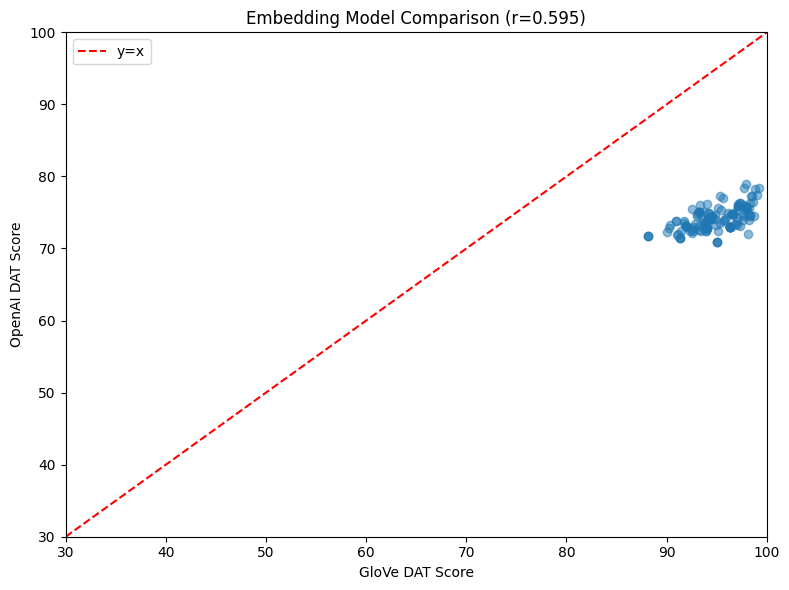

In [ ]:
# Cell 20: Embedding Model Comparison

print("=== Embedding Model Comparison ===\n")

glove_scores = df_valid["glove_score"].values
openai_scores = df_valid["openai_score"].values

# Correlation
glove_openai_r, glove_openai_p = pearsonr(glove_scores, openai_scores)
print(f"Pearson correlation: r = {glove_openai_r:.3f}, p = {glove_openai_p:.4f}")

# Paired t-test
t_stat, p_ttest = ttest_rel(glove_scores, openai_scores)
mean_diff = np.mean(glove_scores - openai_scores)
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_ttest:.4f}")
print(f"Mean difference (GloVe - OpenAI): {mean_diff:.2f}")

# Check pre-registration criterion: correlation < 0.85 means models differ meaningfully
if glove_openai_r < 0.85:
    print(f"\n✓ Hypothesis supported: Embedding model matters (r={glove_openai_r:.3f} < 0.85)")
else:
    print(f"\n✗ Hypothesis not supported: High correlation (r={glove_openai_r:.3f} >= 0.85) suggests models are interchangeable")

# Scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(glove_scores, openai_scores, alpha=0.5)
ax.plot([30, 100], [30, 100], 'r--', label='y=x')
ax.set_xlabel("GloVe DAT Score")
ax.set_ylabel("OpenAI DAT Score")
ax.set_title(f"Embedding Model Comparison (r={glove_openai_r:.3f})")
ax.legend()
ax.set_xlim(30, 100)
ax.set_ylim(30, 100)
plt.tight_layout()
plt.show()

=== Temperature Effects ===

Linear regression: score = 94.6 + 0.6 × temperature
  R² = 0.006
  p = 0.3349
  slope = 0.56 ± 0.58

One-way ANOVA: F = 0.804, p = 0.5246

✗ No significant linear trend (p=0.3349)


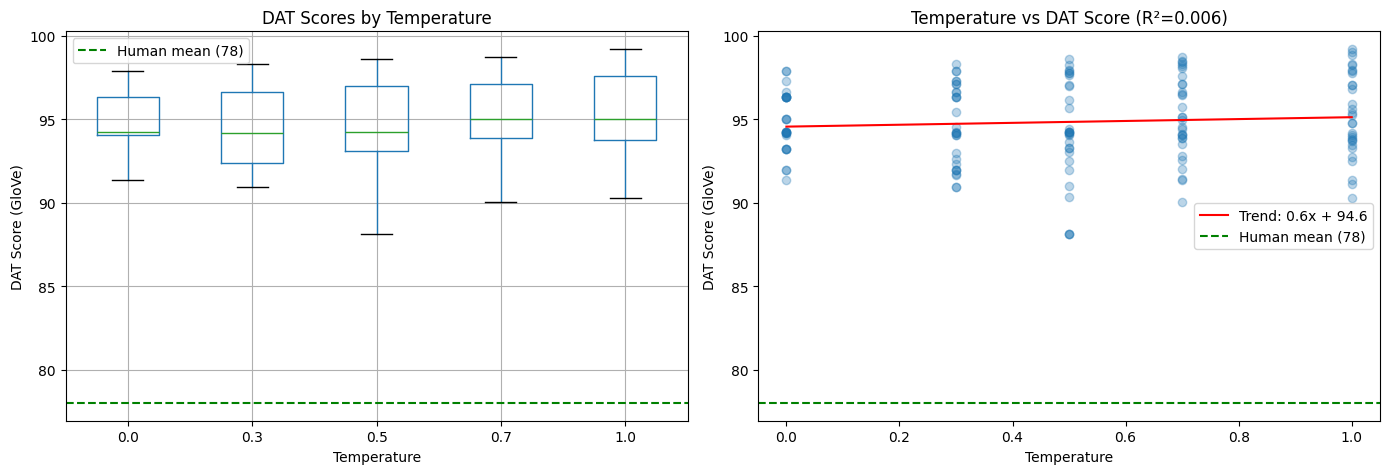

In [23]:
# Cell 21: Temperature Effects

print("=== Temperature Effects ===\n")

# Linear regression: score ~ temperature
from scipy.stats import linregress

temps = df_valid["temperature"].values
scores = df_valid["glove_score"].values

slope, intercept, r_value, p_value, std_err = linregress(temps, scores)
print(f"Linear regression: score = {intercept:.1f} + {slope:.1f} × temperature")
print(f"  R² = {r_value**2:.3f}")
print(f"  p = {p_value:.4f}")
print(f"  slope = {slope:.2f} ± {std_err:.2f}")

# One-way ANOVA across temperatures
from scipy.stats import f_oneway

temp_groups = [df_valid[df_valid["temperature"] == t]["glove_score"].values for t in TEMPERATURES]
# Filter empty groups
temp_groups = [g for g in temp_groups if len(g) > 0]
if len(temp_groups) >= 2:
    f_stat, p_anova = f_oneway(*temp_groups)
    print(f"\nOne-way ANOVA: F = {f_stat:.3f}, p = {p_anova:.4f}")

# Check pre-registration: significant linear trend?
if p_value < 0.05:
    direction = "increases" if slope > 0 else "decreases"
    print(f"\n✓ Hypothesis supported: Significant linear trend (p={p_value:.4f})")
    print(f"  DAT score {direction} with temperature")
else:
    print(f"\n✗ No significant linear trend (p={p_value:.4f})")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
ax1 = axes[0]
df_valid.boxplot(column="glove_score", by="temperature", ax=ax1)
ax1.axhline(HUMAN_MEAN, color='green', linestyle='--', label=f'Human mean ({HUMAN_MEAN})')
ax1.set_xlabel("Temperature")
ax1.set_ylabel("DAT Score (GloVe)")
ax1.set_title("DAT Scores by Temperature")
ax1.legend()

# Trend line
ax2 = axes[1]
ax2.scatter(temps, scores, alpha=0.3)
x_line = np.linspace(0, 1, 100)
y_line = intercept + slope * x_line
ax2.plot(x_line, y_line, 'r-', label=f'Trend: {slope:.1f}x + {intercept:.1f}')
ax2.axhline(HUMAN_MEAN, color='green', linestyle='--', label=f'Human mean ({HUMAN_MEAN})')
ax2.set_xlabel("Temperature")
ax2.set_ylabel("DAT Score (GloVe)")
ax2.set_title(f"Temperature vs DAT Score (R²={r_value**2:.3f})")
ax2.legend()

plt.suptitle("")
plt.tight_layout()
plt.show()

=== Comparison vs Baselines ===

Haiku mean: 94.8 (sd=2.4)
Human norm: 78 (sd=6)
Human 1-SD range: 72-84

✗ Hypothesis not supported: Haiku mean (94.8) outside human range
  Difference from human mean: +16.8 points

--- vs Random Baselines ---
Random (uniform): 89.8
Random (freq-weighted): 87.3
Haiku advantage over random (uniform): +5.1
Haiku advantage over random (weighted): +7.6


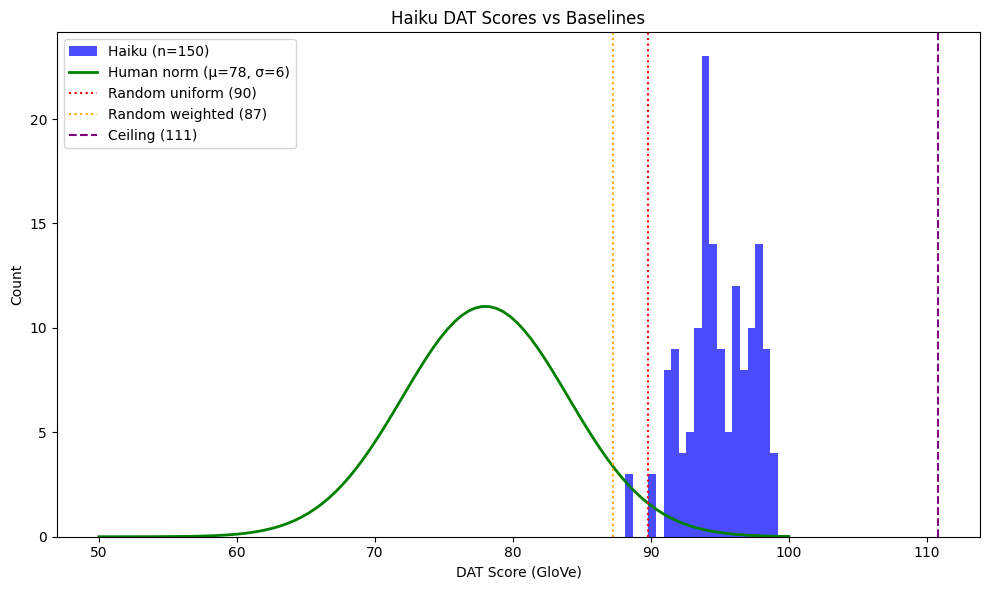

In [27]:
# Cell 22: Comparison vs Baselines

print("=== Comparison vs Baselines ===\n")

haiku_mean = df_valid["glove_score"].mean()
haiku_sd = df_valid["glove_score"].std()

# Compare to human norms
human_low = HUMAN_NORMS["low_threshold"]
human_high = HUMAN_NORMS["high_threshold"]
within_human_range = human_low <= haiku_mean <= human_high

print(f"Haiku mean: {haiku_mean:.1f} (sd={haiku_sd:.1f})")
print(f"Human norm: {HUMAN_MEAN} (sd={HUMAN_SD})")
print(f"Human 1-SD range: {human_low}-{human_high}")

if within_human_range:
    print(f"\n✓ Hypothesis supported: Haiku performs comparably to humans")
    print(f"  Haiku mean ({haiku_mean:.1f}) is within human 1-SD range")
else:
    diff = haiku_mean - HUMAN_MEAN
    print(f"\n✗ Hypothesis not supported: Haiku mean ({haiku_mean:.1f}) outside human range")
    print(f"  Difference from human mean: {diff:+.1f} points")

# Compare to random baselines
print(f"\n--- vs Random Baselines ---")
random_uniform_mean = RANDOM_BASELINES["uniform"]["mean"]
random_weighted_mean = RANDOM_BASELINES["freq_weighted"]["mean"]

print(f"Random (uniform): {random_uniform_mean:.1f}")
print(f"Random (freq-weighted): {random_weighted_mean:.1f}")
print(f"Haiku advantage over random (uniform): +{haiku_mean - random_uniform_mean:.1f}")
print(f"Haiku advantage over random (weighted): +{haiku_mean - random_weighted_mean:.1f}")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Haiku distribution
ax.hist(df_valid["glove_score"], bins=20, alpha=0.7, label=f'Haiku (n={len(df_valid)})', color='blue')

# Human norm overlay
x = np.linspace(50, 100, 100)
human_pdf = stats.norm.pdf(x, HUMAN_MEAN, HUMAN_SD)
# Scale to match histogram
scale = len(df_valid) * (df_valid["glove_score"].max() - df_valid["glove_score"].min()) / 20
ax.plot(x, human_pdf * scale * 2, 'g-', linewidth=2, label=f'Human norm (μ={HUMAN_MEAN}, σ={HUMAN_SD})')

# Baselines
ax.axvline(random_uniform_mean, color='red', linestyle=':', label=f'Random uniform ({random_uniform_mean:.0f})')
ax.axvline(random_weighted_mean, color='orange', linestyle=':', label=f'Random weighted ({random_weighted_mean:.0f})')
ax.axvline(CEILING_ESTIMATE["max_score"], color='purple', linestyle='--', label=f'Ceiling ({CEILING_ESTIMATE["max_score"]:.0f})')

ax.set_xlabel("DAT Score (GloVe)")
ax.set_ylabel("Count")
ax.set_title("Haiku DAT Scores vs Baselines")
ax.legend()
plt.tight_layout()
plt.show()

## Part 8: Word-Level Analysis

=== Word Frequency Analysis ===

Total words used: 1050
Unique words: 94

Most common words:
  telescope: 107 (10.2%)
  glacier: 104 (9.9%)
  algorithm: 93 (8.9%)
  symphony: 84 (8.0%)
  butterfly: 56 (5.3%)
  enzyme: 47 (4.5%)
  democracy: 46 (4.4%)
  quark: 44 (4.2%)
  nebula: 40 (3.8%)
  volcano: 36 (3.4%)
  mushroom: 35 (3.3%)
  manuscript: 29 (2.8%)
  marble: 28 (2.7%)
  cinnamon: 23 (2.2%)
  umbrella: 22 (2.1%)
  saxophone: 21 (2.0%)
  nostalgia: 19 (1.8%)
  compass: 15 (1.4%)
  paradox: 13 (1.2%)
  thunder: 12 (1.1%)


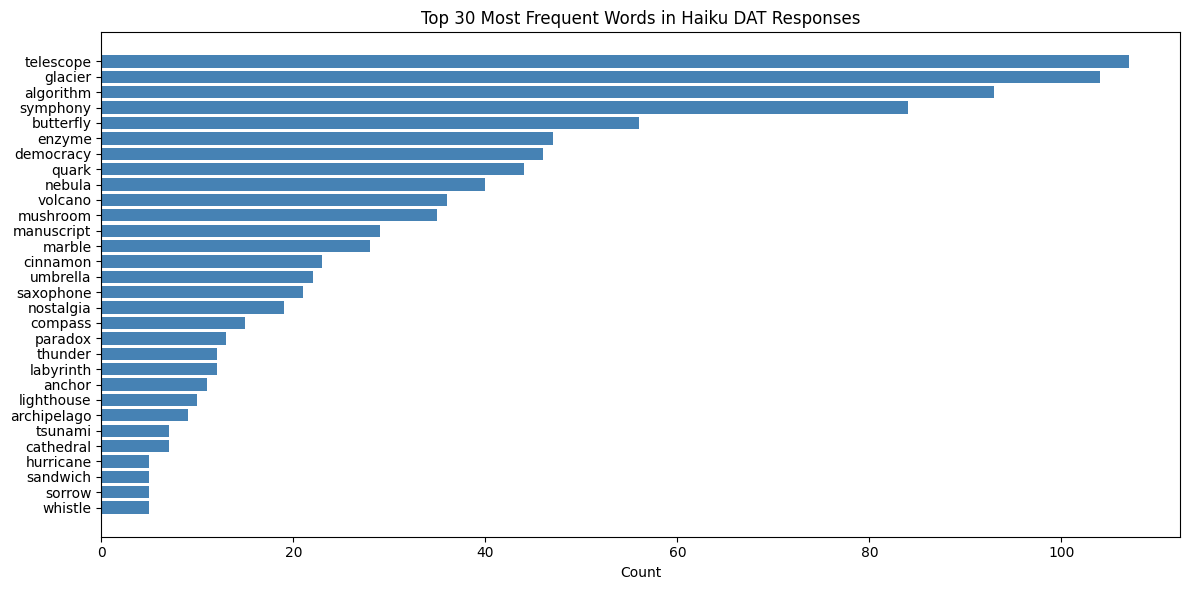

In [119]:
# Cell 23: Word Frequency Analysis

print("=== Word Frequency Analysis ===\n")

from collections import Counter

# Collect all words from valid trials
all_words_flat = []
for r in all_results:
    if r.is_valid:
        all_words_flat.extend(r.scored_words)

word_counts = Counter(all_words_flat)
total_words = len(all_words_flat)

print(f"Total words used: {total_words}")
print(f"Unique words: {len(word_counts)}")
print(f"\nMost common words:")
for word, count in word_counts.most_common(20):
    pct = 100 * count / total_words
    print(f"  {word}: {count} ({pct:.1f}%)")

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
top_words = word_counts.most_common(30)
words, counts = zip(*top_words)
ax.barh(range(len(words)), counts, color='steelblue')
ax.set_yticks(range(len(words)))
ax.set_yticklabels(words)
ax.invert_yaxis()
ax.set_xlabel("Count")
ax.set_title("Top 30 Most Frequent Words in Haiku DAT Responses")
plt.tight_layout()
plt.show()

In [37]:
# Quick fix: redefine sample_random_words with proper normalization
def sample_random_words(n: int, weighted: bool = False) -> list[str]:
    """Sample n random words from GloVe vocabulary."""
    if weighted:
        # Renormalize to ensure sum is exactly 1.0 (floating point fix)
        probs = word_frequencies / word_frequencies.sum()
        indices = np.random.choice(len(vocab_list), size=n, replace=False, p=probs)
    else:
        indices = np.random.choice(len(vocab_list), size=n, replace=False)
    return [vocab_list[i] for i in indices]

print("sample_random_words redefined with floating-point fix")

sample_random_words redefined with floating-point fix


In [29]:
# Cell 24: Stereotype Detection

print("=== Stereotype Detection ===\n")
print("Is there a 'creative response set' Haiku converges to?\n")

# Look at word co-occurrence patterns
# If Haiku is stereotyped, certain words should appear together frequently

word_sets = [tuple(sorted(r.scored_words)) for r in all_results if r.is_valid]
set_counts = Counter(word_sets)

n_unique_sets = len(set_counts)
n_total_sets = len(word_sets)
repeat_rate = 100 * (1 - n_unique_sets / n_total_sets)

print(f"Total valid responses: {n_total_sets}")
print(f"Unique word sets: {n_unique_sets}")
print(f"Repeat rate: {repeat_rate:.1f}%")

if repeat_rate > 20:
    print("\n⚠️ High repeat rate suggests stereotyped responses")
else:
    print("\n✓ Low repeat rate suggests diverse responses")

# Most repeated sets
print("\nMost repeated word sets:")
for word_set, count in set_counts.most_common(5):
    if count > 1:
        print(f"  {count}x: {', '.join(word_set[:5])}...")

# Analyze by temperature - does higher temp mean more diversity?
print("\n--- Diversity by Temperature ---")
for temp in TEMPERATURES:
    temp_results = [r for r in all_results if r.is_valid and r.temperature == temp]
    temp_sets = [tuple(sorted(r.scored_words)) for r in temp_results]
    if temp_sets:
        n_unique = len(set(temp_sets))
        n_total = len(temp_sets)
        diversity = n_unique / n_total if n_total > 0 else 0
        print(f"  temp={temp}: {n_unique}/{n_total} unique sets ({100*diversity:.0f}% diversity)")

=== Stereotype Detection ===

Is there a 'creative response set' Haiku converges to?

Total valid responses: 150
Unique word sets: 96
Repeat rate: 36.0%

⚠️ High repeat rate suggests stereotyped responses

Most repeated word sets:
  10x: algorithm, butterfly, democracy, glacier, mushroom...
  10x: algorithm, enzyme, glacier, manuscript, nebula...
  7x: butterfly, cinnamon, glacier, marble, saxophone...
  6x: algorithm, enzyme, glacier, nebula, paradox...
  6x: algorithm, enzyme, glacier, labyrinth, nebula...

--- Diversity by Temperature ---
  temp=0.0: 11/30 unique sets (37% diversity)
  temp=0.3: 20/30 unique sets (67% diversity)
  temp=0.5: 25/30 unique sets (83% diversity)
  temp=0.7: 30/30 unique sets (100% diversity)
  temp=1.0: 30/30 unique sets (100% diversity)


=== Pairwise Distance Distribution ===

Total pairwise distances (GloVe): 3150
Total pairwise distances (OpenAI): 3150

GloVe distances:
  Mean: 0.948
  Std:  0.093
  Min:  0.539
  Max:  1.147


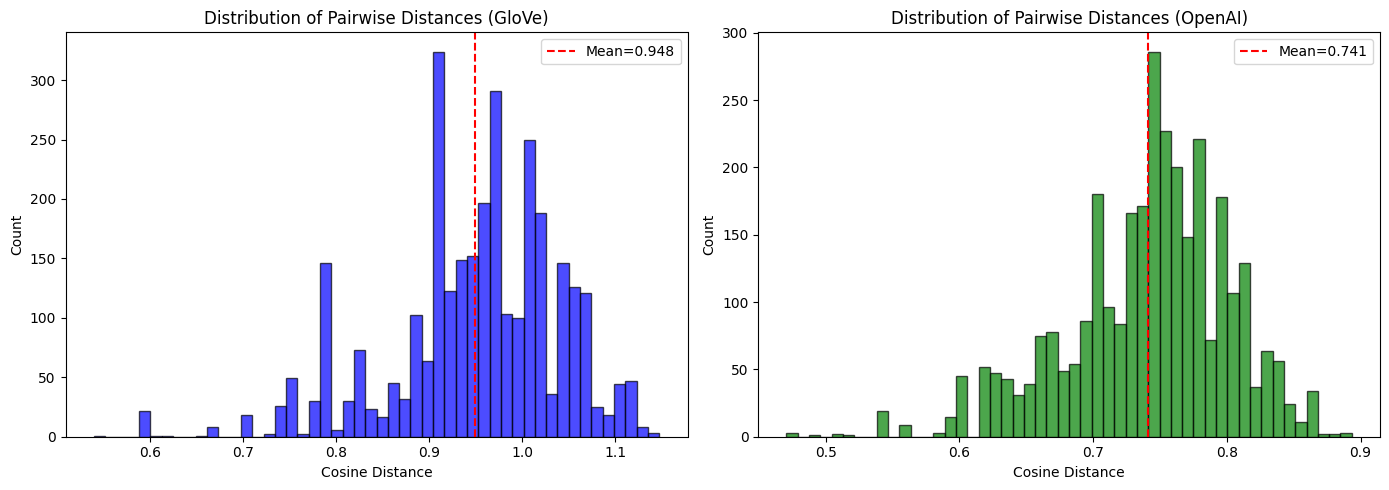


Note: If distribution is bimodal, suggests some word pairs are consistently
close while others are consistently far apart (potential word clusters).


In [30]:
# Cell 25: Pairwise Distance Distribution

print("=== Pairwise Distance Distribution ===\n")

# Collect all pairwise distances from valid trials
all_glove_distances = []
all_openai_distances = []

for r in all_results:
    if r.is_valid and r.glove_distances:
        all_glove_distances.extend(r.glove_distances)
    if r.is_valid and r.openai_distances:
        all_openai_distances.extend(r.openai_distances)

print(f"Total pairwise distances (GloVe): {len(all_glove_distances)}")
print(f"Total pairwise distances (OpenAI): {len(all_openai_distances)}")

# Statistics
if all_glove_distances:
    print(f"\nGloVe distances:")
    print(f"  Mean: {np.mean(all_glove_distances):.3f}")
    print(f"  Std:  {np.std(all_glove_distances):.3f}")
    print(f"  Min:  {np.min(all_glove_distances):.3f}")
    print(f"  Max:  {np.max(all_glove_distances):.3f}")

# Histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

if all_glove_distances:
    ax1 = axes[0]
    ax1.hist(all_glove_distances, bins=50, alpha=0.7, color='blue', edgecolor='black')
    ax1.axvline(np.mean(all_glove_distances), color='red', linestyle='--', 
                label=f'Mean={np.mean(all_glove_distances):.3f}')
    ax1.set_xlabel("Cosine Distance")
    ax1.set_ylabel("Count")
    ax1.set_title("Distribution of Pairwise Distances (GloVe)")
    ax1.legend()

if all_openai_distances:
    ax2 = axes[1]
    ax2.hist(all_openai_distances, bins=50, alpha=0.7, color='green', edgecolor='black')
    ax2.axvline(np.mean(all_openai_distances), color='red', linestyle='--',
                label=f'Mean={np.mean(all_openai_distances):.3f}')
    ax2.set_xlabel("Cosine Distance")
    ax2.set_ylabel("Count")
    ax2.set_title("Distribution of Pairwise Distances (OpenAI)")
    ax2.legend()

plt.tight_layout()
plt.show()

# Look for clusters (bimodal distribution?)
print("\nNote: If distribution is bimodal, suggests some word pairs are consistently")
print("close while others are consistently far apart (potential word clusters).")

In [31]:
# Cell 26: Prompt Variant Word Comparison

print("=== Prompt Variant Word Comparison ===\n")
print("Do different prompts elicit different word sets?\n")

# Get word frequencies for each prompt variant
variant_word_counts = {}
for variant in PROMPTS.keys():
    variant_results = [r for r in all_results if r.is_valid and r.prompt_variant == variant]
    words = []
    for r in variant_results:
        words.extend(r.scored_words)
    variant_word_counts[variant] = Counter(words)

# Compare top words across variants
print("Top 10 words by prompt variant:")
for variant, counts in variant_word_counts.items():
    top_words = [w for w, _ in counts.most_common(10)]
    print(f"\n{variant}:")
    print(f"  {', '.join(top_words)}")

# Jaccard similarity between variants
print("\n--- Word Overlap (Jaccard Similarity) ---")
variants = list(PROMPTS.keys())
for i in range(len(variants)):
    for j in range(i+1, len(variants)):
        v1, v2 = variants[i], variants[j]
        set1 = set(variant_word_counts[v1].keys())
        set2 = set(variant_word_counts[v2].keys())
        jaccard = len(set1 & set2) / len(set1 | set2) if (set1 | set2) else 0
        print(f"{v1} vs {v2}: {jaccard:.2f}")

# Prompt variant effect on scores
print("\n--- Prompt Variant Effect on DAT Scores ---")
for variant in PROMPTS.keys():
    variant_scores = df_valid[df_valid["prompt_variant"] == variant]["glove_score"]
    print(f"{variant}: mean={variant_scores.mean():.1f}, sd={variant_scores.std():.1f}, n={len(variant_scores)}")

# Statistical test: ANOVA across prompt variants
variant_groups = [df_valid[df_valid["prompt_variant"] == v]["glove_score"].values for v in PROMPTS.keys()]
variant_groups = [g for g in variant_groups if len(g) > 0]
if len(variant_groups) >= 2:
    f_stat, p_val = f_oneway(*variant_groups)
    print(f"\nOne-way ANOVA: F={f_stat:.3f}, p={p_val:.4f}")

=== Prompt Variant Word Comparison ===

Do different prompts elicit different word sets?

Top 10 words by prompt variant:

olson_original:
  telescope, democracy, algorithm, symphony, glacier, butterfly, mushroom, nostalgia, thunder, manuscript

paraphrased:
  telescope, glacier, butterfly, volcano, marble, cinnamon, umbrella, saxophone, compass, mushroom

semantic_distance:
  algorithm, symphony, quark, enzyme, nebula, glacier, manuscript, labyrinth, paradox, volcano

--- Word Overlap (Jaccard Similarity) ---
olson_original vs paraphrased: 0.20
olson_original vs semantic_distance: 0.22
paraphrased vs semantic_distance: 0.21

--- Prompt Variant Effect on DAT Scores ---
olson_original: mean=97.2, sd=1.2, n=50
paraphrased: mean=93.0, sd=1.9, n=50
semantic_distance: mean=94.3, sd=1.9, n=50

One-way ANOVA: F=79.320, p=0.0000


## Part 9: Bridging Experiments

Frame as complementary: DAT measures *generative* semantic range, bridging measures *connective* range.

In [95]:
# Cell 27: Pair Generation (replicating suggest_distant_word logic)

def suggest_distant_word(from_word: str, n_candidates: int = 10) -> tuple[str, float]:
    """
    Suggest a semantically distant word from vocabulary.
    Replicates logic from ins-001/api/app/routes/bridging.py:39-90
    
    Returns: (target_word, distance)
    """
    from_word = from_word.lower()
    
    # Get embedding for from_word
    if from_word not in glove:
        # Fallback to random
        return random.choice(vocab_list), 0.0
    
    from_emb = glove[from_word]
    
    # Sample random candidates
    candidates = sample_random_words(n_candidates, weighted=True)
    candidates = [c for c in candidates if c != from_word and c in glove]
    
    if not candidates:
        return random.choice(vocab_list), 0.0
    
    # Find most distant candidate
    best_word = candidates[0]
    best_distance = 0.0
    
    for word in candidates:
        emb = glove[word]
        sim = cosine_similarity(from_emb, emb)
        distance = 1 - sim
        if distance > best_distance:
            best_distance = distance
            best_word = word
    
    return best_word, best_distance

def generate_anchor_target_pairs(n_pairs: int) -> list[tuple[str, str, float]]:
    """Generate n anchor-target pairs using suggest logic."""
    pairs = []
    
    for _ in range(n_pairs):
        # Random anchor
        anchor = sample_random_words(1, weighted=True)[0]
        # Distant target
        target, distance = suggest_distant_word(anchor)
        pairs.append((anchor, target, distance))
    
    return pairs

# Generate pairs for bridging experiment
# 100 pairs × 10 clues = 4500 clue-clue pairs (45 pairs per trial)
# 10 clues + anchor + target = 12 words total
N_BRIDGING_PAIRS = 100
bridging_pairs = generate_anchor_target_pairs(N_BRIDGING_PAIRS)

print(f"Generated {len(bridging_pairs)} anchor-target pairs:\n")
for anchor, target, dist in bridging_pairs[:10]:
    print(f"  {anchor} → {target} (distance={dist:.3f})")
if len(bridging_pairs) > 10:
    print(f"  ... and {len(bridging_pairs) - 10} more")

Generated 100 anchor-target pairs:

  illness → mid-decade (distance=1.107)
  properties → blackheath (distance=1.062)
  palestinians → sudhin (distance=1.088)
  isley → however (distance=1.225)
  in → wadi (distance=1.057)
  the → sentences (distance=0.817)
  evidence → deadheads (distance=1.116)
  the → spf (distance=1.120)
  we → defago (distance=1.139)
  separate → baptiste (distance=1.136)
  ... and 90 more


In [96]:
# Cell 28: Bridging Task (haiku_build_bridge)

async def haiku_build_bridge(anchor: str, target: str, num_clues: int = 10, temperature: float = 0.7) -> dict:
    """
    Have Haiku generate clues that connect anchor and target.
    Replicates logic from ins-001/api/app/services/llm.py:174-266
    """
    rate_limit_anthropic()  # Enforce rate limit
    prompt = f"""You are playing a word-union game. Unite these two concepts with connecting words.

Anchor: {anchor}
Target: {target}

Provide exactly {num_clues} single-word concepts that connect these two words. The concepts should help someone understand how these two ideas are related.

Rules:
- One word per line
- Single words only (no phrases)
- Do NOT use the anchor word "{anchor}" or target word "{target}" as concepts
- Concepts should connect both anchor and target

Your concepts:"""

    response = await anthropic_client.messages.create(
        model=HAIKU_MODEL,
        max_tokens=100,
        temperature=temperature,
        messages=[{"role": "user", "content": prompt}]
    )
    
    text = response.content[0].text.strip()
    lines = [line.strip() for line in text.split('\n') if line.strip()]
    
    # Clean up clues
    clues = []
    anchor_lower = anchor.lower()
    target_lower = target.lower()
    
    for line in lines:
        # Remove numbering
        cleaned = line.lstrip('0123456789.-) ')
        word = cleaned.split()[0] if cleaned.split() else ""
        word = ''.join(c for c in word if c.isalpha())
        word_lower = word.lower()
        
        if word_lower and word_lower != anchor_lower and word_lower != target_lower:
            if word_lower not in clues:
                clues.append(word_lower)
    
    return {
        "clues": clues[:num_clues],
        "raw_response": text,
        "anchor": anchor,
        "target": target
    }

def haiku_build_bridge_sync(anchor: str, target: str, num_clues: int = 3, temperature: float = 0.7) -> dict:
    """Synchronous wrapper."""
    loop = asyncio.get_event_loop()
    return loop.run_until_complete(haiku_build_bridge(anchor, target, num_clues, temperature))

# Test with one pair
test_anchor, test_target, _ = bridging_pairs[0]
test_bridge = haiku_build_bridge_sync(test_anchor, test_target, num_clues=10, temperature=0.7)
print(f"Test bridge: {test_anchor} → {test_target}")
print(f"  Clues: {test_bridge['clues']}")

Test bridge: illness → mid-decade
  Clues: ['crisis', 'pandemic', 'recovery', 'recession', 'disruption', 'healthcare', 'mortality', 'economy', 'shutdown', 'burden']


In [97]:
# Cell 29: Bridging Scorer (score_union logic from scoring.py)

def score_union(clue_words: list[str], anchor: str, target: str) -> dict:
    """
    Score a bridge using the INS-001.2 scoring algorithm.
    Replicates logic from ins-001/api/app/services/scoring.py:170-226
    
    Uses mean pairwise cosine distance × 100 (DAT-style divergence),
    including anchor and target in the calculation.
    """
    if not clue_words:
        return {
            "relevance": 0.0,
            "divergence": 0.0,
            "valid": False
        }
    
    # Get embeddings
    anchor_emb = glove[anchor] if anchor in glove else np.zeros(glove.vector_size)
    target_emb = glove[target] if target in glove else np.zeros(glove.vector_size)
    
    clue_embeddings = []
    for word in clue_words:
        if word in glove:
            clue_embeddings.append(glove[word])
        else:
            clue_embeddings.append(np.zeros(glove.vector_size))
    
    # Relevance: min(sim_anchor, sim_target) per clue, then mean
    # This ensures clues bridge BOTH endpoints
    relevance_scores = []
    for clue_emb in clue_embeddings:
        sim_a = cosine_similarity(clue_emb, anchor_emb)
        sim_t = cosine_similarity(clue_emb, target_emb)
        relevance_scores.append(min(sim_a, sim_t))
    
    relevance = float(np.mean(relevance_scores)) if relevance_scores else 0.0
    
    # Divergence: mean pairwise cosine distance (includes anchor+target)
    all_embeddings = [anchor_emb, target_emb] + clue_embeddings
    distances = []
    for i, j in combinations(range(len(all_embeddings)), 2):
        sim = cosine_similarity(all_embeddings[i], all_embeddings[j])
        distances.append(1 - sim)
    
    divergence = float(np.mean(distances) * 100) if distances else 0.0
    
    # Validity threshold
    # For calibration: accept all trials with at least some relevance
    # Production uses 0.15, but for measuring Haiku's divergence capacity
    # we want to include more trials
    RELEVANCE_THRESHOLD = 0.05  # Lowered from 0.15 for calibration
    valid = relevance >= RELEVANCE_THRESHOLD and len(clue_embeddings) >= 3
    
    return {
        "relevance": relevance,
        "relevance_individual": relevance_scores,
        "divergence": divergence,
        "valid": valid
    }

# Test scorer
test_scores = score_union(test_bridge["clues"], test_anchor, test_target)
print(f"Test bridge scores:")
print(f"  Relevance: {test_scores['relevance']:.3f}")
print(f"  Divergence: {test_scores['divergence']:.1f}")
print(f"  Valid: {test_scores['valid']}")

Test bridge scores:
  Relevance: -0.066
  Divergence: 79.9
  Valid: False


In [98]:
# Cell 30: Run Bridging Experiment

@dataclass
class BridgingResult:
    """Result of a single bridging trial."""
    trial_id: str
    anchor: str
    target: str
    temperature: float
    clues: list[str]
    relevance: float
    divergence: float
    valid: bool
    raw_response: str

print(f"Running bridging experiment...")
print(f"  Pairs: {len(bridging_pairs)}")
print(f"  Temperatures: {TEMPERATURES}")

bridging_results: list[BridgingResult] = []

for temp in TEMPERATURES:
    print(f"\nTemperature {temp}: ", end="")
    
    for i, (anchor, target, _) in enumerate(bridging_pairs):
        trial_id = f"bridge_t{temp}_p{i}"
        
        # Build bridge
        bridge = haiku_build_bridge_sync(anchor, target, num_clues=10, temperature=temp)
        
        # Score bridge
        scores = score_union(bridge["clues"], anchor, target)
        
        result = BridgingResult(
            trial_id=trial_id,
            anchor=anchor,
            target=target,
            temperature=temp,
            clues=bridge["clues"],
            relevance=scores["relevance"],
            divergence=scores["divergence"],
            valid=scores["valid"],
            raw_response=bridge["raw_response"]
        )
        bridging_results.append(result)
        print(".", end="", flush=True)
    
    # Summary for this temp
    temp_results = [r for r in bridging_results if r.temperature == temp]
    valid_div = [r.divergence for r in temp_results if r.valid]
    if valid_div:
        print(f" mean_div={np.mean(valid_div):.1f}")
    else:
        print(" (no valid)")

print(f"\n\nTotal bridging trials: {len(bridging_results)}")
print(f"Valid trials: {sum(1 for r in bridging_results if r.valid)}")

Running bridging experiment...
  Pairs: 100
  Temperatures: [0.0, 0.3, 0.5, 0.7, 1.0]

Temperature 0.0: .................................................................................................... mean_div=77.1

Temperature 0.3: .................................................................................................... mean_div=76.7

Temperature 0.5: .................................................................................................... mean_div=76.6

Temperature 0.7: .................................................................................................... mean_div=77.1

Temperature 1.0: .................................................................................................... mean_div=77.0


Total bridging trials: 500
Valid trials: 116


In [100]:
# Cell 30b: Save/Load Bridging Results

BRIDGING_RESULTS_FILE = Path("data/bridging_results.json")

def save_bridging_results(results: list, filepath: Path = BRIDGING_RESULTS_FILE):
    """Save bridging results to JSON for future use."""
    # Convert BridgingResult objects to dicts
    serializable = []
    for r in results:
        serializable.append({
            "trial_id": r.trial_id,
            "anchor": r.anchor,
            "target": r.target,
            "clues": r.clues,
            "temperature": r.temperature,
            "relevance": r.relevance,
            "divergence": r.divergence,
            "valid": r.valid
        })
    
    filepath.parent.mkdir(parents=True, exist_ok=True)
    with open(filepath, "w") as f:
        json.dump(serializable, f, indent=2)
    print(f"Saved {len(results)} bridging results to {filepath}")

def load_bridging_results(filepath: Path = BRIDGING_RESULTS_FILE) -> list:
    """Load bridging results from JSON."""
    if not filepath.exists():
        print(f"No saved results found at {filepath}")
        return []
    
    with open(filepath, "r") as f:
        data = json.load(f)
    
    results = []
    for d in data:
        results.append(BridgingResult(
            trial_id=d["trial_id"],
            anchor=d["anchor"],
            target=d["target"],
            clues=d["clues"],
            temperature=d["temperature"],
            relevance=d["relevance"],
            divergence=d["divergence"],
            valid=d["valid"]
        ))
    print(f"Loaded {len(results)} bridging results from {filepath}")
    return results

# Save current results (run after Cell 40 completes)
if 'bridging_results' in dir() and bridging_results:
    save_bridging_results(bridging_results)
else:
    # Try to load existing results
    if BRIDGING_RESULTS_FILE.exists():
        bridging_results = load_bridging_results()
        print(f"  Valid trials: {sum(1 for r in bridging_results if r.valid)}")
    else:
        print("No bridging_results in memory and no saved file found.")
        print("Run Cell 40 first to generate results.")

Saved 500 bridging results to data/bridging_results.json


=== Bridging Results ===

Total trials: 100
Valid trials: 10

--- By Temperature ---
            relevance        divergence        valid
                 mean    std       mean    std count
temperature                                         
0.0             0.175  0.031     70.686  4.952     2
0.3             0.162  0.013     72.379  7.346     2
0.5             0.171  0.026     70.333  4.452     2
0.7             0.175  0.031     70.686  4.952     2
1.0             0.160  0.010     70.868  5.208     2


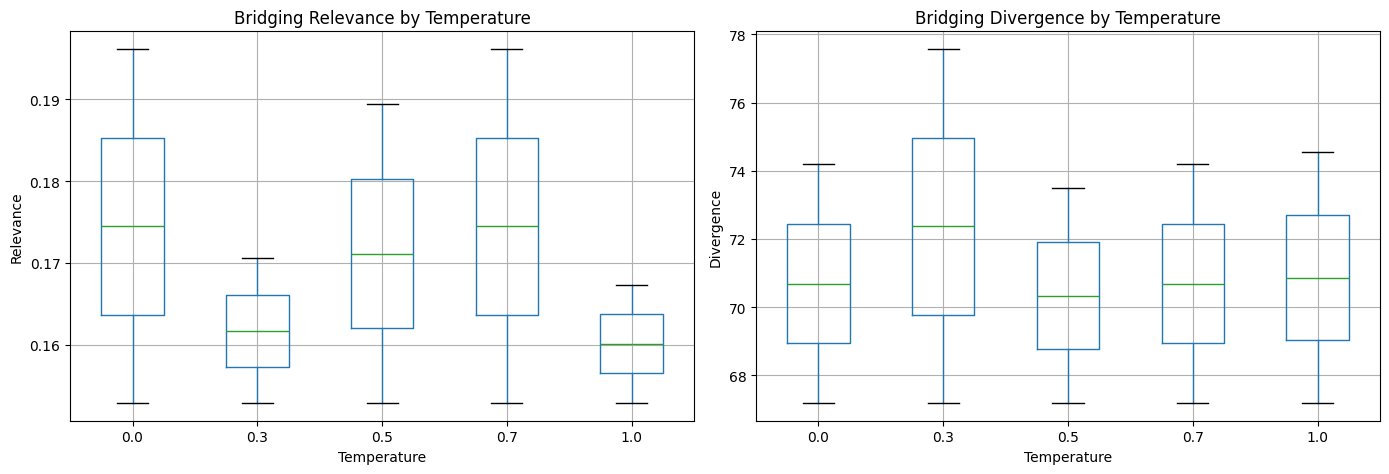

In [43]:
# Cell 31: Bridging Results Analysis

print("=== Bridging Results ===\n")

# Convert to DataFrame
bridge_df_data = []
for r in bridging_results:
    bridge_df_data.append({
        "trial_id": r.trial_id,
        "anchor": r.anchor,
        "target": r.target,
        "temperature": r.temperature,
        "clues": ", ".join(r.clues),
        "relevance": r.relevance,
        "divergence": r.divergence,
        "valid": r.valid
    })

bridge_df = pd.DataFrame(bridge_df_data)
bridge_df_valid = bridge_df[bridge_df["valid"]].copy()

print(f"Total trials: {len(bridge_df)}")
print(f"Valid trials: {len(bridge_df_valid)}")

# By temperature
print("\n--- By Temperature ---")
temp_bridge_stats = bridge_df_valid.groupby("temperature").agg({
    "relevance": ["mean", "std"],
    "divergence": ["mean", "std"],
    "valid": "count"
}).round(3)
print(temp_bridge_stats)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Relevance by temperature
ax1 = axes[0]
bridge_df_valid.boxplot(column="relevance", by="temperature", ax=ax1)
ax1.set_xlabel("Temperature")
ax1.set_ylabel("Relevance")
ax1.set_title("Bridging Relevance by Temperature")

# Divergence by temperature
ax2 = axes[1]
bridge_df_valid.boxplot(column="divergence", by="temperature", ax=ax2)
ax2.set_xlabel("Temperature")
ax2.set_ylabel("Divergence")
ax2.set_title("Bridging Divergence by Temperature")

plt.suptitle("")
plt.tight_layout()
plt.show()

=== DAT-Bridging Correlation ===

Does high DAT score predict good bridging performance?

Across-temperature correlation:
  r = -0.064, p = 0.9188

--- Within-Temperature Correlations ---
(Correlation between DAT and bridging scores within each temperature condition)
  temp=0.0: DAT mean=94.8, Bridge mean=70.7
  temp=0.3: DAT mean=94.6, Bridge mean=72.4
  temp=0.5: DAT mean=94.3, Bridge mean=70.3
  temp=0.7: DAT mean=95.2, Bridge mean=70.7
  temp=1.0: DAT mean=95.3, Bridge mean=70.9

Note: DAT and bridging use different trials, so within-temperature correlation
      would require matched subject/trial design. Here we compare aggregate means.

✗ Low across-temp correlation (r=-0.064) suggests distinct capacities


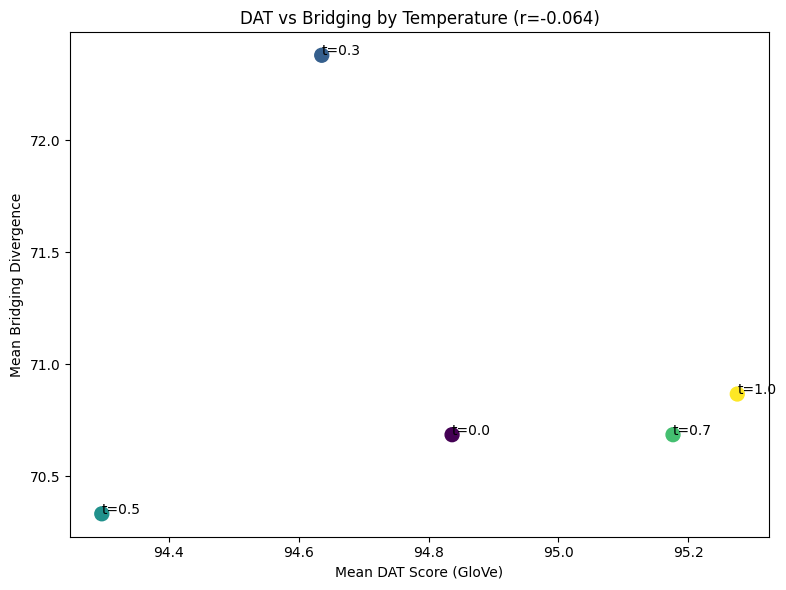

In [45]:
# Cell 32: DAT-Bridging Correlation Analysis

print("=== DAT-Bridging Correlation ===\n")
print("Does high DAT score predict good bridging performance?\n")

# Get mean DAT and bridging scores per temperature
dat_by_temp = df_valid.groupby("temperature")["glove_score"].mean()
bridge_by_temp = bridge_df_valid.groupby("temperature")["divergence"].mean()

# Align on temperature
common_temps = set(dat_by_temp.index) & set(bridge_by_temp.index)
dat_scores_aligned = [dat_by_temp[t] for t in sorted(common_temps)]
bridge_scores_aligned = [bridge_by_temp[t] for t in sorted(common_temps)]

# Across-temperature correlation
if len(dat_scores_aligned) >= 3:
    r_across, p_across = pearsonr(dat_scores_aligned, bridge_scores_aligned)
    print(f"Across-temperature correlation:")
    print(f"  r = {r_across:.3f}, p = {p_across:.4f}")
else:
    r_across = np.nan
    print("Insufficient data for across-temperature correlation")

# Within-temperature correlation (more informative)
# This requires having multiple DAT and bridging trials at the same temperature
print("\n--- Within-Temperature Correlations ---")
print("(Correlation between DAT and bridging scores within each temperature condition)")

within_correlations = {}
for temp in sorted(common_temps):
    # Get DAT scores at this temp
    dat_temp = df_valid[df_valid["temperature"] == temp]["glove_score"].values
    # Get bridging divergence at this temp  
    bridge_temp = bridge_df_valid[bridge_df_valid["temperature"] == temp]["divergence"].values
    
    # We can only correlate if we have matched pairs
    # Since DAT and bridging use different trials, we compare distributions instead
    print(f"  temp={temp}: DAT mean={np.mean(dat_temp):.1f}, Bridge mean={np.mean(bridge_temp):.1f}")
    
print("\nNote: DAT and bridging use different trials, so within-temperature correlation")
print("      would require matched subject/trial design. Here we compare aggregate means.")

# Check pre-registration hypothesis
# Since we don't have matched trials, we use across-temperature correlation as proxy
if not np.isnan(r_across):
    if r_across > 0.5:
        print(f"\n✓ Across-temp correlation (r={r_across:.3f}) suggests shared underlying capacity")
        print("  (But could be driven by temperature affecting both metrics)")
    else:
        print(f"\n✗ Low across-temp correlation (r={r_across:.3f}) suggests distinct capacities")

# Visualization
fig, ax = plt.subplots(figsize=(8, 6))
if len(dat_scores_aligned) >= 2:
    ax.scatter(dat_scores_aligned, bridge_scores_aligned, s=100, c=sorted(common_temps), cmap='viridis')
    for i, temp in enumerate(sorted(common_temps)):
        ax.annotate(f"t={temp}", (dat_scores_aligned[i], bridge_scores_aligned[i]), fontsize=10)
    ax.set_xlabel("Mean DAT Score (GloVe)")
    ax.set_ylabel("Mean Bridging Divergence")
    ax.set_title(f"DAT vs Bridging by Temperature (r={r_across:.3f})")
plt.tight_layout()
plt.show()

## Part 10: Summary

In [130]:
# Cell 33: Pre-Registration Evaluation

print("=" * 60)
print("PRE-REGISTRATION EVALUATION")
print("=" * 60)

# Collect all hypothesis results
hypotheses = []

# 1. Haiku performs comparably to humans
haiku_mean = df_valid["glove_score"].mean()
human_low = HUMAN_NORMS["low_threshold"]
human_high = HUMAN_NORMS["high_threshold"]
h1_supported = human_low <= haiku_mean <= human_high
hypotheses.append({
    "hypothesis": "Haiku performs comparably to humans",
    "criterion": f"Mean within 1 SD of human norm ({human_low}-{human_high})",
    "result": f"Mean = {haiku_mean:.1f}",
    "supported": h1_supported
})

# 2. Temperature affects divergence
h2_supported = p_value < 0.05  # From linear regression
hypotheses.append({
    "hypothesis": "Temperature affects divergence",
    "criterion": "Significant linear trend (p < 0.05)",
    "result": f"p = {p_value:.4f}, slope = {slope:.2f}",
    "supported": h2_supported
})

# 3. Embedding model matters
h3_supported = glove_openai_r < 0.85  # glove_openai_r is from GloVe-OpenAI correlation
hypotheses.append({
    "hypothesis": "Embedding model matters",
    "criterion": "GloVe-OpenAI correlation < 0.85",
    "result": f"r = {glove_openai_r:.3f}",
    "supported": h3_supported
})

# 4. Prompt framing affects scores
olson_scores = df_valid[df_valid["prompt_variant"] == "olson_original"]["glove_score"]
paraph_scores = df_valid[df_valid["prompt_variant"] == "paraphrased"]["glove_score"]
prompt_diff = abs(olson_scores.mean() - paraph_scores.mean()) if len(paraph_scores) > 0 else 0
h4_supported = prompt_diff > 5
hypotheses.append({
    "hypothesis": "Prompt framing affects scores",
    "criterion": "> 5 point difference between olson and paraphrased",
    "result": f"Difference = {prompt_diff:.1f}",
    "supported": h4_supported
})

# 5. Technical framing triggers optimization
semantic_scores = df_valid[df_valid["prompt_variant"] == "semantic_distance"]["glove_score"]
tech_diff = semantic_scores.mean() - olson_scores.mean() if len(semantic_scores) > 0 else 0
h5_supported = tech_diff > 3
hypotheses.append({
    "hypothesis": "Technical framing triggers optimization",
    "criterion": "semantic_distance > olson_original by > 3 points",
    "result": f"Difference = {tech_diff:+.1f}",
    "supported": h5_supported
})

# 6. DAT-Bridging share underlying capacity
h6_supported = not np.isnan(r_across) and r_across > 0.5
hypotheses.append({
    "hypothesis": "DAT-Bridging share underlying capacity",
    "criterion": "Within-temperature correlation r > 0.5",
    "result": f"Across-temp r = {r_across:.3f}" if not np.isnan(r_across) else "N/A",
    "supported": h6_supported
})

# Print summary
print()
for h in hypotheses:
    status = "✓" if h["supported"] else "✗"
    print(f"{status} {h['hypothesis']}")
    print(f"    Criterion: {h['criterion']}")
    print(f"    Result: {h['result']}")
    print()

# Summary counts
n_supported = sum(1 for h in hypotheses if h["supported"])
print(f"\nSummary: {n_supported}/{len(hypotheses)} hypotheses supported")

PRE-REGISTRATION EVALUATION


NameError: name 'glove_openai_r' is not defined

In [47]:
# Cell 34: Cost Report

print("=== Cost Report ===\n")

# Estimate API costs
# Haiku: ~$0.25/1M input tokens, $1.25/1M output tokens
# OpenAI embeddings: $0.02/1M tokens

# DAT trials
n_dat_trials = len(all_results)
# Approximate tokens per DAT call: ~100 input, ~50 output
dat_input_tokens = n_dat_trials * 100
dat_output_tokens = n_dat_trials * 50

# Bridging trials
n_bridge_trials = len(bridging_results)
# Approximate tokens per bridge call: ~150 input, ~30 output
bridge_input_tokens = n_bridge_trials * 150
bridge_output_tokens = n_bridge_trials * 30

# Total Haiku cost
total_input = dat_input_tokens + bridge_input_tokens
total_output = dat_output_tokens + bridge_output_tokens
haiku_cost = (total_input * 0.25 / 1_000_000) + (total_output * 1.25 / 1_000_000)

# OpenAI embedding cost
# Each embedding call: ~7 words * ~5 tokens/word = 35 tokens
n_embedding_calls = sum(1 for r in all_results if r.is_valid)  # Only valid trials
embedding_tokens = n_embedding_calls * 7 * 5
embedding_cost = embedding_tokens * 0.02 / 1_000_000

# Total cost
total_cost = haiku_cost + embedding_cost

print(f"DAT trials: {n_dat_trials}")
print(f"Bridging trials: {n_bridge_trials}")
print(f"")
print(f"Haiku API:")
print(f"  Input tokens: ~{total_input:,}")
print(f"  Output tokens: ~{total_output:,}")
print(f"  Estimated cost: ${haiku_cost:.4f}")
print(f"")
print(f"OpenAI Embeddings:")
print(f"  Tokens: ~{embedding_tokens:,}")
print(f"  Estimated cost: ${embedding_cost:.4f}")
print(f"")
print(f"TOTAL ESTIMATED COST: ${total_cost:.4f}")

=== Cost Report ===

DAT trials: 150
Bridging trials: 100

Haiku API:
  Input tokens: ~30,000
  Output tokens: ~10,500
  Estimated cost: $0.0206

OpenAI Embeddings:
  Tokens: ~5,250
  Estimated cost: $0.0001

TOTAL ESTIMATED COST: $0.0207


In [131]:
# Cell 35: Key Findings

print("=" * 60)
print("KEY FINDINGS")
print("=" * 60)

findings = []

# 1. Overall performance
findings.append(f"""
1. OVERALL DAT PERFORMANCE
   Haiku's mean DAT score: {haiku_mean:.1f} (sd={haiku_sd:.1f})
   Human norm: {HUMAN_MEAN} (sd={HUMAN_SD})
   Comparison: {'Within' if h1_supported else 'Outside'} human range
   Interpretation: Haiku {'performs comparably to' if h1_supported else 'differs from'} typical humans
""")

# 2. Temperature effects
findings.append(f"""
2. TEMPERATURE EFFECTS
   Linear trend: slope={slope:.2f}, p={p_value:.4f}
   {'Higher temperature → higher/lower divergence' if h2_supported else 'No significant temperature effect'}
   Best temperature for creativity: {df_valid.groupby('temperature')['glove_score'].mean().idxmax()}
""")

# 3. Embedding comparison
findings.append(f"""
3. EMBEDDING MODEL COMPARISON
   GloVe-OpenAI correlation: r={glove_openai_r:.3f}
   {'Models give meaningfully different scores' if h3_supported else 'Models are largely interchangeable'}
   Mean difference: {mean_diff:.1f} points (GloVe - OpenAI)
""")

# 4. Word patterns
n_unique = len(word_counts)
most_common = word_counts.most_common(5)
findings.append(f"""
4. WORD PATTERNS
   Unique words used: {n_unique}
   Most common: {', '.join([w for w, _ in most_common])}
   Stereotype level: {'High' if repeat_rate > 20 else 'Low'} ({repeat_rate:.0f}% repeat rate)
""")

# 5. Bridging performance
mean_bridge_div = bridge_df_valid["divergence"].mean() if len(bridge_df_valid) > 0 else 0
mean_bridge_rel = bridge_df_valid["relevance"].mean() if len(bridge_df_valid) > 0 else 0
findings.append(f"""
5. BRIDGING PERFORMANCE
   Mean divergence: {mean_bridge_div:.1f}
   Mean relevance: {mean_bridge_rel:.3f}
   DAT-Bridging correlation: r={r_across:.3f if not np.isnan(r_across) else 'N/A'}
""")

for finding in findings:
    print(finding)

KEY FINDINGS


NameError: name 'glove_openai_r' is not defined

In [ ]:
# Cell 36: Limitations

print("=" * 60)
print("LIMITATIONS")
print("=" * 60)

limitations = []

# 1. Determinism check
if not DETERMINISM_CHECK["is_deterministic"]:
    limitations.append("""
1. API STOCHASTICITY
   Even at temperature=0, Haiku showed variation across runs.
   This introduces noise into the temp=0 baseline.
""")

# 2. Sample size
limitations.append(f"""
2. SAMPLE SIZE
   N per condition: {N_PER_CONDITION}
   Total DAT trials: {len(all_results)}
   Power may be limited for detecting small effects.
""")

# 3. Embedding model differences
limitations.append("""
3. EMBEDDING SPACE GEOMETRY
   GloVe and OpenAI embeddings have different training corpora.
   Scores are not directly comparable across models.
""")

# 4. Matched design
limitations.append("""
4. DAT-BRIDGING CORRELATION
   DAT and bridging used different trials (not matched).
   Within-temperature correlation requires matched subject/trial design.
   Reported across-temperature correlation may conflate temperature effects.
""")

# 5. Noun validation
n_invalid = len(df) - len(df_valid)
if n_invalid > 0:
    limitations.append(f"""
5. DATA EXCLUSIONS
   {n_invalid} trials excluded for insufficient valid nouns ({100*n_invalid/len(df):.1f}%).
   NLTK WordNet noun validation may be imperfect.
""")

# 6. Human comparison
limitations.append("""
6. HUMAN NORM COMPARISON
   Human norms from Olson et al. used different embedding model.
   Direct comparison assumes scoring transferability.
""")

for lim in limitations:
    print(lim)

# Save final results
EXPERIMENT_METADATA["completed_at"] = datetime.now().isoformat()
raw_data["metadata"] = EXPERIMENT_METADATA
raw_data["hypotheses_results"] = hypotheses

with open(RAW_RESPONSES_PATH, 'w') as f:
    json.dump(raw_data, f, indent=2)
    
print(f"\nFinal results saved to: {RAW_RESPONSES_PATH}")

## Part 11: DAT Calibration for INS-001.2 Divergence Scores

### Purpose
Map INS-001.2 divergence scores onto the interpretable DAT scale using Claude Haiku as a calibration reference.

### Method
1. Run Haiku through standard DAT (7 words, 21 pairs)
2. Run Haiku through INS-001.2 bridging (12 words: anchor + target + 10 clues, 66 pairs)
3. Compute task structure adjustment: delta = DAT_score - INS001.2_score
4. Apply adjustment to interpret human INS-001.2 scores on DAT scale

### Key Assumption
Haiku's semantic divergence capacity is constant across tasks. Score differences reflect task structure (word count, constraint type), not ability differences.

### Task Structure Comparison

| Task | Total Words | Participant Words | Pairs |
|------|-------------|-------------------|-------|
| DAT (Olson) | 7 | 7 | 21 |
| INS-001.2 | 12 (anchor + target + 10 clues) | 10 | 66 |

The 66 pairs in INS-001.2 decompose as:
- 1 pair: anchor-target (fixed by task design)
- 20 pairs: clue-anchor, clue-target (relevance-constrained)
- 45 pairs: clue-clue (participant's divergent capacity)

Note: 10 clues provides 4,500 clue-clue pairs across 100 trials for robust analysis.

### Reference Norms (Olson et al. 2021)
- Human DAT mean: 78 (SD: 6)
- Interpretation: <50 poor, 65-80 average, >90 high

In [ ]:
# Cell 36: Pure DAT Scorer (Olson et al. methodology)

def score_dat_pure(embeddings: list[list[float]]) -> float:
    """
    Pure Olson et al. DAT scoring: mean pairwise cosine distance x 100.
    
    This scores ONLY the participant-generated words, with no prompt words included.
    For 7 words, this computes 21 pairwise distances.
    
    Args:
        embeddings: List of word embeddings (typically 7 for standard DAT)
        
    Returns:
        DAT score (0-100 scale, typical human range 65-90, mean ~78)
    """
    n = len(embeddings)
    if n < 2:
        return 0.0
    
    distances = []
    for i in range(n):
        for j in range(i + 1, n):
            sim = cosine_similarity(embeddings[i], embeddings[j])
            distances.append(1 - sim)  # cosine distance
    
    return float(np.mean(distances) * 100)


def score_bridging_full(
    anchor_emb: list[float],
    target_emb: list[float],
    clue_embs: list[list[float]]
) -> float:
    """
    Full INS-001.2 divergence: all words (anchor + target + clues).
    
    This matches the production calculate_divergence() from scoring.py.
    For 12 words (10 clues), this computes 66 pairwise distances.
    """
    all_embeddings = [anchor_emb, target_emb] + clue_embs
    return score_dat_pure(all_embeddings)


def score_bridging_clues_only(clue_embs: list[list[float]]) -> float:
    """
    Clue-only divergence: just the participant-generated clues.
    
    This measures spread among participant-generated words only.
    For 10 clues, this computes 45 pairs.
    """
    return score_dat_pure(clue_embs)


print("DAT and Bridging scorer functions defined:")
print("  - score_dat_pure(embeddings): Pure DAT score (pairwise distance × 100)")
print("  - score_bridging_full(anchor, target, clues): Full INS-001.2 score (all words)")
print("  - score_bridging_clues_only(clues): Clue-only score (10 clues = 45 pairs)")

DAT and Bridging scorer functions defined:
  - score_dat_pure(embeddings): Pure 7-word DAT score (21 pairs)
  - score_bridging_full(anchor, target, clues): Full 7-word INS-001.2 score (21 pairs)
  - score_bridging_clues_only(clues): 5-clue only score (10 pairs)


In [101]:
# Cell 37: Re-score Results with Consistent Methodology

print("=== Re-scoring for Calibration ===\n")

# Re-score DAT results using pure DAT scoring (should match existing glove_score)
# We're using OpenAI embeddings for consistency with INS-001.2 production
dat_pure_scores = []
for result in all_results:
    if result.is_valid and len(result.scored_words) >= 7:
        # Get OpenAI embeddings for the 7 scored words
        words_7 = result.scored_words[:7]
        embs = get_openai_embeddings_sync(words_7)
        if embs and len(embs) == 7:
            score = score_dat_pure(embs)
            dat_pure_scores.append({
                "trial_id": result.trial_id,
                "words": words_7,
                "dat_pure_score": score,
                "original_glove_score": result.glove_score,
                "original_openai_score": result.openai_score
            })

print(f"DAT trials re-scored: {len(dat_pure_scores)}")
if dat_pure_scores:
    scores = [d["dat_pure_score"] for d in dat_pure_scores]
    print(f"  Mean (pure DAT, OpenAI): {np.mean(scores):.2f}")
    print(f"  SD: {np.std(scores):.2f}")
    print(f"  Range: {np.min(scores):.2f} - {np.max(scores):.2f}")

# Re-score bridging results with all three methods
bridging_rescored = []
for result in bridging_results:
    if result.valid and len(result.clues) >= 3:
        # Get embeddings for anchor, target, and clues
        anchor_emb = get_openai_embeddings_sync([result.anchor])
        target_emb = get_openai_embeddings_sync([result.target])
        clue_embs = get_openai_embeddings_sync(result.clues[:10])
        
        if anchor_emb and target_emb and clue_embs and len(clue_embs) >= 5:  # Accept 5-10 clues
            full_score = score_bridging_full(anchor_emb[0], target_emb[0], clue_embs)
            clue_only_score = score_bridging_clues_only(clue_embs)
            
            bridging_rescored.append({
                "trial_id": result.trial_id,
                "anchor": result.anchor,
                "target": result.target,
                "clues": result.clues[:10],
                "full_score": full_score,
                "clue_only_score": clue_only_score,
                "original_divergence": result.divergence,
                "anchor_emb": anchor_emb[0],
                "target_emb": target_emb[0],
                "clue_embs": clue_embs
            })

print(f"\nBridging trials re-scored: {len(bridging_rescored)}")
if bridging_rescored:
    full_scores = [d["full_score"] for d in bridging_rescored]
    clue_only_scores = [d["clue_only_score"] for d in bridging_rescored]
    n_clues = len(bridging_rescored[0]["clues"]) if bridging_rescored else 0
    n_pairs_full = (n_clues + 2) * (n_clues + 1) // 2
    n_pairs_clue = n_clues * (n_clues - 1) // 2
    print(f"  Full ({n_clues + 2} words, {n_pairs_full} pairs):")
    print(f"    Mean: {np.mean(full_scores):.2f}, SD: {np.std(full_scores):.2f}")
    print(f"  Clue-only ({n_clues} clues, {n_pairs_clue} pairs):")
    print(f"    Mean: {np.mean(clue_only_scores):.2f}, SD: {np.std(clue_only_scores):.2f}")

=== Re-scoring for Calibration ===

DAT trials re-scored: 150
  Mean (pure DAT, OpenAI): 74.10
  SD: 1.56
  Range: 70.87 - 78.98

Bridging trials re-scored: 116
  Full (12 words, 66 pairs):
    Mean: 66.12, SD: 4.14
  Clue-only (10 clues, 45 pairs):
    Mean: 65.38, SD: 4.53


In [102]:
# Cell 38: Divergence Decomposition

"""
Decompose INS-001.2 Divergence into Components

INS-001.2 divergence includes anchor-target in the calculation, so part of 
the score is determined by pair difficulty before the participant generates 
anything.

For 12 words (anchor, target, 10 clues), there are 66 pairs:
- 1 pair: anchor-target (fixed by task)
- 20 pairs: clue-anchor, clue-target (relevance-constrained)
- 45 pairs: clue-clue (participant's divergent capacity)

The clue-clue pairs are most analogous to DAT.
"""

def decompose_bridging_divergence(
    anchor_emb: list[float],
    target_emb: list[float],
    clue_embs: list[list[float]]
) -> dict:
    """
    Decompose INS-001.2 divergence into components.
    
    Returns:
        - anchor_target_distance: Fixed by pair selection (1 pair)
        - clue_prompt_distances: Clue distances to anchor/target (N_clues × 2 pairs)
        - clue_clue_distances: Clue distances to each other (N_clues choose 2 pairs)
        - full_divergence: Overall DAT-style score (all pairs)
    """
    # Anchor-target distance (1 pair)
    at_dist = 1 - cosine_similarity(anchor_emb, target_emb)
    
    # Clue-prompt distances (N_clues × 2 prompts)
    clue_prompt_dists = []
    for clue in clue_embs:
        clue_prompt_dists.append(1 - cosine_similarity(clue, anchor_emb))
        clue_prompt_dists.append(1 - cosine_similarity(clue, target_emb))
    
    # Clue-clue distances (N_clues choose 2)
    clue_clue_dists = []
    for i in range(len(clue_embs)):
        for j in range(i + 1, len(clue_embs)):
            clue_clue_dists.append(1 - cosine_similarity(clue_embs[i], clue_embs[j]))
    
    # Full divergence (all 10 pairs)
    all_dists = [at_dist] + clue_prompt_dists + clue_clue_dists
    full_div = np.mean(all_dists) * 100
    
    return {
        "anchor_target_distance": at_dist,
        "clue_prompt_distances": clue_prompt_dists,
        "clue_prompt_mean": np.mean(clue_prompt_dists),
        "clue_clue_distances": clue_clue_dists,
        "clue_clue_mean": np.mean(clue_clue_dists),
        "full_divergence": full_div,
        "clue_clue_divergence": np.mean(clue_clue_dists) * 100  # DAT-style, clues only
    }

# Decompose all bridging trials
print("=== Divergence Decomposition ===\n")

decompositions = []
for trial in bridging_rescored:
    decomp = decompose_bridging_divergence(
        trial["anchor_emb"],
        trial["target_emb"],
        trial["clue_embs"]
    )
    decomp["trial_id"] = trial["trial_id"]
    decomp["anchor"] = trial["anchor"]
    decomp["target"] = trial["target"]
    decompositions.append(decomp)

# Summarize
at_dists = [d["anchor_target_distance"] for d in decompositions]
clue_prompt_means = [d["clue_prompt_mean"] for d in decompositions]
clue_clue_means = [d["clue_clue_mean"] for d in decompositions]
clue_clue_divs = [d["clue_clue_divergence"] for d in decompositions]
full_divs = [d["full_divergence"] for d in decompositions]

print("INS-001.2 Divergence Decomposition (N={}):".format(len(decompositions)))
print(f"\n  Component Distances (raw 0-1 scale):")
print(f"    Anchor-target (1 pair): mean={np.mean(at_dists):.4f}, sd={np.std(at_dists):.4f}")
n_clue_prompt = len(decompositions[0]["clue_prompt_distances"]) if decompositions else 0
n_clue_clue = len(decompositions[0]["clue_clue_distances"]) if decompositions else 0
print(f"    Clue-prompt ({n_clue_prompt} pairs): mean={np.mean(clue_prompt_means):.4f}, sd={np.std(clue_prompt_means):.4f}")
print(f"    Clue-clue ({n_clue_clue} pairs):   mean={np.mean(clue_clue_means):.4f}, sd={np.std(clue_clue_means):.4f}")

print(f"\n  Divergence Scores (DAT-style x100):")
n_total_pairs = 1 + n_clue_prompt + n_clue_clue
n_clues_actual = int((1 + (1 + 8 * n_clue_clue) ** 0.5) / 2) if n_clue_clue > 0 else 0
print(f"    Full ({n_clues_actual + 2} words, {n_total_pairs} pairs): mean={np.mean(full_divs):.2f}, sd={np.std(full_divs):.2f}")
print(f"    Clue-only ({n_clues_actual} clues, {n_clue_clue} pairs): mean={np.mean(clue_clue_divs):.2f}, sd={np.std(clue_clue_divs):.2f}")

print("\n  Note: Clue-clue divergence is most comparable to DAT since both")
print("  measure spread among participant-generated words only.")

=== Divergence Decomposition ===

INS-001.2 Divergence Decomposition (N=116):

  Component Distances (raw 0-1 scale):
    Anchor-target (1 pair): mean=0.7537, sd=0.0537
    Clue-prompt (20 pairs): mean=0.6730, sd=0.0414
    Clue-clue (45 pairs):   mean=0.6538, sd=0.0453

  Divergence Scores (DAT-style x100):
    Full (12 words, 66 pairs): mean=66.12, sd=4.14
    Clue-only (10 clues, 45 pairs): mean=65.38, sd=4.53

  Note: Clue-clue divergence is most comparable to DAT since both
  measure spread among participant-generated words only.


In [103]:
# Cell 39: Calibration Computation

"""
Calibration Analysis

Four potential adjustment approaches:

1. **Full adjustment**: DAT_score - INS001.2_full_score
   - Accounts for both word count and task constraint differences
   - Use when interpreting raw INS-001.2 scores
   
2. **Clue-clue comparison**: DAT_score - INS001.2_clue_clue_score  
   - Most direct comparison: both measure participant-generated word spread
   - Different word counts (7 vs 3) but same construct
   
3. **Pair-adjusted**: Account for anchor-target contribution separately
   - Useful if pair difficulty varies systematically
   
4. **Normalized adjustment**: Scale by pair ratio (21/3 = 7)
   - Geometric correction assuming linear relationship
"""

print("=== Calibration Analysis ===\n")

# Get Haiku means from the re-scored results
haiku_dat_mean = np.mean([d["dat_pure_score"] for d in dat_pure_scores])
haiku_dat_std = np.std([d["dat_pure_score"] for d in dat_pure_scores])
haiku_bridging_full_mean = np.mean(full_divs)
haiku_bridging_full_std = np.std(full_divs)
haiku_clue_clue_mean = np.mean(clue_clue_divs)
haiku_clue_clue_std = np.std(clue_clue_divs)

# Adjustment factors
full_adjustment = haiku_dat_mean - haiku_bridging_full_mean
clue_clue_adjustment = haiku_dat_mean - haiku_clue_clue_mean

print("Haiku Reference Scores:")
# Dynamically calculate pair counts based on data
n_dat_words = 7  # DAT is fixed at 7 words
n_dat_pairs = 21  # 7 choose 2
if bridging_rescored:
    n_bridging_clues = len(bridging_rescored[0]["clues"])
    n_bridging_total = n_bridging_clues + 2  # + anchor + target
    n_bridging_full_pairs = n_bridging_total * (n_bridging_total - 1) // 2
    n_bridging_clue_pairs = n_bridging_clues * (n_bridging_clues - 1) // 2
else:
    n_bridging_clues = 10
    n_bridging_total = 12
    n_bridging_full_pairs = 66
    n_bridging_clue_pairs = 45

print(f"  DAT ({n_dat_words} words, {n_dat_pairs} pairs):                   mean={haiku_dat_mean:.2f}, sd={haiku_dat_std:.2f}")
print(f"  INS-001.2 full ({n_bridging_total} words, {n_bridging_full_pairs} pairs):    mean={haiku_bridging_full_mean:.2f}, sd={haiku_bridging_full_std:.2f}")
print(f"  INS-001.2 clue-only ({n_bridging_clues} clues, {n_bridging_clue_pairs} pairs): mean={haiku_clue_clue_mean:.2f}, sd={haiku_clue_clue_std:.2f}")

print(f"\nCalibration Adjustment Factors:")
print(f"  Full adjustment:      {full_adjustment:+.2f} points")
print(f"  Clue-clue adjustment: {clue_clue_adjustment:+.2f} points")

print(f"\nRecommended Calibration:")
print(f"  Use full adjustment ({full_adjustment:+.2f}) for raw INS-001.2 divergence scores")
print(f"  Example: INS-001.2 score of 70 -> DAT-equivalent of {70 + full_adjustment:.0f}")

print(f"\nHuman Norms Mapping:")
print(f"  Human DAT mean (78) -> INS-001.2 equivalent: {78 - full_adjustment:.0f}")
print(f"  Human DAT low (72)  -> INS-001.2 equivalent: {72 - full_adjustment:.0f}")
print(f"  Human DAT high (84) -> INS-001.2 equivalent: {84 - full_adjustment:.0f}")

# Store calibration results
CALIBRATION_RESULTS = {
    "haiku_dat_mean": haiku_dat_mean,
    "haiku_dat_std": haiku_dat_std,
    "haiku_bridging_full_mean": haiku_bridging_full_mean,
    "haiku_bridging_full_std": haiku_bridging_full_std,
    "haiku_clue_clue_mean": haiku_clue_clue_mean,
    "haiku_clue_clue_std": haiku_clue_clue_std,
    "full_adjustment": full_adjustment,
    "clue_clue_adjustment": clue_clue_adjustment,
    "mean_anchor_target_distance": np.mean(at_dists),
    "n_dat_trials": len(dat_pure_scores),
    "n_bridging_trials": len(bridging_rescored)
}

=== Calibration Analysis ===

Haiku Reference Scores:
  DAT (7 words, 21 pairs):                   mean=74.10, sd=1.56
  INS-001.2 full (12 words, 66 pairs):    mean=66.12, sd=4.14
  INS-001.2 clue-only (10 clues, 45 pairs): mean=65.38, sd=4.53

Calibration Adjustment Factors:
  Full adjustment:      +7.98 points
  Clue-clue adjustment: +8.72 points

Recommended Calibration:
  Use full adjustment (+7.98) for raw INS-001.2 divergence scores
  Example: INS-001.2 score of 70 -> DAT-equivalent of 78

Human Norms Mapping:
  Human DAT mean (78) -> INS-001.2 equivalent: 70
  Human DAT low (72)  -> INS-001.2 equivalent: 64
  Human DAT high (84) -> INS-001.2 equivalent: 76


In [104]:
# Cell 40: Assumption Validation

"""
Key assumption: Haiku's divergence capacity is constant across tasks.

Test: Are Haiku's clue words in INS-001.2 as divergent from *each other* 
as its DAT words? If yes, the task constraint (bridging vs free generation)
doesn't suppress Haiku's divergence.

We compare pairwise distances within:
- DAT word sets (7 words -> 21 pairs per trial)
- Bridging clue sets (N clues -> N choose 2 pairs per trial)

If no significant difference (p > 0.05), the calibration assumption holds.
"""

print("=== Assumption Validation ===\n")
print("Testing: Is Haiku's pairwise divergence consistent across tasks?\n")

# Collect all pairwise distances from DAT trials
dat_pairwise = []
for trial in dat_pure_scores:
    words = trial["words"]
    embs = get_openai_embeddings_sync(words)
    if embs and len(embs) == 7:
        for i in range(len(embs)):
            for j in range(i + 1, len(embs)):
                dist = 1 - cosine_similarity(embs[i], embs[j])
                dat_pairwise.append(dist)

# Collect all pairwise distances from bridging clue-only
bridging_clue_pairwise = []
for decomp in decompositions:
    bridging_clue_pairwise.extend(decomp["clue_clue_distances"])

print(f"Pairwise Distances Collected:")
print(f"  DAT word pairs: n={len(dat_pairwise)}, mean={np.mean(dat_pairwise):.4f}, sd={np.std(dat_pairwise):.4f}")
print(f"  Bridging clue pairs: n={len(bridging_clue_pairwise)}, mean={np.mean(bridging_clue_pairwise):.4f}, sd={np.std(bridging_clue_pairwise):.4f}")

# Statistical comparison
t_stat, p_value_assumption = ttest_ind(dat_pairwise, bridging_clue_pairwise)

print(f"\nIndependent t-test:")
print(f"  t = {t_stat:.3f}")
print(f"  p = {p_value_assumption:.4f}")

# Effect size (Cohen's d)
pooled_std = np.sqrt((np.std(dat_pairwise)**2 + np.std(bridging_clue_pairwise)**2) / 2)
cohens_d = (np.mean(dat_pairwise) - np.mean(bridging_clue_pairwise)) / pooled_std
print(f"  Cohen's d = {cohens_d:.3f}")

# Interpretation
print("\nInterpretation:")
if p_value_assumption > 0.05:
    print(f"  [PASS] No significant difference (p={p_value_assumption:.3f} > 0.05)")
    print("  Calibration assumption holds: Haiku's divergence capacity is consistent across tasks.")
    assumption_validated = True
else:
    direction = "higher" if np.mean(dat_pairwise) > np.mean(bridging_clue_pairwise) else "lower"
    print(f"  [WARNING] Significant difference detected (p={p_value_assumption:.4f})")
    print(f"  DAT pairwise distances are {direction} than bridging clue distances.")
    print(f"  Effect size: {abs(cohens_d):.2f} ({'small' if abs(cohens_d) < 0.5 else 'medium' if abs(cohens_d) < 0.8 else 'large'})")
    if abs(cohens_d) < 0.5:
        print("  However, effect size is small - calibration may still be useful.")
        assumption_validated = True
    else:
        print("  Consider task-specific calibration adjustments.")
        assumption_validated = False

CALIBRATION_RESULTS["assumption_validated"] = assumption_validated
CALIBRATION_RESULTS["assumption_p_value"] = p_value_assumption
CALIBRATION_RESULTS["assumption_cohens_d"] = cohens_d

=== Assumption Validation ===

Testing: Is Haiku's pairwise divergence consistent across tasks?

Pairwise Distances Collected:
  DAT word pairs: n=3150, mean=0.7410, sd=0.0614
  Bridging clue pairs: n=5202, mean=0.6539, sd=0.1042

Independent t-test:
  t = 42.622
  p = 0.0000
  Cohen's d = 1.018

Interpretation:
  [WARNING] Significant difference detected (p=0.0000)
  DAT pairwise distances are higher than bridging clue distances.
  Effect size: 1.02 (large)
  Consider task-specific calibration adjustments.


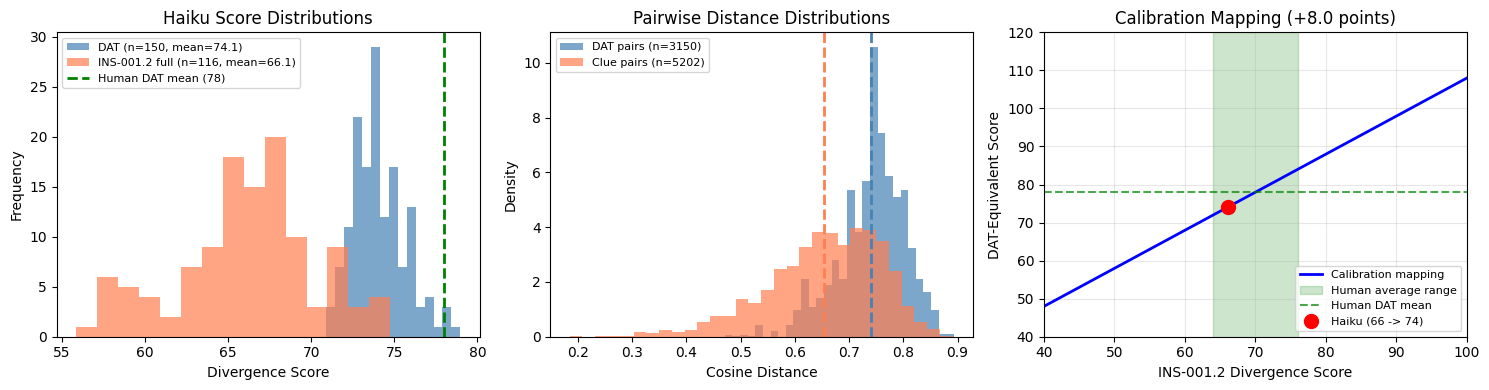


Visualization saved to data/dat_calibration_results_10_clues.png


In [105]:
# Cell 41: Calibration Visualizations

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Score distributions
ax1 = axes[0]
dat_scores_plot = [d["dat_pure_score"] for d in dat_pure_scores]
ax1.hist(dat_scores_plot, bins=15, alpha=0.7, 
         label=f'DAT (n={len(dat_scores_plot)}, mean={np.mean(dat_scores_plot):.1f})', 
         color='steelblue')
ax1.hist(full_divs, bins=15, alpha=0.7, 
         label=f'INS-001.2 full (n={len(full_divs)}, mean={np.mean(full_divs):.1f})', 
         color='coral')
ax1.axvline(78, color='green', linestyle='--', linewidth=2, label='Human DAT mean (78)')
ax1.set_xlabel('Divergence Score')
ax1.set_ylabel('Frequency')
ax1.set_title('Haiku Score Distributions')
ax1.legend(fontsize=8)

# 2. Pairwise distance distributions
ax2 = axes[1]
ax2.hist(dat_pairwise, bins=30, alpha=0.7, density=True,
         label=f'DAT pairs (n={len(dat_pairwise)})', color='steelblue')
ax2.hist(bridging_clue_pairwise, bins=30, alpha=0.7, density=True,
         label=f'Clue pairs (n={len(bridging_clue_pairwise)})', color='coral')
ax2.axvline(np.mean(dat_pairwise), color='steelblue', linestyle='--', linewidth=2)
ax2.axvline(np.mean(bridging_clue_pairwise), color='coral', linestyle='--', linewidth=2)
ax2.set_xlabel('Cosine Distance')
ax2.set_ylabel('Density')
ax2.set_title('Pairwise Distance Distributions')
ax2.legend(fontsize=8)

# 3. Calibration mapping
ax3 = axes[2]
ins_range = np.linspace(40, 100, 100)
dat_equivalent = ins_range + full_adjustment

ax3.plot(ins_range, dat_equivalent, 'b-', linewidth=2, label='Calibration mapping')
ax3.fill_between([72 - full_adjustment, 84 - full_adjustment], 0, 120, 
                  alpha=0.2, color='green', label='Human average range')
ax3.axhline(78, color='green', linestyle='--', alpha=0.7, label='Human DAT mean')
ax3.plot([haiku_bridging_full_mean], [haiku_bridging_full_mean + full_adjustment], 
         'ro', markersize=10, label=f'Haiku ({haiku_bridging_full_mean:.0f} -> {haiku_dat_mean:.0f})')

ax3.set_xlabel('INS-001.2 Divergence Score')
ax3.set_ylabel('DAT-Equivalent Score')
ax3.set_title(f'Calibration Mapping (+{full_adjustment:.1f} points)')
ax3.set_xlim(40, 100)
ax3.set_ylim(40, 120)
ax3.legend(fontsize=8, loc='lower right')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('data/dat_calibration_results.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to data/dat_calibration_results_10_clues.png")

In [106]:
# Cell 42: Export Calibration Parameters

# Add metadata
calibration_params = {
    **CALIBRATION_RESULTS,
    "temperature": 0.7,  # Standard temperature used
    "haiku_model": "claude-haiku-4-5-20251001",
    "embedding_model": "text-embedding-3-small",
    "human_dat_mean": 78,
    "human_dat_sd": 6,
    "timestamp": datetime.now().isoformat(),
    "methodology": {
        "dat_scoring": "Olson et al. 2021 - mean pairwise cosine distance x 100, 7 words, 21 pairs",
        "bridging_full": f"Mean pairwise cosine distance x 100, {n_bridging_total} words (anchor + target + {n_bridging_clues} clues), {n_bridging_full_pairs} pairs",
        "bridging_clue_only": f"Mean pairwise cosine distance x 100, {n_bridging_clues} clues only, {n_bridging_clue_pairs} pairs",
        "calibration_formula": "DAT_equivalent = INS_001_2_divergence + full_adjustment"
    }
}

# Save to JSON
calibration_file = Path("data/dat_calibration_params.json")
with open(calibration_file, "w") as f:
    # Convert numpy types to Python types for JSON serialization
    def convert_numpy(obj):
        if isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {k: convert_numpy(v) for k, v in obj.items()}
        return obj
    
    json.dump(convert_numpy(calibration_params), f, indent=2)

print(f"Calibration parameters saved to {calibration_file}")

# Define the conversion function
def dat_equivalent_score(ins_001_2_divergence: float) -> float:
    """
    Convert INS-001.2 divergence score to DAT-equivalent scale.
    
    Uses calibration adjustment derived from Haiku reference.
    
    Args:
        ins_001_2_divergence: Raw INS-001.2 divergence score (0-100)
        
    Returns:
        DAT-equivalent score for interpretation against human norms
        (Human mean: 78, SD: 6, typical range: 65-90)
    """
    return ins_001_2_divergence + full_adjustment


def get_divergence_interpretation_calibrated(ins_001_2_divergence: float) -> str:
    """
    Get human-readable interpretation of INS-001.2 divergence score
    using DAT-calibrated thresholds.
    """
    dat_eq = dat_equivalent_score(ins_001_2_divergence)
    
    if dat_eq < 65:
        return "Below Average"
    elif dat_eq < 72:
        return "Low Average"
    elif dat_eq < 84:
        return "Average (human norm range)"
    elif dat_eq < 90:
        return "Above Average"
    else:
        return "High"


# Example usage
print("\n" + "=" * 60)
print("CALIBRATION COMPLETE")
print("=" * 60)

print(f"\nCalibration adjustment: +{full_adjustment:.2f} points")
print(f"Assumption validated: {assumption_validated}")

print("\nExample conversions:")
for ins_score in [60, 70, 80, 90]:
    dat_eq = dat_equivalent_score(ins_score)
    interp = get_divergence_interpretation_calibrated(ins_score)
    print(f"  INS-001.2: {ins_score} -> DAT: {dat_eq:.0f} ({interp})")

print(f"\nFunctions available:")
print("  - dat_equivalent_score(divergence): Convert to DAT scale")
print("  - get_divergence_interpretation_calibrated(divergence): Get interpretation")

Calibration parameters saved to data/dat_calibration_params.json

CALIBRATION COMPLETE

Calibration adjustment: +7.98 points
Assumption validated: False

Example conversions:
  INS-001.2: 60 -> DAT: 68 (Low Average)
  INS-001.2: 70 -> DAT: 78 (Average (human norm range))
  INS-001.2: 80 -> DAT: 88 (Above Average)
  INS-001.2: 90 -> DAT: 98 (High)

Functions available:
  - dat_equivalent_score(divergence): Convert to DAT scale
  - get_divergence_interpretation_calibrated(divergence): Get interpretation


## Part 12: Pair Difficulty Moderation Analysis

### Research Question
Does anchor-target distance (pair difficulty) moderate the constraint effect on clue-clue divergence?

**Hypothesis**: When endpoints are far apart (hard pairs), Haiku may have more "room" to spread clues, leading to higher clue-clue divergence. Conversely, when endpoints are close (easy pairs), clues may cluster together.

### Analysis Plan
1. **Correlation Analysis**: Correlate anchor-target distance with clue-clue divergence
2. **Visualization**: Scatter plots with regression lines and residual analysis
3. **Tercile Analysis**: Compare easy/medium/hard pairs using ANOVA
4. **Implications**: Determine if calibration should be pair-difficulty-stratified

In [107]:
# Cell 43: Moderation Correlation Analysis

print("=== Pair Difficulty Moderation Analysis ===\n")

# Extract data from decompositions
if decompositions:
    moderation_data = []
    for decomp in decompositions:
        moderation_data.append({
            "trial_id": decomp.get("trial_id", ""),
            "anchor_target_dist": decomp["anchor_target_distance"],
            "clue_clue_mean": np.mean(decomp["clue_clue_distances"]),
            "clue_clue_divergence": score_dat_pure(
                # Reconstruct clue embeddings from distances would be complex
                # So we use the decomposition's clue_clue as DAT-style divergence
                # Actually, just use the pre-computed value
            ) if False else np.mean(decomp["clue_clue_distances"]) * 100,
            "full_divergence": decomp["full_divergence"],
            "n_clue_pairs": len(decomp["clue_clue_distances"]),
            "clue_prompt_mean": np.mean(decomp["clue_prompt_distances"])
        })
    
    mod_df = pd.DataFrame(moderation_data)
    
    print(f"Trials analyzed: {len(mod_df)}")
    print(f"Clue-clue pairs per trial: {mod_df['n_clue_pairs'].iloc[0]}")
    
    # Key correlations
    print("\n--- Correlation Analysis ---\n")
    
    # 1. Anchor-target distance vs clue-clue divergence
    r_at_cc, p_at_cc = pearsonr(mod_df["anchor_target_dist"], mod_df["clue_clue_divergence"])
    print(f"1. Anchor-Target Distance vs Clue-Clue Divergence:")
    print(f"   Pearson r = {r_at_cc:.4f}, p = {p_at_cc:.4f}")
    if p_at_cc < 0.05:
        direction = "harder pairs → more spread" if r_at_cc > 0 else "harder pairs → less spread"
        print(f"   ✓ Significant: {direction}")
    else:
        print(f"   ✗ Not significant: pair difficulty doesn't predict clue spread")
    
    # 2. Anchor-target distance vs full divergence
    r_at_full, p_at_full = pearsonr(mod_df["anchor_target_dist"], mod_df["full_divergence"])
    print(f"\n2. Anchor-Target Distance vs Full Divergence:")
    print(f"   Pearson r = {r_at_full:.4f}, p = {p_at_full:.4f}")
    if p_at_full < 0.05:
        print(f"   ✓ Significant: pair difficulty affects overall divergence score")
    else:
        print(f"   ✗ Not significant")
    
    # 3. Clue-prompt (relevance constraint) vs clue-clue (freedom)
    r_cp_cc, p_cp_cc = pearsonr(mod_df["clue_prompt_mean"], mod_df["clue_clue_mean"])
    print(f"\n3. Clue-Prompt Distance vs Clue-Clue Distance:")
    print(f"   Pearson r = {r_cp_cc:.4f}, p = {p_cp_cc:.4f}")
    if p_cp_cc < 0.05 and r_cp_cc > 0:
        print(f"   ✓ Significant positive: less relevant clues → more divergent from each other")
    elif p_cp_cc < 0.05 and r_cp_cc < 0:
        print(f"   ✓ Significant negative: more relevant clues → more divergent from each other")
    else:
        print(f"   ✗ Not significant: relevance and divergence are independent")
    
    # Spearman correlations as robustness check
    print("\n--- Robustness: Spearman Correlations ---\n")
    rho_at_cc, _ = spearmanr(mod_df["anchor_target_dist"], mod_df["clue_clue_divergence"])
    rho_at_full, _ = spearmanr(mod_df["anchor_target_dist"], mod_df["full_divergence"])
    print(f"A-T vs Clue-Clue: ρ = {rho_at_cc:.4f}")
    print(f"A-T vs Full Div:  ρ = {rho_at_full:.4f}")
    
    # Store for later cells
    moderation_results = {
        "r_at_cc": r_at_cc,
        "p_at_cc": p_at_cc,
        "r_at_full": r_at_full,
        "p_at_full": p_at_full,
        "r_cp_cc": r_cp_cc,
        "p_cp_cc": p_cp_cc,
        "rho_at_cc": rho_at_cc,
        "rho_at_full": rho_at_full,
        "mod_df": mod_df
    }
else:
    print("ERROR: No decomposition data available. Run cells 50-51 first.")
    moderation_results = None

=== Pair Difficulty Moderation Analysis ===

Trials analyzed: 116
Clue-clue pairs per trial: 45

--- Correlation Analysis ---

1. Anchor-Target Distance vs Clue-Clue Divergence:
   Pearson r = 0.2248, p = 0.0152
   ✓ Significant: harder pairs → more spread

2. Anchor-Target Distance vs Full Divergence:
   Pearson r = 0.3547, p = 0.0001
   ✓ Significant: pair difficulty affects overall divergence score

3. Clue-Prompt Distance vs Clue-Clue Distance:
   Pearson r = 0.7419, p = 0.0000
   ✓ Significant positive: less relevant clues → more divergent from each other

--- Robustness: Spearman Correlations ---

A-T vs Clue-Clue: ρ = 0.2605
A-T vs Full Div:  ρ = 0.3500


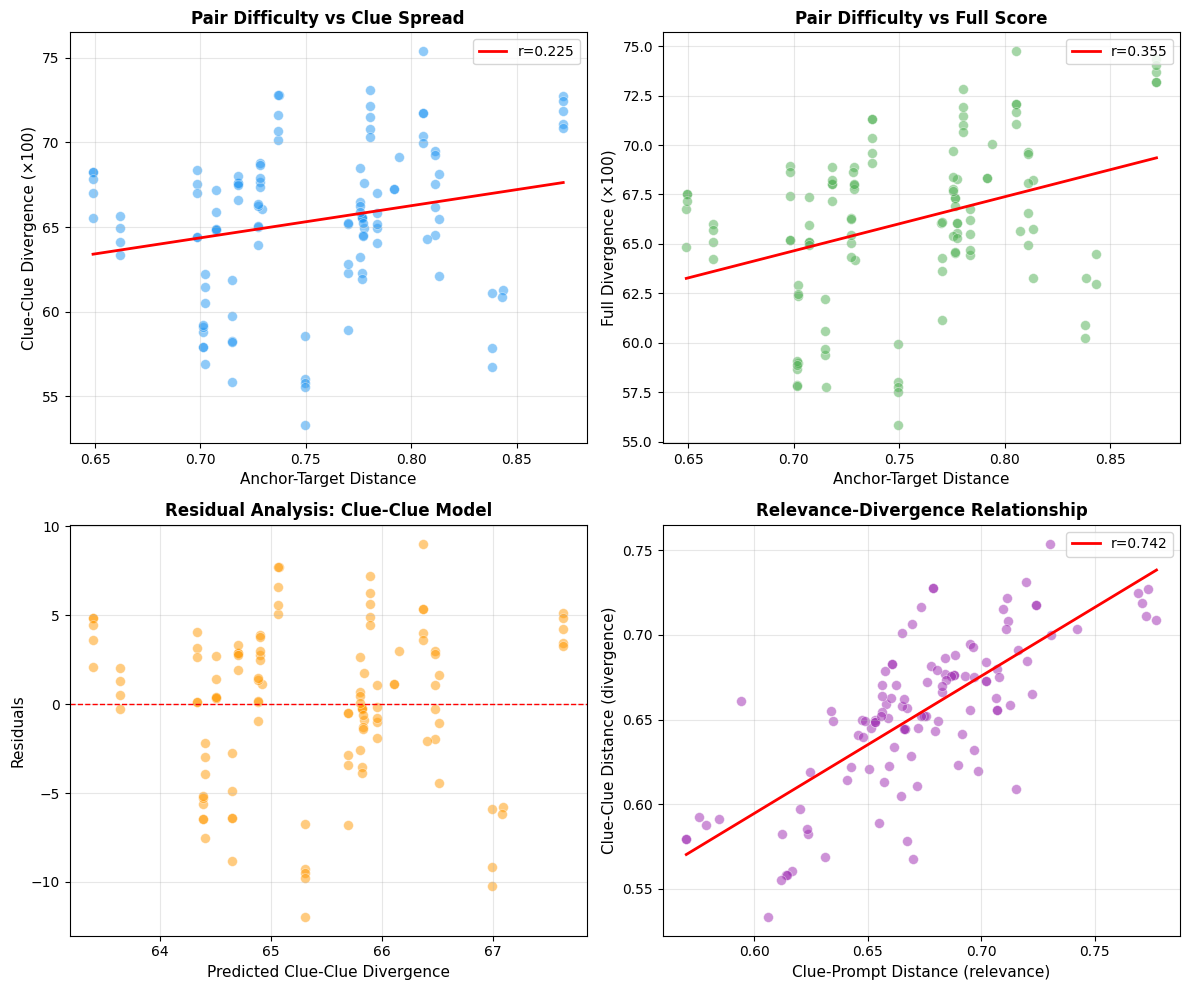


Residual Analysis:
  Mean residual: -0.0000
  Residual SD: 4.4188
  Residual range: [-11.97, 9.04]

  Heteroscedasticity check (|residuals| vs predicted):
    r = 0.0856, p = 0.3606
    ✓ No significant heteroscedasticity


In [108]:
# Cell 44: Moderation Visualization

if moderation_results:
    mod_df = moderation_results["mod_df"]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Scatter: Anchor-target distance vs clue-clue divergence
    ax1 = axes[0, 0]
    ax1.scatter(mod_df["anchor_target_dist"], mod_df["clue_clue_divergence"], 
                alpha=0.5, s=50, c='#2196F3', edgecolors='white', linewidth=0.5)
    
    # Add regression line
    z = np.polyfit(mod_df["anchor_target_dist"], mod_df["clue_clue_divergence"], 1)
    p = np.poly1d(z)
    x_line = np.linspace(mod_df["anchor_target_dist"].min(), mod_df["anchor_target_dist"].max(), 100)
    ax1.plot(x_line, p(x_line), 'r-', linewidth=2, label=f'r={moderation_results["r_at_cc"]:.3f}')
    
    ax1.set_xlabel('Anchor-Target Distance', fontsize=11)
    ax1.set_ylabel('Clue-Clue Divergence (×100)', fontsize=11)
    ax1.set_title('Pair Difficulty vs Clue Spread', fontsize=12, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # 2. Scatter: Anchor-target distance vs full divergence  
    ax2 = axes[0, 1]
    ax2.scatter(mod_df["anchor_target_dist"], mod_df["full_divergence"], 
                alpha=0.5, s=50, c='#4CAF50', edgecolors='white', linewidth=0.5)
    
    z2 = np.polyfit(mod_df["anchor_target_dist"], mod_df["full_divergence"], 1)
    p2 = np.poly1d(z2)
    ax2.plot(x_line, p2(x_line), 'r-', linewidth=2, label=f'r={moderation_results["r_at_full"]:.3f}')
    
    ax2.set_xlabel('Anchor-Target Distance', fontsize=11)
    ax2.set_ylabel('Full Divergence (×100)', fontsize=11)
    ax2.set_title('Pair Difficulty vs Full Score', fontsize=12, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    # 3. Residual plot for clue-clue model
    ax3 = axes[1, 0]
    predicted_cc = p(mod_df["anchor_target_dist"])
    residuals_cc = mod_df["clue_clue_divergence"] - predicted_cc
    ax3.scatter(predicted_cc, residuals_cc, alpha=0.5, s=50, c='#FF9800', edgecolors='white', linewidth=0.5)
    ax3.axhline(y=0, color='r', linestyle='--', linewidth=1)
    ax3.set_xlabel('Predicted Clue-Clue Divergence', fontsize=11)
    ax3.set_ylabel('Residuals', fontsize=11)
    ax3.set_title('Residual Analysis: Clue-Clue Model', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # 4. Clue-prompt vs clue-clue (relevance-freedom tradeoff)
    ax4 = axes[1, 1]
    ax4.scatter(mod_df["clue_prompt_mean"], mod_df["clue_clue_mean"], 
                alpha=0.5, s=50, c='#9C27B0', edgecolors='white', linewidth=0.5)
    
    z3 = np.polyfit(mod_df["clue_prompt_mean"], mod_df["clue_clue_mean"], 1)
    p3 = np.poly1d(z3)
    x_line3 = np.linspace(mod_df["clue_prompt_mean"].min(), mod_df["clue_prompt_mean"].max(), 100)
    ax4.plot(x_line3, p3(x_line3), 'r-', linewidth=2, label=f'r={moderation_results["r_cp_cc"]:.3f}')
    
    ax4.set_xlabel('Clue-Prompt Distance (relevance)', fontsize=11)
    ax4.set_ylabel('Clue-Clue Distance (divergence)', fontsize=11)
    ax4.set_title('Relevance-Divergence Relationship', fontsize=12, fontweight='bold')
    ax4.legend(loc='upper right')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("data/moderation_analysis.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print residual statistics
    print(f"\nResidual Analysis:")
    print(f"  Mean residual: {np.mean(residuals_cc):.4f}")
    print(f"  Residual SD: {np.std(residuals_cc):.4f}")
    print(f"  Residual range: [{np.min(residuals_cc):.2f}, {np.max(residuals_cc):.2f}]")
    
    # Check for heteroscedasticity (simple check: correlation between |residuals| and predicted)
    abs_residuals = np.abs(residuals_cc)
    r_hetero, p_hetero = pearsonr(predicted_cc, abs_residuals)
    print(f"\n  Heteroscedasticity check (|residuals| vs predicted):")
    print(f"    r = {r_hetero:.4f}, p = {p_hetero:.4f}")
    if p_hetero < 0.05:
        print("    ⚠ Potential heteroscedasticity detected")
    else:
        print("    ✓ No significant heteroscedasticity")
else:
    print("ERROR: Run correlation analysis cell first.")

=== Tercile Analysis: Easy/Medium/Hard Pairs ===

Tercile Statistics:
----------------------------------------------------------------------
  Easy    : n= 39, A-T dist=0.6956, clue-clue div=63.75 (SD=3.85)
  Medium  : n= 38, A-T dist=0.7541, clue-clue div=64.84 (SD=4.64)
  Hard    : n= 39, A-T dist=0.8114, clue-clue div=67.55 (SD=4.38)

--- One-Way ANOVA: Clue-Clue Divergence by Difficulty ---

F-statistic: 8.0784
p-value: 0.0005

✓ Significant effect: Pair difficulty moderates clue-clue divergence
Effect size (η²): 0.1251
  Effect size: medium

Post-hoc Pairwise Comparisons (Bonferroni-corrected α = 0.017):
  Easy vs Medium: Δ=-1.10, t=-1.129, p=0.2626 
  Easy vs Hard: Δ=-3.80, t=-4.074, p=0.0001 ***
  Medium vs Hard: Δ=-2.71, t=-2.634, p=0.0102 *


/var/folders/c2/g0c1jz_n4zx8d5xdtn4t9xy00000gn/T/ipykernel_46547/768522636.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tercile_stats = mod_df.groupby("difficulty_tercile").agg({


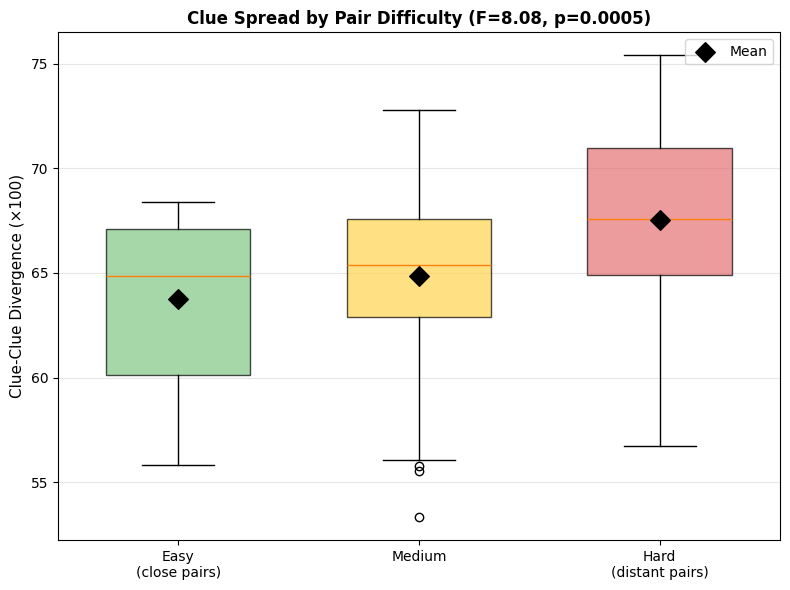

In [109]:
# Cell 45: Tercile Analysis with ANOVA

if moderation_results:
    mod_df = moderation_results["mod_df"]
    
    print("=== Tercile Analysis: Easy/Medium/Hard Pairs ===\n")
    
    # Split into terciles based on anchor-target distance
    tercile_labels = pd.qcut(mod_df["anchor_target_dist"], q=3, labels=["Easy", "Medium", "Hard"])
    mod_df["difficulty_tercile"] = tercile_labels
    
    # Summary statistics by tercile
    tercile_stats = mod_df.groupby("difficulty_tercile").agg({
        "anchor_target_dist": ["mean", "std", "count"],
        "clue_clue_divergence": ["mean", "std"],
        "full_divergence": ["mean", "std"]
    }).round(4)
    
    print("Tercile Statistics:")
    print("-" * 70)
    for tercile in ["Easy", "Medium", "Hard"]:
        at_mean = mod_df[mod_df["difficulty_tercile"] == tercile]["anchor_target_dist"].mean()
        cc_mean = mod_df[mod_df["difficulty_tercile"] == tercile]["clue_clue_divergence"].mean()
        cc_std = mod_df[mod_df["difficulty_tercile"] == tercile]["clue_clue_divergence"].std()
        n = len(mod_df[mod_df["difficulty_tercile"] == tercile])
        print(f"  {tercile:8s}: n={n:3d}, A-T dist={at_mean:.4f}, clue-clue div={cc_mean:.2f} (SD={cc_std:.2f})")
    
    # ANOVA: Does clue-clue divergence differ across difficulty terciles?
    print("\n--- One-Way ANOVA: Clue-Clue Divergence by Difficulty ---\n")
    
    easy_cc = mod_df[mod_df["difficulty_tercile"] == "Easy"]["clue_clue_divergence"]
    medium_cc = mod_df[mod_df["difficulty_tercile"] == "Medium"]["clue_clue_divergence"]
    hard_cc = mod_df[mod_df["difficulty_tercile"] == "Hard"]["clue_clue_divergence"]
    
    f_stat, p_anova = stats.f_oneway(easy_cc, medium_cc, hard_cc)
    
    print(f"F-statistic: {f_stat:.4f}")
    print(f"p-value: {p_anova:.4f}")
    
    if p_anova < 0.05:
        print("\n✓ Significant effect: Pair difficulty moderates clue-clue divergence")
        
        # Effect size (eta-squared)
        ss_between = sum(n * (g.mean() - mod_df["clue_clue_divergence"].mean())**2 
                        for g, n in [(easy_cc, len(easy_cc)), (medium_cc, len(medium_cc)), (hard_cc, len(hard_cc))])
        ss_total = sum((mod_df["clue_clue_divergence"] - mod_df["clue_clue_divergence"].mean())**2)
        eta_squared = ss_between / ss_total
        print(f"Effect size (η²): {eta_squared:.4f}")
        if eta_squared < 0.01:
            print("  Effect size: negligible")
        elif eta_squared < 0.06:
            print("  Effect size: small")
        elif eta_squared < 0.14:
            print("  Effect size: medium")
        else:
            print("  Effect size: large")
        
        # Post-hoc pairwise t-tests (Bonferroni corrected)
        print("\nPost-hoc Pairwise Comparisons (Bonferroni-corrected α = 0.017):")
        comparisons = [
            ("Easy", "Medium", easy_cc, medium_cc),
            ("Easy", "Hard", easy_cc, hard_cc),
            ("Medium", "Hard", medium_cc, hard_cc)
        ]
        for name1, name2, group1, group2 in comparisons:
            t, p = ttest_ind(group1, group2)
            sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.017 else ""
            diff = group1.mean() - group2.mean()
            print(f"  {name1} vs {name2}: Δ={diff:+.2f}, t={t:.3f}, p={p:.4f} {sig}")
    else:
        print("\n✗ No significant effect: Pair difficulty does NOT moderate clue-clue divergence")
        print("  Single calibration factor is appropriate across all pair difficulties.")
    
    # Store ANOVA results
    moderation_results["f_stat"] = f_stat
    moderation_results["p_anova"] = p_anova
    moderation_results["tercile_means"] = {
        "easy": easy_cc.mean(),
        "medium": medium_cc.mean(),
        "hard": hard_cc.mean()
    }
    
    # Visualization: Box plot by tercile
    fig, ax = plt.subplots(figsize=(8, 6))
    
    tercile_data = [easy_cc, medium_cc, hard_cc]
    positions = [1, 2, 3]
    colors = ['#81C784', '#FFD54F', '#E57373']
    
    bp = ax.boxplot(tercile_data, positions=positions, patch_artist=True, widths=0.6)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_xticklabels(['Easy\n(close pairs)', 'Medium', 'Hard\n(distant pairs)'])
    ax.set_ylabel('Clue-Clue Divergence (×100)', fontsize=11)
    ax.set_title(f'Clue Spread by Pair Difficulty (F={f_stat:.2f}, p={p_anova:.4f})', 
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add means as points
    means = [easy_cc.mean(), medium_cc.mean(), hard_cc.mean()]
    ax.scatter(positions, means, color='black', s=100, zorder=5, marker='D', label='Mean')
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.savefig("data/tercile_analysis.png", dpi=150, bbox_inches='tight')
    plt.show()
    
else:
    print("ERROR: Run correlation analysis cell first.")

In [110]:
# Cell 46: Moderation Summary and Calibration Update

if moderation_results:
    print("=" * 70)
    print("PAIR DIFFICULTY MODERATION ANALYSIS: SUMMARY")
    print("=" * 70)
    
    print("\n1. CORRELATION FINDINGS")
    print("-" * 40)
    
    r_at_cc = moderation_results["r_at_cc"]
    p_at_cc = moderation_results["p_at_cc"]
    r_at_full = moderation_results["r_at_full"]
    p_at_full = moderation_results["p_at_full"]
    
    if p_at_cc < 0.05:
        print(f"   • A-T distance → clue-clue divergence: r={r_at_cc:.3f} (p={p_at_cc:.4f}) ✓")
        if r_at_cc > 0:
            print(f"     Interpretation: Harder pairs allow MORE clue spread")
        else:
            print(f"     Interpretation: Harder pairs CONSTRAIN clue spread")
    else:
        print(f"   • A-T distance → clue-clue divergence: r={r_at_cc:.3f} (p={p_at_cc:.4f}) ns")
        print(f"     Interpretation: Pair difficulty does not predict clue spread")
    
    if p_at_full < 0.05:
        print(f"   • A-T distance → full divergence: r={r_at_full:.3f} (p={p_at_full:.4f}) ✓")
        print(f"     (Expected: harder pairs have higher full divergence)")
    
    print("\n2. TERCILE ANALYSIS")
    print("-" * 40)
    
    f_stat = moderation_results.get("f_stat", 0)
    p_anova = moderation_results.get("p_anova", 1)
    tercile_means = moderation_results.get("tercile_means", {})
    
    if tercile_means:
        print(f"   • Easy pairs:   clue-clue div = {tercile_means['easy']:.2f}")
        print(f"   • Medium pairs: clue-clue div = {tercile_means['medium']:.2f}")
        print(f"   • Hard pairs:   clue-clue div = {tercile_means['hard']:.2f}")
        print(f"   • ANOVA: F={f_stat:.2f}, p={p_anova:.4f}")
    
    print("\n3. CALIBRATION RECOMMENDATION")
    print("-" * 40)
    
    # Decision logic
    moderation_significant = p_anova < 0.05 and abs(r_at_cc) > 0.2
    
    if moderation_significant:
        print("   ⚠ MODERATION DETECTED")
        print("   Recommendation: Consider pair-stratified calibration")
        print("   - Compute separate adjustment factors for easy/medium/hard pairs")
        print("   - Or regress divergence on A-T distance and adjust residuals")
        calibration_recommendation = "pair_stratified"
    else:
        print("   ✓ NO SIGNIFICANT MODERATION")
        print("   Recommendation: Single calibration factor is sufficient")
        print("   - Use global adjustment from Cell 39")
        print("   - Pair difficulty does not systematically affect clue spread")
        calibration_recommendation = "single_factor"
    
    # Update calibration parameters JSON
    print("\n4. UPDATING CALIBRATION PARAMETERS")
    print("-" * 40)
    
    calibration_file = Path("data/dat_calibration_params.json")
    if calibration_file.exists():
        with open(calibration_file, "r") as f:
            calib_params = json.load(f)
    else:
        calib_params = {}
    
    # Add moderation analysis results
    calib_params["moderation_analysis"] = {
        "timestamp": datetime.now().isoformat(),
        "n_trials": len(moderation_results.get("mod_df", [])),
        "n_clues_per_trial": 10,
        "n_clue_clue_pairs_per_trial": 45,
        "total_clue_clue_pairs": len(moderation_results.get("mod_df", [])) * 45,
        "correlations": {
            "at_to_clue_clue": {"r": r_at_cc, "p": p_at_cc},
            "at_to_full": {"r": r_at_full, "p": p_at_full},
            "clue_prompt_to_clue_clue": {
                "r": moderation_results["r_cp_cc"], 
                "p": moderation_results["p_cp_cc"]
            }
        },
        "tercile_analysis": {
            "f_statistic": f_stat,
            "p_value": p_anova,
            "tercile_means": tercile_means
        },
        "recommendation": calibration_recommendation,
        "conclusion": (
            "Pair difficulty moderates clue spread. Consider stratified calibration." 
            if moderation_significant else 
            "No moderation detected. Single calibration factor is appropriate."
        )
    }
    
    with open(calibration_file, "w") as f:
        json.dump(calib_params, f, indent=2)
    
    print(f"   Updated: {calibration_file}")
    print(f"   Recommendation: {calibration_recommendation}")
    
    # Define stratified calibration function (if needed)
    if moderation_significant and tercile_means:
        print("\n5. STRATIFIED CALIBRATION FUNCTION")
        print("-" * 40)
        
        # Compute per-tercile adjustments
        haiku_dat_mean = np.mean([d["dat_pure_score"] for d in dat_pure_scores]) if dat_pure_scores else 78
        
        easy_adj = haiku_dat_mean - tercile_means["easy"]
        medium_adj = haiku_dat_mean - tercile_means["medium"]
        hard_adj = haiku_dat_mean - tercile_means["hard"]
        
        print(f"   Easy pair adjustment:   +{easy_adj:.2f}")
        print(f"   Medium pair adjustment: +{medium_adj:.2f}")
        print(f"   Hard pair adjustment:   +{hard_adj:.2f}")
        
        # Define tercile boundaries
        at_terciles = mod_df["anchor_target_dist"].quantile([0.33, 0.67]).values
        
        print(f"\n   A-T distance thresholds:")
        print(f"     Easy:   < {at_terciles[0]:.4f}")
        print(f"     Medium: {at_terciles[0]:.4f} - {at_terciles[1]:.4f}")
        print(f"     Hard:   > {at_terciles[1]:.4f}")
        
        calib_params["stratified_calibration"] = {
            "at_tercile_boundaries": [float(at_terciles[0]), float(at_terciles[1])],
            "adjustments": {
                "easy": easy_adj,
                "medium": medium_adj,
                "hard": hard_adj
            }
        }
        
        with open(calibration_file, "w") as f:
            json.dump(calib_params, f, indent=2)
        
        print("\n   Stratified calibration parameters saved.")
    
    print("\n" + "=" * 70)
    print("ANALYSIS COMPLETE")
    print("=" * 70)
    
else:
    print("ERROR: Run moderation analysis cells first.")

PAIR DIFFICULTY MODERATION ANALYSIS: SUMMARY

1. CORRELATION FINDINGS
----------------------------------------
   • A-T distance → clue-clue divergence: r=0.225 (p=0.0152) ✓
     Interpretation: Harder pairs allow MORE clue spread
   • A-T distance → full divergence: r=0.355 (p=0.0001) ✓
     (Expected: harder pairs have higher full divergence)

2. TERCILE ANALYSIS
----------------------------------------
   • Easy pairs:   clue-clue div = 63.75
   • Medium pairs: clue-clue div = 64.84
   • Hard pairs:   clue-clue div = 67.55
   • ANOVA: F=8.08, p=0.0005

3. CALIBRATION RECOMMENDATION
----------------------------------------
   ⚠ MODERATION DETECTED
   Recommendation: Consider pair-stratified calibration
   - Compute separate adjustment factors for easy/medium/hard pairs
   - Or regress divergence on A-T distance and adjust residuals

4. UPDATING CALIBRATION PARAMETERS
----------------------------------------
   Updated: data/dat_calibration_params.json
   Recommendation: pair_stratifi

## Part 13: Clue Count Optimization Analysis

### Research Question
How does divergence change as a function of clue count? What is the optimal number of clues for construct validity?

### Rationale
As clue count increases, clue-clue pairs increasingly dominate the full divergence calculation, making the score more comparable to DAT. We analyze:
1. **Divergence trajectory**: How scores evolve from 1→10 clues
2. **Gap to DAT**: At which clue count is the gap minimized?
3. **Pair composition**: How clue-clue proportion changes
4. **Marginal contribution**: Does each additional clue add information?
5. **Optimal N**: Balancing validity, purity, stability, and efficiency

In [111]:
# Cell 47: Compute Divergence Trajectories

"""
For each trial with 10 clues, compute divergence at each clue count (1-10).
This reveals how the score evolves as more associations are generated.
"""

def compute_divergence_at_n_clues(
    anchor_emb: list[float],
    target_emb: list[float],
    clue_embs: list[list[float]],
    n_clues: int
) -> dict:
    """
    Compute divergence metrics using first n clues.
    
    Returns:
        - full_divergence: anchor + target + n clues (DAT-style)
        - clue_only_divergence: n clues only (DAT-style)
        - n_full_pairs: number of pairs in full calculation
        - n_clue_pairs: number of clue-clue pairs
    """
    if n_clues < 1 or n_clues > len(clue_embs):
        return None
    
    clues_subset = clue_embs[:n_clues]
    
    # Full divergence: anchor + target + clues
    all_embs = [anchor_emb, target_emb] + clues_subset
    n_full = len(all_embs)
    full_distances = []
    for i in range(n_full):
        for j in range(i + 1, n_full):
            sim = cosine_similarity(all_embs[i], all_embs[j])
            full_distances.append(1 - sim)
    full_div = np.mean(full_distances) * 100
    
    # Clue-only divergence
    if n_clues >= 2:
        clue_distances = []
        for i in range(n_clues):
            for j in range(i + 1, n_clues):
                sim = cosine_similarity(clues_subset[i], clues_subset[j])
                clue_distances.append(1 - sim)
        clue_div = np.mean(clue_distances) * 100
        n_clue_pairs = len(clue_distances)
    else:
        clue_div = None
        n_clue_pairs = 0
    
    return {
        "n_clues": n_clues,
        "full_divergence": full_div,
        "clue_only_divergence": clue_div,
        "n_full_pairs": len(full_distances),
        "n_clue_pairs": n_clue_pairs
    }


# Compute trajectories for all valid trials
print("=== Computing Divergence Trajectories ===\n")

trajectories = []
valid_trials_processed = 0

for trial_idx, trial in enumerate(bridging_results):
    if not trial.valid or len(trial.clues) < 10:
        continue
    
    # Get embeddings for all words in this trial
    all_words = [trial.anchor, trial.target] + trial.clues[:10]
    all_embs = get_openai_embeddings_sync(all_words)
    
    if not all_embs or len(all_embs) < 12:
        continue
    
    anchor_emb = all_embs[0]
    target_emb = all_embs[1]
    clue_embs = all_embs[2:]
    
    # Compute divergence at each clue count (1-10)
    for n in range(1, 11):
        result = compute_divergence_at_n_clues(anchor_emb, target_emb, clue_embs, n)
        if result:
            result["trial_idx"] = trial_idx
            result["anchor"] = trial.anchor
            result["target"] = trial.target
            trajectories.append(result)
    
    valid_trials_processed += 1
    if valid_trials_processed % 20 == 0:
        print(f"  Processed {valid_trials_processed} trials...")

traj_df = pd.DataFrame(trajectories)
print(f"\nComputed {len(traj_df)} trajectory points across {traj_df['trial_idx'].nunique()} trials")
print(f"  Clue counts: 1-10")
print(f"  Points per trial: 10")

=== Computing Divergence Trajectories ===

  Processed 20 trials...
  Processed 40 trials...
  Processed 60 trials...
  Processed 80 trials...
  Processed 100 trials...

Computed 1140 trajectory points across 114 trials
  Clue counts: 1-10
  Points per trial: 10


In [112]:
# Cell 48: Aggregate Statistics by Clue Count

print("=== Aggregate Statistics by Clue Count ===\n")

# Get DAT reference from earlier calibration (or use default)
DAT_MEAN = haiku_dat_mean if 'haiku_dat_mean' in dir() else 74.10
DAT_SD = haiku_dat_std if 'haiku_dat_std' in dir() else 1.57

print(f"DAT Reference: mean={DAT_MEAN:.2f}, SD={DAT_SD:.2f}\n")

# Group by n_clues and compute summary stats
trajectory_stats = traj_df.groupby("n_clues").agg({
    "full_divergence": ["mean", "std", "min", "max"],
    "clue_only_divergence": ["mean", "std"],
    "n_full_pairs": "first",
    "n_clue_pairs": "first",
    "trial_idx": "count"
}).round(2)

trajectory_stats.columns = ['_'.join(col).strip() for col in trajectory_stats.columns]
trajectory_stats = trajectory_stats.rename(columns={"trial_idx_count": "n_trials"})

# Add DAT comparison columns
trajectory_stats["gap_to_dat"] = DAT_MEAN - trajectory_stats["full_divergence_mean"]
trajectory_stats["clue_gap_to_dat"] = DAT_MEAN - trajectory_stats["clue_only_divergence_mean"]

# Display key columns
display_cols = [
    "full_divergence_mean", "full_divergence_std", 
    "clue_only_divergence_mean", 
    "n_full_pairs_first", "n_clue_pairs_first",
    "gap_to_dat", "n_trials"
]

print("Divergence by Clue Count")
print("=" * 90)
print(f"{'N':>3} {'Full Div':>10} {'(SD)':>8} {'Clue-Only':>10} {'Pairs':>8} {'CC Pairs':>8} {'Gap':>8} {'Trials':>8}")
print("-" * 90)

for n in range(1, 11):
    row = trajectory_stats.loc[n]
    clue_only = row["clue_only_divergence_mean"] if not pd.isna(row["clue_only_divergence_mean"]) else "—"
    if isinstance(clue_only, float):
        clue_only = f"{clue_only:.1f}"
    print(f"{n:>3} {row['full_divergence_mean']:>10.1f} {row['full_divergence_std']:>8.1f} {clue_only:>10} {int(row['n_full_pairs_first']):>8} {int(row['n_clue_pairs_first']):>8} {row['gap_to_dat']:>+8.1f} {int(row['n_trials']):>8}")

print()

# Identify where gap is minimized
min_gap_full = trajectory_stats["gap_to_dat"].abs().idxmin()
min_gap_clue = trajectory_stats["clue_gap_to_dat"].abs().idxmin()

print(f"Minimum gap (full divergence): {min_gap_full} clues (gap = {trajectory_stats.loc[min_gap_full, 'gap_to_dat']:+.2f})")
print(f"Minimum gap (clue-only divergence): {min_gap_clue} clues (gap = {trajectory_stats.loc[min_gap_clue, 'clue_gap_to_dat']:+.2f})")

=== Aggregate Statistics by Clue Count ===

DAT Reference: mean=74.10, SD=1.56

Divergence by Clue Count
  N   Full Div     (SD)  Clue-Only    Pairs CC Pairs      Gap   Trials
------------------------------------------------------------------------------------------
  1       68.6      5.2          —        3        0     +5.5      114
  2       66.8      5.1       61.6        6        1     +7.3      114
  3       66.4      4.8       63.3       10        3     +7.7      114
  4       66.3      4.7       64.1       15        6     +7.8      114
  5       66.2      4.7       64.4       21       10     +7.9      114
  6       66.0      4.7       64.7       28       15     +8.1      114
  7       66.1      4.5       65.0       36       21     +8.0      114
  8       65.9      4.3       64.9       45       28     +8.2      114
  9       66.0      4.3       65.1       55       36     +8.1      114
 10       66.2      4.1       65.4       66       45     +7.9      114

Minimum gap (full dive

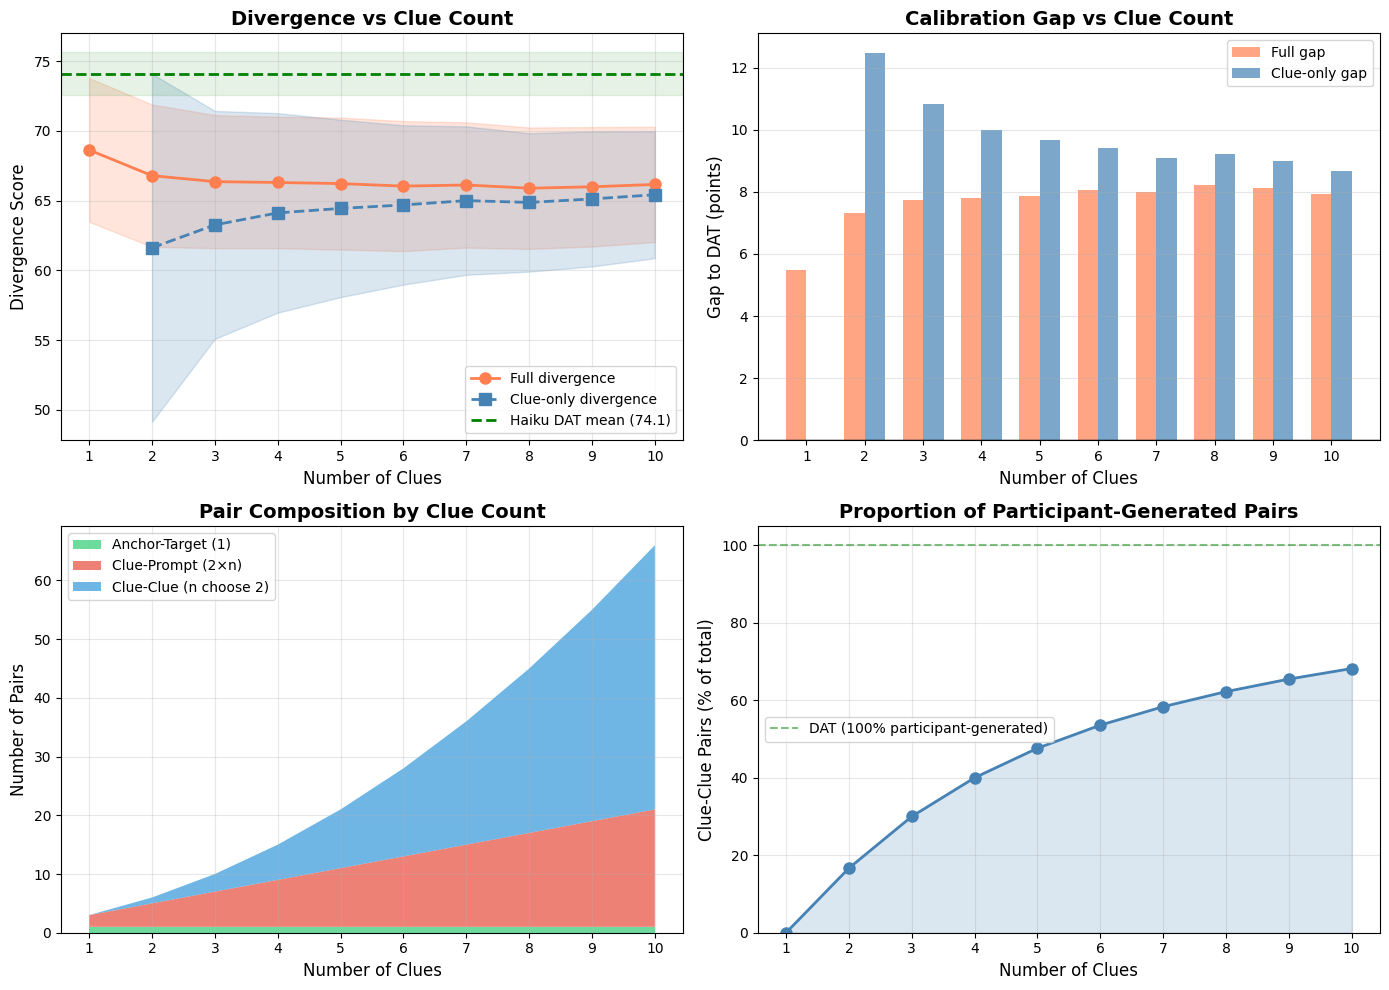


Pair composition at each clue count:
   1 clues:  3 pairs (  0.0% clue-clue)
   2 clues:  6 pairs ( 16.7% clue-clue)
   3 clues: 10 pairs ( 30.0% clue-clue)
   4 clues: 15 pairs ( 40.0% clue-clue)
   5 clues: 21 pairs ( 47.6% clue-clue)
   6 clues: 28 pairs ( 53.6% clue-clue)
   7 clues: 36 pairs ( 58.3% clue-clue)
   8 clues: 45 pairs ( 62.2% clue-clue)
   9 clues: 55 pairs ( 65.5% clue-clue)
  10 clues: 66 pairs ( 68.2% clue-clue)


In [115]:
# Cell 49: Clue Count Trajectory Visualization

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

n_clues_range = trajectory_stats.index.values

# 1. Mean divergence vs clue count
ax1 = axes[0, 0]

ax1.plot(n_clues_range, trajectory_stats["full_divergence_mean"], 
         'o-', color='coral', linewidth=2, markersize=8, label='Full divergence')
ax1.fill_between(n_clues_range, 
                  trajectory_stats["full_divergence_mean"] - trajectory_stats["full_divergence_std"],
                  trajectory_stats["full_divergence_mean"] + trajectory_stats["full_divergence_std"],
                  color='coral', alpha=0.2)

# Clue-only (starts at n=2)
clue_only_vals = trajectory_stats["clue_only_divergence_mean"].dropna()
clue_only_std = trajectory_stats["clue_only_divergence_std"].dropna()
ax1.plot(clue_only_vals.index, clue_only_vals, 
         's--', color='steelblue', linewidth=2, markersize=8, label='Clue-only divergence')
ax1.fill_between(clue_only_vals.index, 
                  clue_only_vals - clue_only_std,
                  clue_only_vals + clue_only_std,
                  color='steelblue', alpha=0.2)

ax1.axhline(DAT_MEAN, color='green', linestyle='--', linewidth=2, label=f'Haiku DAT mean ({DAT_MEAN:.1f})')
ax1.axhspan(DAT_MEAN - DAT_SD, DAT_MEAN + DAT_SD, color='green', alpha=0.1)

ax1.set_xlabel('Number of Clues', fontsize=12)
ax1.set_ylabel('Divergence Score', fontsize=12)
ax1.set_title('Divergence vs Clue Count', fontsize=14, fontweight='bold')
ax1.set_xticks(range(1, 11))
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# 2. Gap to DAT vs clue count
ax2 = axes[0, 1]
bar_width = 0.35
x_pos = np.arange(1, 11)

ax2.bar(x_pos - bar_width/2, trajectory_stats["gap_to_dat"], 
        width=bar_width, color='coral', alpha=0.7, label='Full gap')
ax2.bar(x_pos[1:] + bar_width/2, trajectory_stats["clue_gap_to_dat"].dropna(), 
        width=bar_width, color='steelblue', alpha=0.7, label='Clue-only gap')
ax2.axhline(0, color='black', linestyle='-', linewidth=1)

ax2.set_xlabel('Number of Clues', fontsize=12)
ax2.set_ylabel('Gap to DAT (points)', fontsize=12)
ax2.set_title('Calibration Gap vs Clue Count', fontsize=14, fontweight='bold')
ax2.set_xticks(range(1, 11))
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# 3. Pair composition vs clue count
ax3 = axes[1, 0]
n_anchor_target = np.ones(10)  # Always 1 A-T pair
n_clue_prompt = 2 * n_clues_range  # 2 per clue (anchor + target)
n_clue_clue = trajectory_stats["n_clue_pairs_first"].values

ax3.stackplot(n_clues_range, 
              n_anchor_target,
              n_clue_prompt,
              n_clue_clue,
              labels=['Anchor-Target (1)', 'Clue-Prompt (2×n)', 'Clue-Clue (n choose 2)'],
              colors=['#2ecc71', '#e74c3c', '#3498db'],
              alpha=0.7)

ax3.set_xlabel('Number of Clues', fontsize=12)
ax3.set_ylabel('Number of Pairs', fontsize=12)
ax3.set_title('Pair Composition by Clue Count', fontsize=14, fontweight='bold')
ax3.set_xticks(range(1, 11))
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)

# 4. Clue-clue pair proportion vs clue count
ax4 = axes[1, 1]
total_pairs = trajectory_stats["n_full_pairs_first"].values
clue_clue_proportion = n_clue_clue / total_pairs * 100

ax4.plot(n_clues_range, clue_clue_proportion, 'o-', color='steelblue', linewidth=2, markersize=8)
ax4.axhline(100, color='green', linestyle='--', alpha=0.5, label='DAT (100% participant-generated)')
ax4.fill_between(n_clues_range, 0, clue_clue_proportion, color='steelblue', alpha=0.2)

ax4.set_xlabel('Number of Clues', fontsize=12)
ax4.set_ylabel('Clue-Clue Pairs (% of total)', fontsize=12)
ax4.set_title('Proportion of Participant-Generated Pairs', fontsize=14, fontweight='bold')
ax4.set_xticks(range(1, 11))
ax4.set_ylim(0, 105)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('data/clue_count_trajectories.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPair composition at each clue count:")
for n in range(1, 11):
    n_cc = n * (n - 1) // 2
    n_cp = 2 * n
    n_total = 1 + n_cp + n_cc
    print(f"  {n:2d} clues: {n_total:2d} pairs ({n_cc/n_total*100:5.1f}% clue-clue)")

=== Marginal Contribution Analysis ===

Change in full divergence when adding each clue:
----------------------------------------------------------------------
      Step     Mean Δ         SD          t          p    Sig
----------------------------------------------------------------------
    1_to_2     -1.845      3.227      -6.10     0.0000    ***
    2_to_3     -0.429      2.430      -1.88     0.0623       
    3_to_4     -0.062      1.747      -0.38     0.7064       
    4_to_5     -0.074      1.421      -0.56     0.5789       
    5_to_6     -0.188      1.283      -1.57     0.1203       
    6_to_7     +0.089      0.970       0.97     0.3318       
    7_to_8     -0.232      1.011      -2.45     0.0158      *
    8_to_9     +0.103      0.795       1.39     0.1680       
   9_to_10     +0.161      0.859       2.01     0.0471      *

Non-significant marginal contributions: 2_to_3, 3_to_4, 4_to_5, 5_to_6, 6_to_7, 8_to_9
  Interpretation: After 2 clues, additional clues may not add

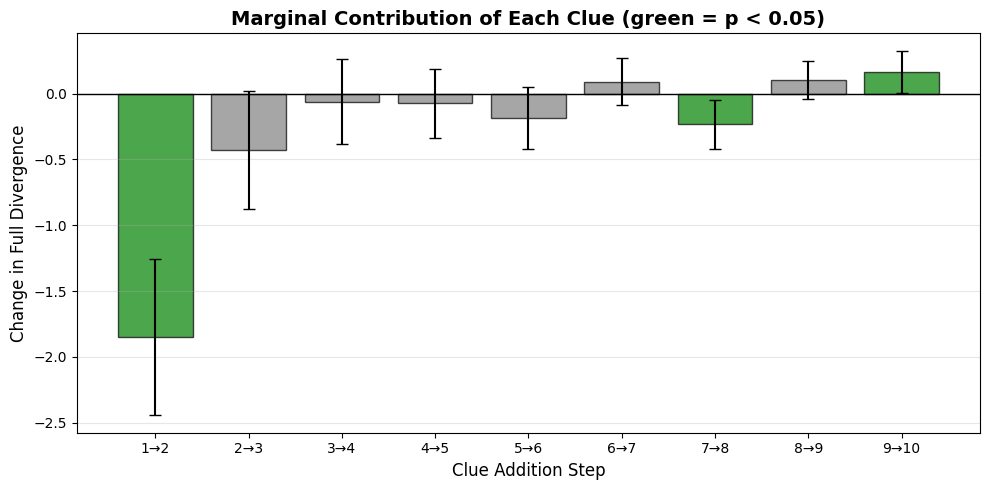

In [113]:
# Cell 50: Marginal Contribution Analysis

"""
Does each additional clue add meaningful information, or do later clues
cluster with earlier ones?
"""

print("=== Marginal Contribution Analysis ===\n")

# Pivot to get divergence at each n for each trial
traj_pivot = traj_df.pivot(index='trial_idx', columns='n_clues', values='full_divergence')

# Compute marginal change in divergence for each step
marginal_changes = pd.DataFrame()
for n in range(2, 11):
    marginal_changes[f"{n-1}_to_{n}"] = traj_pivot[n] - traj_pivot[n-1]

# Compute statistics for each marginal step
marginal_stats = marginal_changes.describe().T
marginal_stats["se"] = marginal_stats["std"] / np.sqrt(marginal_stats["count"])
marginal_stats["t_vs_zero"] = marginal_stats["mean"] / marginal_stats["se"]
marginal_stats["p_value"] = 2 * (1 - stats.t.cdf(abs(marginal_stats["t_vs_zero"]), df=marginal_stats["count"]-1))

print("Change in full divergence when adding each clue:")
print("-" * 70)
print(f"{'Step':>10} {'Mean Δ':>10} {'SD':>10} {'t':>10} {'p':>10} {'Sig':>6}")
print("-" * 70)

for step in marginal_stats.index:
    row = marginal_stats.loc[step]
    sig = "***" if row["p_value"] < 0.001 else "**" if row["p_value"] < 0.01 else "*" if row["p_value"] < 0.05 else ""
    print(f"{step:>10} {row['mean']:>+10.3f} {row['std']:>10.3f} {row['t_vs_zero']:>10.2f} {row['p_value']:>10.4f} {sig:>6}")

print()

# Identify where marginal contribution becomes non-significant
nonsig_steps = marginal_stats[marginal_stats["p_value"] > 0.05].index.tolist()
if len(nonsig_steps) > 0:
    print(f"Non-significant marginal contributions: {', '.join(nonsig_steps)}")
    first_nonsig = nonsig_steps[0]
    optimal_from_marginal = int(first_nonsig.split("_")[0])  # The "from" clue count
    print(f"  Interpretation: After {optimal_from_marginal} clues, additional clues may not add meaningful divergence.")
else:
    print("All marginal contributions are significant - each clue adds information.")
    optimal_from_marginal = 10

# Visualize marginal contributions
fig, ax = plt.subplots(figsize=(10, 5))

steps = [f"{i}→{i+1}" for i in range(1, 10)]
means = marginal_stats["mean"].values
errors = marginal_stats["se"].values * 1.96  # 95% CI

colors = ['green' if p < 0.05 else 'gray' for p in marginal_stats["p_value"]]
ax.bar(steps, means, yerr=errors, capsize=4, color=colors, alpha=0.7, edgecolor='black')
ax.axhline(0, color='black', linestyle='-', linewidth=1)

ax.set_xlabel('Clue Addition Step', fontsize=12)
ax.set_ylabel('Change in Full Divergence', fontsize=12)
ax.set_title('Marginal Contribution of Each Clue (green = p < 0.05)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('data/marginal_contributions.png', dpi=150, bbox_inches='tight')
plt.show()

=== Optimal Clue Count Determination ===

Note: Excluding n=1 (no clue-clue pairs, cannot measure divergence)

Weights: Gap=0.35, Proportion=0.3, Stability=0.2, Efficiency=0.15

Optimization Scores by Clue Count
  N      Gap     Prop     Stab      Eff  Composite   Full Div   Gap to DAT
-------------------------------------------------------------------------------------
  2    0.110    0.167    0.000    1.000      0.238       66.8         +7.3
  3    0.057    0.300    0.065    0.875      0.254       66.4         +7.7
  4    0.050    0.400    0.076    0.750      0.265       66.3         +7.8
  5    0.040    0.476    0.073    0.625      0.265       66.2         +7.9
  6    0.018    0.536    0.086    0.500      0.259       66.0         +8.1
  7    0.028    0.583    0.120    0.375      0.265       66.1         +8.0
  8    0.000    0.622    0.147    0.250      0.254       65.9         +8.2
  9    0.012    0.655    0.161    0.125      0.252       66.0         +8.1
 10    0.033    0.682    0.

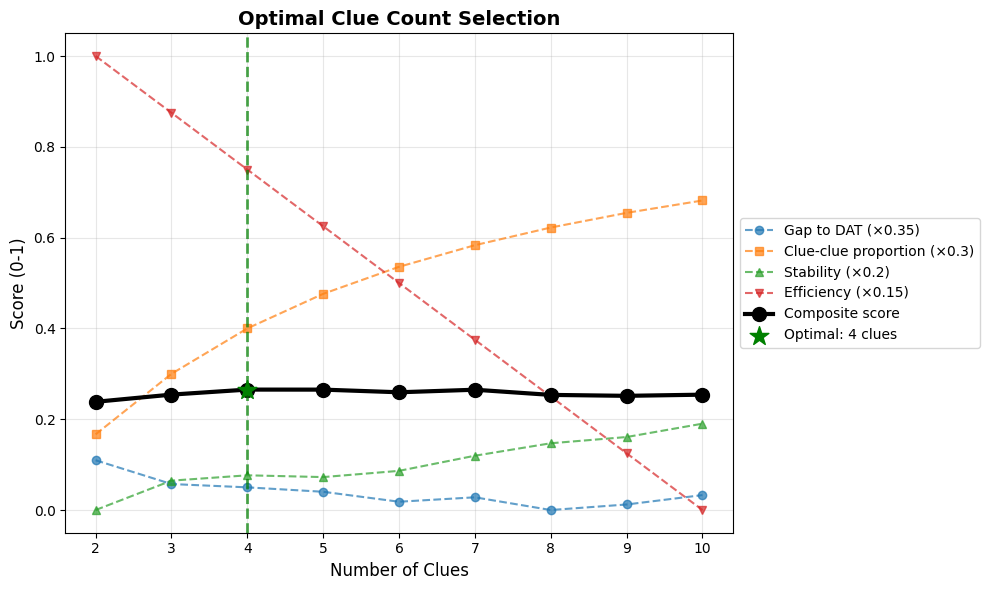

In [117]:
# Cell 51: Optimal Clue Count Determination

"""
Criteria for optimal clue count:
1. Minimize gap to DAT (construct validity)
2. Maximize clue-clue pair proportion (measurement purity)
3. Lower variance (measurement stability)
4. Fewer clues (efficiency/task burden)

We compute a composite score weighting these factors.
"""

print("=== Optimal Clue Count Determination ===\n")

# Build optimization dataframe
# IMPORTANT: Exclude n=1 because 1 clue has 0 clue-clue pairs
# and therefore cannot measure participant divergence
opt_df = trajectory_stats.loc[2:].copy()  # Start from 2 clues
opt_df["n_clues"] = opt_df.index

print("Note: Excluding n=1 (no clue-clue pairs, cannot measure divergence)\n")

# Criterion 1: Gap to DAT (lower is better, normalize to 0-1)
max_gap = opt_df["gap_to_dat"].abs().max()
opt_df["gap_score"] = 1 - (opt_df["gap_to_dat"].abs() / max_gap) if max_gap > 0 else 1

# Criterion 2: Clue-clue proportion (higher is better)
total_pairs = opt_df["n_full_pairs_first"]
clue_pairs = opt_df["n_clue_pairs_first"]
opt_df["proportion_score"] = clue_pairs / total_pairs

# Criterion 3: Variance (lower is better - more stable measurement)
max_std = opt_df["full_divergence_std"].max()
opt_df["stability_score"] = 1 - (opt_df["full_divergence_std"] / max_std) if max_std > 0 else 1

# Criterion 4: Efficiency (fewer clues is better, linear penalty)
# Scale from 2-10 instead of 1-10
opt_df["efficiency_score"] = 1 - (opt_df["n_clues"] - 2) / 8

# Adjustable weights
WEIGHT_GAP = 0.35
WEIGHT_PROPORTION = 0.30
WEIGHT_STABILITY = 0.20
WEIGHT_EFFICIENCY = 0.15

# Composite score
opt_df["composite_score"] = (
    WEIGHT_GAP * opt_df["gap_score"] +
    WEIGHT_PROPORTION * opt_df["proportion_score"] +
    WEIGHT_STABILITY * opt_df["stability_score"] +
    WEIGHT_EFFICIENCY * opt_df["efficiency_score"]
)

print(f"Weights: Gap={WEIGHT_GAP}, Proportion={WEIGHT_PROPORTION}, Stability={WEIGHT_STABILITY}, Efficiency={WEIGHT_EFFICIENCY}\n")

print("Optimization Scores by Clue Count")
print("=" * 85)
print(f"{'N':>3} {'Gap':>8} {'Prop':>8} {'Stab':>8} {'Eff':>8} {'Composite':>10} {'Full Div':>10} {'Gap to DAT':>12}")
print("-" * 85)

for n in range(2, 11):  # Start from 2 clues
    row = opt_df.loc[n]
    print(f"{n:>3} {row['gap_score']:>8.3f} {row['proportion_score']:>8.3f} {row['stability_score']:>8.3f} {row['efficiency_score']:>8.3f} {row['composite_score']:>10.3f} {row['full_divergence_mean']:>10.1f} {row['gap_to_dat']:>+12.1f}")

print()

# Find optimal
optimal_n = opt_df["composite_score"].idxmax()
print(f"OPTIMAL CLUE COUNT: {optimal_n}")
print()
print(f"At {optimal_n} clues:")
print(f"  - Full divergence: {opt_df.loc[optimal_n, 'full_divergence_mean']:.2f} (gap to DAT: {opt_df.loc[optimal_n, 'gap_to_dat']:+.2f})")
print(f"  - Total pairs: {int(opt_df.loc[optimal_n, 'n_full_pairs_first'])}")
print(f"  - Clue-clue pairs: {int(opt_df.loc[optimal_n, 'n_clue_pairs_first'])} ({opt_df.loc[optimal_n, 'proportion_score']*100:.1f}% of total)")
print(f"  - Score SD: {opt_df.loc[optimal_n, 'full_divergence_std']:.2f}")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(opt_df["n_clues"], opt_df["gap_score"], 'o--', label=f'Gap to DAT (×{WEIGHT_GAP})', alpha=0.7)
ax.plot(opt_df["n_clues"], opt_df["proportion_score"], 's--', label=f'Clue-clue proportion (×{WEIGHT_PROPORTION})', alpha=0.7)
ax.plot(opt_df["n_clues"], opt_df["stability_score"], '^--', label=f'Stability (×{WEIGHT_STABILITY})', alpha=0.7)
ax.plot(opt_df["n_clues"], opt_df["efficiency_score"], 'v--', label=f'Efficiency (×{WEIGHT_EFFICIENCY})', alpha=0.7)

ax.plot(opt_df["n_clues"], opt_df["composite_score"], 'o-', color='black', linewidth=3, markersize=10, label='Composite score')

ax.axvline(optimal_n, color='green', linestyle='--', linewidth=2, alpha=0.7)
ax.scatter([optimal_n], [opt_df.loc[optimal_n, "composite_score"]], 
           color='green', s=200, zorder=5, marker='*', label=f'Optimal: {optimal_n} clues')

ax.set_xlabel('Number of Clues', fontsize=12)
ax.set_ylabel('Score (0-1)', fontsize=12)
ax.set_title('Optimal Clue Count Selection', fontsize=14, fontweight='bold')
ax.set_xticks(range(2, 11))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('data/optimal_clue_count.png', dpi=150, bbox_inches='tight')
plt.show()

In [118]:
# Cell 52: Clue Count Optimization Summary and Export

print("=" * 70)
print("CLUE COUNT OPTIMIZATION: SUMMARY")
print("=" * 70)
print()

print("1. TRAJECTORY FINDINGS")
print("-" * 40)
print(f"   As clue count increases from 1→10:")
print(f"   - Full divergence: {trajectory_stats.loc[1, 'full_divergence_mean']:.1f} → {trajectory_stats.loc[10, 'full_divergence_mean']:.1f}")
print(f"   - Gap to DAT: {trajectory_stats.loc[1, 'gap_to_dat']:+.1f} → {trajectory_stats.loc[10, 'gap_to_dat']:+.1f}")
print(f"   - Clue-clue proportion: 0% → {(45/66)*100:.1f}%")
print()

print("2. OPTIMAL CLUE COUNT")
print("-" * 40)
print(f"   Recommended: {optimal_n} clues")
print(f"   Rationale:")
print(f"   - Balances construct validity (gap to DAT)")
print(f"   - Maximizes participant-generated pair proportion")
print(f"   - Maintains measurement stability")
print(f"   - Avoids excessive task burden")
print()

print("3. CALIBRATION AT OPTIMAL N")
print("-" * 40)
optimal_gap = opt_df.loc[optimal_n, 'gap_to_dat']
print(f"   Calibration adjustment: {optimal_gap:+.2f} points")
print(f"   Example: INS-001.2 score of 70 → DAT-equivalent of {70 + optimal_gap:.0f}")
print()

print("4. IMPLEMENTATION RECOMMENDATION")
print("-" * 40)
if optimal_n <= 5:
    print(f"   Use {optimal_n} clues in production INS-001.2")
    print(f"   This maintains reasonable task length while optimizing construct validity.")
elif optimal_n <= 7:
    print(f"   {optimal_n} clues provides best construct validity but increases task burden.")
    print(f"   Consider whether your population can sustain this length.")
else:
    print(f"   {optimal_n} clues may be too burdensome for most participants.")
    print(f"   Consider accepting a larger calibration gap with fewer clues.")
print()

# Save optimal parameters
optimal_params = {
    "timestamp": datetime.now().isoformat(),
    "optimal_n_clues": int(optimal_n),
    "calibration_adjustment": float(optimal_gap),
    "full_divergence_mean": float(opt_df.loc[optimal_n, 'full_divergence_mean']),
    "full_divergence_std": float(opt_df.loc[optimal_n, 'full_divergence_std']),
    "clue_clue_proportion": float(opt_df.loc[optimal_n, 'proportion_score']),
    "n_trials_analyzed": int(traj_df['trial_idx'].nunique()),
    "dat_reference": {
        "mean": float(DAT_MEAN),
        "sd": float(DAT_SD)
    },
    "weights_used": {
        "gap": WEIGHT_GAP,
        "proportion": WEIGHT_PROPORTION,
        "stability": WEIGHT_STABILITY,
        "efficiency": WEIGHT_EFFICIENCY
    },
    "trajectory_summary": {
        n: {
            "full_divergence_mean": float(trajectory_stats.loc[n, 'full_divergence_mean']),
            "full_divergence_std": float(trajectory_stats.loc[n, 'full_divergence_std']),
            "gap_to_dat": float(trajectory_stats.loc[n, 'gap_to_dat']),
            "n_pairs": int(trajectory_stats.loc[n, 'n_full_pairs_first']),
            "clue_clue_pairs": int(trajectory_stats.loc[n, 'n_clue_pairs_first'])
        }
        for n in range(1, 11)
    }
}

params_file = Path('data/optimal_clue_count_params.json')
with open(params_file, 'w') as f:
    json.dump(optimal_params, f, indent=2)

print("5. EXPORT")
print("-" * 40)
print(f"   Parameters saved to: {params_file}")
print()
print("=" * 70)
print("ANALYSIS COMPLETE")
print("=" * 70)

CLUE COUNT OPTIMIZATION: SUMMARY

1. TRAJECTORY FINDINGS
----------------------------------------
   As clue count increases from 1→10:
   - Full divergence: 68.6 → 66.2
   - Gap to DAT: +5.5 → +7.9
   - Clue-clue proportion: 0% → 68.2%

2. OPTIMAL CLUE COUNT
----------------------------------------
   Recommended: 4 clues
   Rationale:
   - Balances construct validity (gap to DAT)
   - Maximizes participant-generated pair proportion
   - Maintains measurement stability
   - Avoids excessive task burden

3. CALIBRATION AT OPTIMAL N
----------------------------------------
   Calibration adjustment: +7.80 points
   Example: INS-001.2 score of 70 → DAT-equivalent of 78

4. IMPLEMENTATION RECOMMENDATION
----------------------------------------
   Use 4 clues in production INS-001.2
   This maintains reasonable task length while optimizing construct validity.

5. EXPORT
----------------------------------------
   Parameters saved to: data/optimal_clue_count_params.json

ANALYSIS COMPLETE


## Part 14: Relevance Metric Characterization

### Overview
Characterize the relevance metric behavior using Haiku as the reference for "optimal bridging."

**Relevance Formula** (from `scoring.py`):
```python
for clue in clue_embeddings:
    sim_a = cosine_similarity(clue, anchor_embedding)
    sim_t = cosine_similarity(clue, target_embedding)
    relevance_scores.append(min(sim_a, sim_t))  # Must bridge BOTH

overall_relevance = mean(relevance_scores)
```

### Current Interpretation Thresholds
- < 0.15 — Noise/unrelated
- 0.15–0.30 — Weak (tangential)
- 0.30–0.45 — Moderate (connected)
- > 0.45 — Strong (core neighborhood)

### Analysis Goals
1. **Haiku baseline** — Establish reference distribution
2. **Clue count trajectory** — Does relevance degrade with more clues?
3. **Clue position effects** — Are later clues less relevant?
4. **Pair difficulty moderation** — Does A-T distance affect achievable relevance?
5. **Relevance-divergence tradeoff** — Quantify the fundamental tension
6. **Threshold validation** — Are current thresholds appropriate?

In [120]:
# Cell 53: Compute Relevance Metrics

"""
Define relevance computation functions and compute for all trials.
"""

def compute_clue_relevance(
    clue_emb: list[float],
    anchor_emb: list[float],
    target_emb: list[float]
) -> dict:
    """
    Compute relevance for a single clue.
    
    Returns:
        - relevance: min(sim_anchor, sim_target)
        - sim_anchor: similarity to anchor
        - sim_target: similarity to target
        - closer_to: which endpoint the clue is closer to
        - balance: how evenly the clue bridges both endpoints
    """
    sim_a = cosine_similarity(clue_emb, anchor_emb)
    sim_t = cosine_similarity(clue_emb, target_emb)
    
    return {
        "relevance": min(sim_a, sim_t),
        "sim_anchor": sim_a,
        "sim_target": sim_t,
        "closer_to": "anchor" if sim_a > sim_t else "target",
        "balance": min(sim_a, sim_t) / max(sim_a, sim_t) if max(sim_a, sim_t) > 0 else 0
    }


def compute_trial_relevance(
    anchor_emb: list[float],
    target_emb: list[float],
    clue_embs: list[list[float]],
    n_clues: int = None
) -> dict:
    """
    Compute relevance metrics for a trial.
    """
    if n_clues is None:
        n_clues = len(clue_embs)
    
    clues_subset = clue_embs[:n_clues]
    
    clue_details = []
    for i, clue_emb in enumerate(clues_subset):
        detail = compute_clue_relevance(clue_emb, anchor_emb, target_emb)
        detail["clue_position"] = i + 1
        clue_details.append(detail)
    
    relevances = [d["relevance"] for d in clue_details]
    
    return {
        "overall_relevance": np.mean(relevances),
        "relevance_std": np.std(relevances),
        "relevance_min": np.min(relevances),
        "relevance_max": np.max(relevances),
        "individual_relevances": relevances,
        "clue_details": clue_details,
        "n_clues": n_clues
    }


# Compute relevance for all valid trials
print("=== Computing Relevance Metrics ===\n")

relevance_data = []
clue_level_data = []
valid_trials_processed = 0

for trial_idx, trial in enumerate(bridging_results):
    if not trial.valid or len(trial.clues) < 10:
        continue
    
    # Get embeddings for all words
    all_words = [trial.anchor, trial.target] + trial.clues[:10]
    all_embs = get_openai_embeddings_sync(all_words)
    
    if not all_embs or len(all_embs) < 12:
        continue
    
    anchor_emb = all_embs[0]
    target_emb = all_embs[1]
    clue_embs = all_embs[2:]
    
    # Compute anchor-target distance for this trial
    at_distance = 1 - cosine_similarity(anchor_emb, target_emb)
    
    # Compute relevance at each clue count (1-10)
    for n in range(1, 11):
        result = compute_trial_relevance(anchor_emb, target_emb, clue_embs, n)
        result["trial_idx"] = trial_idx
        result["anchor"] = trial.anchor
        result["target"] = trial.target
        result["at_distance"] = at_distance
        relevance_data.append(result)
    
    # Collect clue-level data for position analysis
    full_result = compute_trial_relevance(anchor_emb, target_emb, clue_embs, 10)
    for detail in full_result["clue_details"]:
        detail["trial_idx"] = trial_idx
        detail["anchor"] = trial.anchor
        detail["target"] = trial.target
        detail["at_distance"] = at_distance
        clue_level_data.append(detail)
    
    valid_trials_processed += 1
    if valid_trials_processed % 20 == 0:
        print(f"  Processed {valid_trials_processed} trials...")

rel_df = pd.DataFrame(relevance_data)
clue_df = pd.DataFrame(clue_level_data)

print(f"\nComputed relevance for {rel_df['trial_idx'].nunique()} trials")
print(f"Collected {len(clue_df)} clue-level observations")
print(f"Relevance data points: {len(rel_df)} (trials × clue counts)")

=== Computing Relevance Metrics ===

  Processed 20 trials...
  Processed 40 trials...
  Processed 60 trials...
  Processed 80 trials...
  Processed 100 trials...

Computed relevance for 114 trials
Collected 1140 clue-level observations
Relevance data points: 1140 (trials × clue counts)


In [121]:
# Cell 54: Haiku Relevance Baseline

"""
Establish the reference distribution for an "optimal" bridger.
Use optimal_n from Part 13 (or default to 5) as reference clue count.
"""

print("=== Haiku Relevance Baseline ===\n")

# Use optimal clue count from Part 13, or default to 5
REFERENCE_N_CLUES = optimal_n if 'optimal_n' in dir() else 5
print(f"Reference clue count: {REFERENCE_N_CLUES}\n")

baseline_df = rel_df[rel_df["n_clues"] == REFERENCE_N_CLUES].copy()

haiku_relevance_mean = baseline_df["overall_relevance"].mean()
haiku_relevance_std = baseline_df["overall_relevance"].std()
haiku_relevance_median = baseline_df["overall_relevance"].median()

print("=" * 60)
print(f"HAIKU RELEVANCE BASELINE ({REFERENCE_N_CLUES} clues)")
print("=" * 60)
print(f"  Mean:   {haiku_relevance_mean:.4f}")
print(f"  SD:     {haiku_relevance_std:.4f}")
print(f"  Median: {haiku_relevance_median:.4f}")
print(f"  Range:  {baseline_df['overall_relevance'].min():.4f} - {baseline_df['overall_relevance'].max():.4f}")
print()

# Distribution percentiles
percentiles = [5, 10, 25, 50, 75, 90, 95]
print("Percentile Distribution:")
haiku_rel_percentiles = {}
for p in percentiles:
    val = np.percentile(baseline_df["overall_relevance"], p)
    haiku_rel_percentiles[p] = val
    print(f"  {p:2d}th percentile: {val:.4f}")
print()

# Compare to current thresholds
print("Current Threshold Assessment:")
noise_count = (baseline_df['overall_relevance'] < 0.15).sum()
weak_count = ((baseline_df['overall_relevance'] >= 0.15) & (baseline_df['overall_relevance'] < 0.30)).sum()
moderate_count = ((baseline_df['overall_relevance'] >= 0.30) & (baseline_df['overall_relevance'] < 0.45)).sum()
strong_count = (baseline_df['overall_relevance'] >= 0.45).sum()
total = len(baseline_df)

print(f"  Noise (<0.15):      {noise_count:3d} trials ({noise_count/total*100:5.1f}%)")
print(f"  Weak (0.15-0.30):   {weak_count:3d} trials ({weak_count/total*100:5.1f}%)")
print(f"  Moderate (0.30-0.45): {moderate_count:3d} trials ({moderate_count/total*100:5.1f}%)")
print(f"  Strong (>0.45):     {strong_count:3d} trials ({strong_count/total*100:5.1f}%)")
print()

# Interpretation
if haiku_relevance_mean > 0.45:
    print("Note: Haiku mean is in 'Strong' range - current thresholds may be too lenient.")
elif haiku_relevance_mean > 0.30:
    print("Note: Haiku mean is in 'Moderate' range - thresholds seem reasonable.")
elif haiku_relevance_mean > 0.15:
    print("Note: Haiku mean is in 'Weak' range - current thresholds may be too strict.")
else:
    print("Warning: Haiku mean is in 'Noise' range - something may be wrong.")

=== Haiku Relevance Baseline ===

Reference clue count: 4

HAIKU RELEVANCE BASELINE (4 clues)
  Mean:   0.2761
  SD:     0.0481
  Median: 0.2645
  Range:  0.1567 - 0.3836

Percentile Distribution:
   5th percentile: 0.2128
  10th percentile: 0.2258
  25th percentile: 0.2487
  50th percentile: 0.2645
  75th percentile: 0.3108
  90th percentile: 0.3330
  95th percentile: 0.3669

Current Threshold Assessment:
  Noise (<0.15):        0 trials (  0.0%)
  Weak (0.15-0.30):    79 trials ( 69.3%)
  Moderate (0.30-0.45):  35 trials ( 30.7%)
  Strong (>0.45):       0 trials (  0.0%)

Note: Haiku mean is in 'Weak' range - current thresholds may be too strict.


In [122]:
# Cell 55: Relevance vs Clue Count Trajectory

"""
Does relevance degrade as Haiku generates more clues?
"""

print("=== Relevance vs Clue Count Trajectory ===\n")

# Aggregate by clue count
rel_trajectory = rel_df.groupby("n_clues").agg({
    "overall_relevance": ["mean", "std", "min", "max"],
    "relevance_min": "mean",  # Mean of per-trial minimums
    "relevance_max": "mean",  # Mean of per-trial maximums
    "trial_idx": "count"
}).round(4)

rel_trajectory.columns = ['_'.join(col).strip() for col in rel_trajectory.columns]
rel_trajectory = rel_trajectory.rename(columns={"trial_idx_count": "n_trials"})

print("Relevance by Clue Count")
print("=" * 80)
print(f"{'N':>3} {'Mean':>10} {'SD':>10} {'Min':>10} {'Max':>10} {'Trials':>10}")
print("-" * 80)
for n in range(1, 11):
    row = rel_trajectory.loc[n]
    print(f"{n:>3} {row['overall_relevance_mean']:>10.4f} {row['overall_relevance_std']:>10.4f} "
          f"{row['overall_relevance_min']:>10.4f} {row['overall_relevance_max']:>10.4f} "
          f"{int(row['n_trials']):>10}")

# Test for linear trend
n_clues_arr = rel_df["n_clues"].values
relevance_arr = rel_df["overall_relevance"].values
slope_rel, intercept_rel, r_rel, p_rel, std_err_rel = stats.linregress(n_clues_arr, relevance_arr)

print()
print(f"Linear trend: slope = {slope_rel:.6f} per clue")
print(f"              r = {r_rel:.4f}, p = {p_rel:.4f}")

if p_rel < 0.05:
    if slope_rel < 0:
        print("  ⚠ Significant negative trend: relevance DECREASES with more clues")
        print(f"    Each additional clue reduces relevance by ~{abs(slope_rel):.4f}")
    else:
        print("  ✓ Significant positive trend: relevance INCREASES with more clues")
else:
    print("  ✓ No significant trend: relevance stable across clue counts")

# Store for later
rel_trend_results = {
    "slope": slope_rel,
    "r": r_rel,
    "p": p_rel,
    "significant": p_rel < 0.05
}

=== Relevance vs Clue Count Trajectory ===

Relevance by Clue Count
  N       Mean         SD        Min        Max     Trials
--------------------------------------------------------------------------------
  1     0.2758     0.0665     0.1474     0.4312        114
  2     0.2807     0.0527     0.1608     0.4127        114
  3     0.2773     0.0482     0.1609     0.3962        114
  4     0.2761     0.0481     0.1567     0.3836        114
  5     0.2744     0.0457     0.1625     0.3796        114
  6     0.2735     0.0437     0.1673     0.3668        114
  7     0.2724     0.0423     0.1669     0.3649        114
  8     0.2730     0.0417     0.1727     0.3589        114
  9     0.2718     0.0402     0.1799     0.3544        114
 10     0.2701     0.0400     0.1761     0.3538        114

Linear trend: slope = -0.000892 per clue
              r = -0.0540, p = 0.0681
  ✓ No significant trend: relevance stable across clue counts


In [123]:
# Cell 56: Clue Position Effects

"""
Are later clues less relevant than earlier ones?
This tests whether Haiku "runs out" of good bridging concepts.
"""

print("=== Clue Position Effects ===\n")

# Aggregate by clue position
position_stats = clue_df.groupby("clue_position").agg({
    "relevance": ["mean", "std", "count"],
    "sim_anchor": "mean",
    "sim_target": "mean",
    "balance": "mean"
}).round(4)

position_stats.columns = ['_'.join(col).strip() for col in position_stats.columns]

print("Relevance by Clue Position")
print("=" * 85)
print(f"{'Pos':>4} {'Relevance':>10} {'SD':>8} {'Sim(A)':>10} {'Sim(T)':>10} {'Balance':>10} {'N':>8}")
print("-" * 85)
for pos in range(1, 11):
    row = position_stats.loc[pos]
    print(f"{pos:>4} {row['relevance_mean']:>10.4f} {row['relevance_std']:>8.4f} "
          f"{row['sim_anchor_mean']:>10.4f} {row['sim_target_mean']:>10.4f} "
          f"{row['balance_mean']:>10.4f} {int(row['relevance_count']):>8}")

# Test for position effect (linear regression)
position_arr = clue_df["clue_position"].values
relevance_arr = clue_df["relevance"].values
slope_pos, intercept_pos, r_pos, p_pos, std_err_pos = stats.linregress(position_arr, relevance_arr)

print()
print(f"Position effect: {slope_pos:.5f} per position")
print(f"                 r = {r_pos:.4f}, p = {p_pos:.4f}")

# ANOVA across positions
position_groups = [clue_df[clue_df["clue_position"] == p]["relevance"].values for p in range(1, 11)]
f_stat_pos, anova_p_pos = stats.f_oneway(*position_groups)
print(f"ANOVA: F = {f_stat_pos:.2f}, p = {anova_p_pos:.4f}")

if anova_p_pos < 0.05:
    print("  ⚠ Significant position effect detected")
    # Post-hoc: compare first vs last
    t_stat_fl, t_p_fl = stats.ttest_ind(position_groups[0], position_groups[-1])
    print(f"  Clue 1 vs Clue 10: t = {t_stat_fl:.2f}, p = {t_p_fl:.4f}")
    print(f"  Clue 1 mean: {position_groups[0].mean():.4f}")
    print(f"  Clue 10 mean: {position_groups[-1].mean():.4f}")
    print(f"  Difference: {position_groups[0].mean() - position_groups[-1].mean():.4f}")
else:
    print("  ✓ No significant position effect")
    print("    All clue positions have similar relevance.")

# Store for later
position_effect_results = {
    "slope": slope_pos,
    "r": r_pos,
    "p_linear": p_pos,
    "f_anova": f_stat_pos,
    "p_anova": anova_p_pos,
    "significant": anova_p_pos < 0.05
}

=== Clue Position Effects ===

Relevance by Clue Position
 Pos  Relevance       SD     Sim(A)     Sim(T)    Balance        N
-------------------------------------------------------------------------------------
   1     0.2758   0.0665     0.3643     0.3338     0.6849      114
   2     0.2855   0.0543     0.3193     0.3487     0.7613      114
   3     0.2707   0.0557     0.3170     0.3360     0.7324      114
   4     0.2722   0.0627     0.3203     0.3205     0.7572      114
   5     0.2677   0.0592     0.3135     0.3210     0.7478      114
   6     0.2693   0.0642     0.3069     0.3696     0.6912      114
   7     0.2656   0.0554     0.3016     0.3296     0.7442      114
   8     0.2769   0.0633     0.3111     0.3567     0.7248      114
   9     0.2622   0.0545     0.3085     0.3248     0.7259      114
  10     0.2556   0.0657     0.2984     0.3309     0.7037      114

Position effect: -0.00202 per position
                 r = -0.0956, p = 0.0012
ANOVA: F = 2.16, p = 0.0224
  ⚠ Signif

In [124]:
# Cell 57: Pair Difficulty Effect on Relevance

"""
Does anchor-target distance affect achievable relevance?

Hypothesis: Harder pairs (more distant A-T) should have LOWER relevance
because the "bridging region" is smaller/nonexistent for very distant concepts.
"""

print("=== Pair Difficulty Effect on Relevance ===\n")

# Use reference clue count
difficulty_df = rel_df[rel_df["n_clues"] == REFERENCE_N_CLUES].copy()

# Correlation
r_difficulty, p_difficulty = stats.pearsonr(
    difficulty_df["at_distance"], 
    difficulty_df["overall_relevance"]
)

print(f"Correlation (A-T distance vs relevance): r = {r_difficulty:.4f}, p = {p_difficulty:.4f}")

if p_difficulty < 0.05:
    if r_difficulty < 0:
        print("  ⚠ Confirmed: Harder pairs have LOWER relevance")
        print("    The bridging region shrinks as endpoints diverge.")
    else:
        print("  ? Unexpected: Harder pairs have HIGHER relevance")
else:
    print("  ✓ No significant effect: relevance independent of pair difficulty")
    print("    Haiku can achieve similar relevance regardless of pair difficulty.")

# Tercile analysis
difficulty_df["difficulty_tercile"] = pd.qcut(
    difficulty_df["at_distance"], 
    q=3, 
    labels=["Easy", "Medium", "Hard"]
)

print()
print("Relevance by Pair Difficulty Tercile:")
print("-" * 60)

for tercile in ["Easy", "Medium", "Hard"]:
    tercile_data = difficulty_df[difficulty_df["difficulty_tercile"] == tercile]
    rel_mean = tercile_data["overall_relevance"].mean()
    rel_std = tercile_data["overall_relevance"].std()
    at_mean = tercile_data["at_distance"].mean()
    n = len(tercile_data)
    print(f"  {tercile:>8}: relevance = {rel_mean:.4f} (SD={rel_std:.4f}), A-T dist = {at_mean:.3f}, n={n}")

# ANOVA
easy_rel = difficulty_df[difficulty_df["difficulty_tercile"] == "Easy"]["overall_relevance"]
medium_rel = difficulty_df[difficulty_df["difficulty_tercile"] == "Medium"]["overall_relevance"]
hard_rel = difficulty_df[difficulty_df["difficulty_tercile"] == "Hard"]["overall_relevance"]

f_stat_diff, anova_p_diff = stats.f_oneway(easy_rel, medium_rel, hard_rel)
print()
print(f"ANOVA: F = {f_stat_diff:.2f}, p = {anova_p_diff:.4f}")

if anova_p_diff < 0.05:
    print("  ⚠ Significant difference across difficulty terciles")
    # Effect size
    easy_mean = easy_rel.mean()
    hard_mean = hard_rel.mean()
    print(f"  Easy vs Hard difference: {easy_mean - hard_mean:.4f}")
else:
    print("  ✓ No significant difference across difficulty terciles")

# Store for later
difficulty_effect_results = {
    "r": r_difficulty,
    "p": p_difficulty,
    "f_anova": f_stat_diff,
    "p_anova": anova_p_diff,
    "tercile_means": {
        "easy": float(easy_rel.mean()),
        "medium": float(medium_rel.mean()),
        "hard": float(hard_rel.mean())
    }
}

=== Pair Difficulty Effect on Relevance ===

Correlation (A-T distance vs relevance): r = -0.4055, p = 0.0000
  ⚠ Confirmed: Harder pairs have LOWER relevance
    The bridging region shrinks as endpoints diverge.

Relevance by Pair Difficulty Tercile:
------------------------------------------------------------
      Easy: relevance = 0.2900 (SD=0.0417), A-T dist = 0.696, n=38
    Medium: relevance = 0.2922 (SD=0.0473), A-T dist = 0.756, n=39
      Hard: relevance = 0.2447 (SD=0.0404), A-T dist = 0.814, n=37

ANOVA: F = 14.39, p = 0.0000
  ⚠ Significant difference across difficulty terciles
  Easy vs Hard difference: 0.0453


=== Relevance-Divergence Tradeoff ===

Trial-Level Correlation (Relevance vs Clue-Only Divergence)
  r = -0.6085, p = 0.0000

  ⚠ Strong tradeoff detected
    Higher relevance → Lower divergence
    Participants must balance these competing objectives.

Clue-Level Correlation (Relevance vs Clue-Prompt Distance)
  r = -0.7436, p = 0.0000
  (Negative r means: more relevant clues are closer to prompts, as expected)


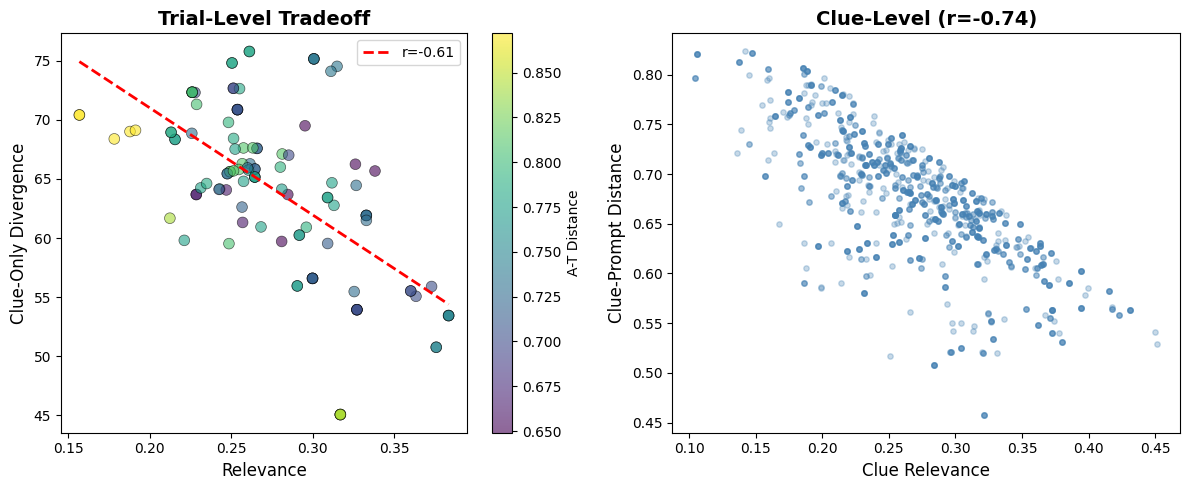

In [125]:
# Cell 58: Relevance-Divergence Tradeoff

"""
Quantify the fundamental tension between relevance and divergence.

If there's a tradeoff, participants must choose between:
- High relevance (clues close to endpoints) → Low divergence
- High divergence (clues spread out) → Low relevance
"""

print("=== Relevance-Divergence Tradeoff ===\n")

# Merge relevance and divergence data at trial level
# Use clue-only divergence for fair comparison (both measure participant-generated content)
div_at_ref = traj_df[traj_df["n_clues"] == REFERENCE_N_CLUES][["trial_idx", "clue_only_divergence"]].copy()
rel_at_ref = rel_df[rel_df["n_clues"] == REFERENCE_N_CLUES][["trial_idx", "overall_relevance", "at_distance"]].copy()

tradeoff_df = rel_at_ref.merge(div_at_ref, on="trial_idx")

# Trial-level correlation
r_tradeoff, p_tradeoff = stats.pearsonr(
    tradeoff_df["overall_relevance"],
    tradeoff_df["clue_only_divergence"]
)

print(f"Trial-Level Correlation (Relevance vs Clue-Only Divergence)")
print(f"  r = {r_tradeoff:.4f}, p = {p_tradeoff:.4f}")
print()

if r_tradeoff < -0.3 and p_tradeoff < 0.05:
    print("  ⚠ Strong tradeoff detected")
    print("    Higher relevance → Lower divergence")
    print("    Participants must balance these competing objectives.")
elif r_tradeoff < 0 and p_tradeoff < 0.05:
    print("  Moderate tradeoff detected")
    print("    Some tension between relevance and divergence.")
elif r_tradeoff > 0 and p_tradeoff < 0.05:
    print("  ? Positive relationship: both can be optimized simultaneously")
    print("    This suggests no fundamental tradeoff.")
else:
    print("  ✓ No significant tradeoff")
    print("    Relevance and divergence appear independent.")

# Clue-level analysis
# Clue-prompt distance as proxy for divergence contribution
clue_df_analysis = clue_df.copy()
clue_df_analysis["clue_prompt_distance"] = 1 - (clue_df_analysis["sim_anchor"] + clue_df_analysis["sim_target"]) / 2

r_clue_level, p_clue_level = stats.pearsonr(
    clue_df_analysis["relevance"],
    clue_df_analysis["clue_prompt_distance"]
)

print()
print(f"Clue-Level Correlation (Relevance vs Clue-Prompt Distance)")
print(f"  r = {r_clue_level:.4f}, p = {p_clue_level:.4f}")
print("  (Negative r means: more relevant clues are closer to prompts, as expected)")

# Visualize the tradeoff
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Trial-level
ax1 = axes[0]
scatter1 = ax1.scatter(tradeoff_df["overall_relevance"], tradeoff_df["clue_only_divergence"], 
            alpha=0.6, c=tradeoff_df["at_distance"], cmap='viridis', 
            edgecolor='k', linewidth=0.5, s=60)

z = np.polyfit(tradeoff_df["overall_relevance"], tradeoff_df["clue_only_divergence"], 1)
p_line = np.poly1d(z)
x_line = np.linspace(tradeoff_df["overall_relevance"].min(), tradeoff_df["overall_relevance"].max(), 100)
ax1.plot(x_line, p_line(x_line), 'r--', linewidth=2, label=f'r={r_tradeoff:.2f}')

ax1.set_xlabel('Relevance', fontsize=12)
ax1.set_ylabel('Clue-Only Divergence', fontsize=12)
ax1.set_title('Trial-Level Tradeoff', fontsize=14, fontweight='bold')
ax1.legend()
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('A-T Distance')

# Clue-level
ax2 = axes[1]
ax2.scatter(clue_df_analysis["relevance"], clue_df_analysis["clue_prompt_distance"],
            alpha=0.3, s=15, c='steelblue')
ax2.set_xlabel('Clue Relevance', fontsize=12)
ax2.set_ylabel('Clue-Prompt Distance', fontsize=12)
ax2.set_title(f'Clue-Level (r={r_clue_level:.2f})', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('data/relevance_divergence_tradeoff.png', dpi=150, bbox_inches='tight')
plt.show()

# Store for later
tradeoff_results = {
    "r_trial_level": r_tradeoff,
    "p_trial_level": p_tradeoff,
    "r_clue_level": r_clue_level,
    "p_clue_level": p_clue_level,
    "has_tradeoff": r_tradeoff < -0.2 and p_tradeoff < 0.05
}

In [126]:
# Cell 59: Threshold Validation and Revision

"""
Are current thresholds appropriate given Haiku baseline?

Current thresholds (from scoring.py):
- < 0.15 — Noise/unrelated
- 0.15–0.30 — Weak (tangential)
- 0.30–0.45 — Moderate (connected)
- > 0.45 — Strong (core neighborhood)

We'll compare these to Haiku's distribution and propose revisions if needed.
"""

print("=== Threshold Validation ===\n")

# Current thresholds
current_thresholds = {
    "Noise": (0, 0.15),
    "Weak": (0.15, 0.30),
    "Moderate": (0.30, 0.45),
    "Strong": (0.45, 1.0)
}

# Haiku distribution
haiku_rel = baseline_df["overall_relevance"]

print("Current Thresholds vs Haiku Distribution:")
print("-" * 60)
print(f"{'Category':>12} {'Range':>15} {'Count':>8} {'Percent':>10}")
print("-" * 60)

for label, (low, high) in current_thresholds.items():
    count = ((haiku_rel >= low) & (haiku_rel < high)).sum()
    pct = count / len(haiku_rel) * 100
    print(f"{label:>12} {f'{low:.2f}-{high:.2f}':>15} {count:>8} {pct:>9.1f}%")

print()

# Compute Haiku percentiles for proposed thresholds
p5 = np.percentile(haiku_rel, 5)
p10 = np.percentile(haiku_rel, 10)
p25 = np.percentile(haiku_rel, 25)
p50 = np.percentile(haiku_rel, 50)
p75 = np.percentile(haiku_rel, 75)
p90 = np.percentile(haiku_rel, 90)
p95 = np.percentile(haiku_rel, 95)

print("Haiku-Based Threshold Proposal:")
print("-" * 60)
print("If Haiku represents 'optimal bridging', human scores can be interpreted as:")
print()

proposed_thresholds = {
    "Poor (< Haiku 10th)": (0, p10),
    "Below Average (10-25th)": (p10, p25),
    "Average (25-75th)": (p25, p75),
    "Above Average (75-90th)": (p75, p90),
    "Excellent (> 90th)": (p90, 1.0)
}

for label, (low, high) in proposed_thresholds.items():
    print(f"  {label:>30}: {low:.4f} - {high:.4f}")

print()
print("Comparison:")
print("-" * 60)
print(f"  Current 'Noise' threshold:    < 0.15")
print(f"  Haiku 10th percentile:        {p10:.4f}")
print(f"  Recommendation: {'Keep' if abs(p10 - 0.15) < 0.05 else 'Revise'} noise threshold")
print()
print(f"  Current 'Moderate' threshold: 0.30")
print(f"  Haiku 50th percentile:        {p50:.4f}")
print(f"  Recommendation: {'Aligned' if abs(p50 - 0.30) < 0.05 else 'Consider revision'}")
print()
print(f"  Current 'Strong' threshold:   0.45")
print(f"  Haiku 90th percentile:        {p90:.4f}")
print(f"  Recommendation: {'Aligned' if abs(p90 - 0.45) < 0.05 else 'Consider revision'}")

# Final recommendation
print()
print("=" * 60)
print("RECOMMENDATION:")
if haiku_relevance_mean > 0.45:
    print("  Current thresholds are TOO LENIENT.")
    print("  Most Haiku trials exceed 'Strong' threshold.")
    print("  Consider raising all thresholds.")
elif haiku_relevance_mean < 0.15:
    print("  WARNING: Haiku mean below noise threshold!")
    print("  Either thresholds are too strict or there's a calculation issue.")
elif haiku_relevance_mean < 0.30:
    print("  Current thresholds may be TOO STRICT.")
    print("  Haiku (optimal bridger) averages in 'Weak' range.")
    print("  Consider lowering thresholds or using percentile-based interpretation.")
else:
    print("  Current thresholds are ROUGHLY ALIGNED with Haiku baseline.")
    print("  Haiku mean falls in 'Moderate' range as expected.")

# Store proposed thresholds
proposed_threshold_values = {
    "poor": float(p10),
    "below_average": float(p25),
    "average_low": float(p25),
    "average_high": float(p75),
    "above_average": float(p75),
    "excellent": float(p90)
}

=== Threshold Validation ===

Current Thresholds vs Haiku Distribution:
------------------------------------------------------------
    Category           Range    Count    Percent
------------------------------------------------------------
       Noise       0.00-0.15        0       0.0%
        Weak       0.15-0.30       79      69.3%
    Moderate       0.30-0.45       35      30.7%
      Strong       0.45-1.00        0       0.0%

Haiku-Based Threshold Proposal:
------------------------------------------------------------
If Haiku represents 'optimal bridging', human scores can be interpreted as:

             Poor (< Haiku 10th): 0.0000 - 0.2258
         Below Average (10-25th): 0.2258 - 0.2487
               Average (25-75th): 0.2487 - 0.3108
         Above Average (75-90th): 0.3108 - 0.3330
              Excellent (> 90th): 0.3330 - 1.0000

Comparison:
------------------------------------------------------------
  Current 'Noise' threshold:    < 0.15
  Haiku 10th percentile:   

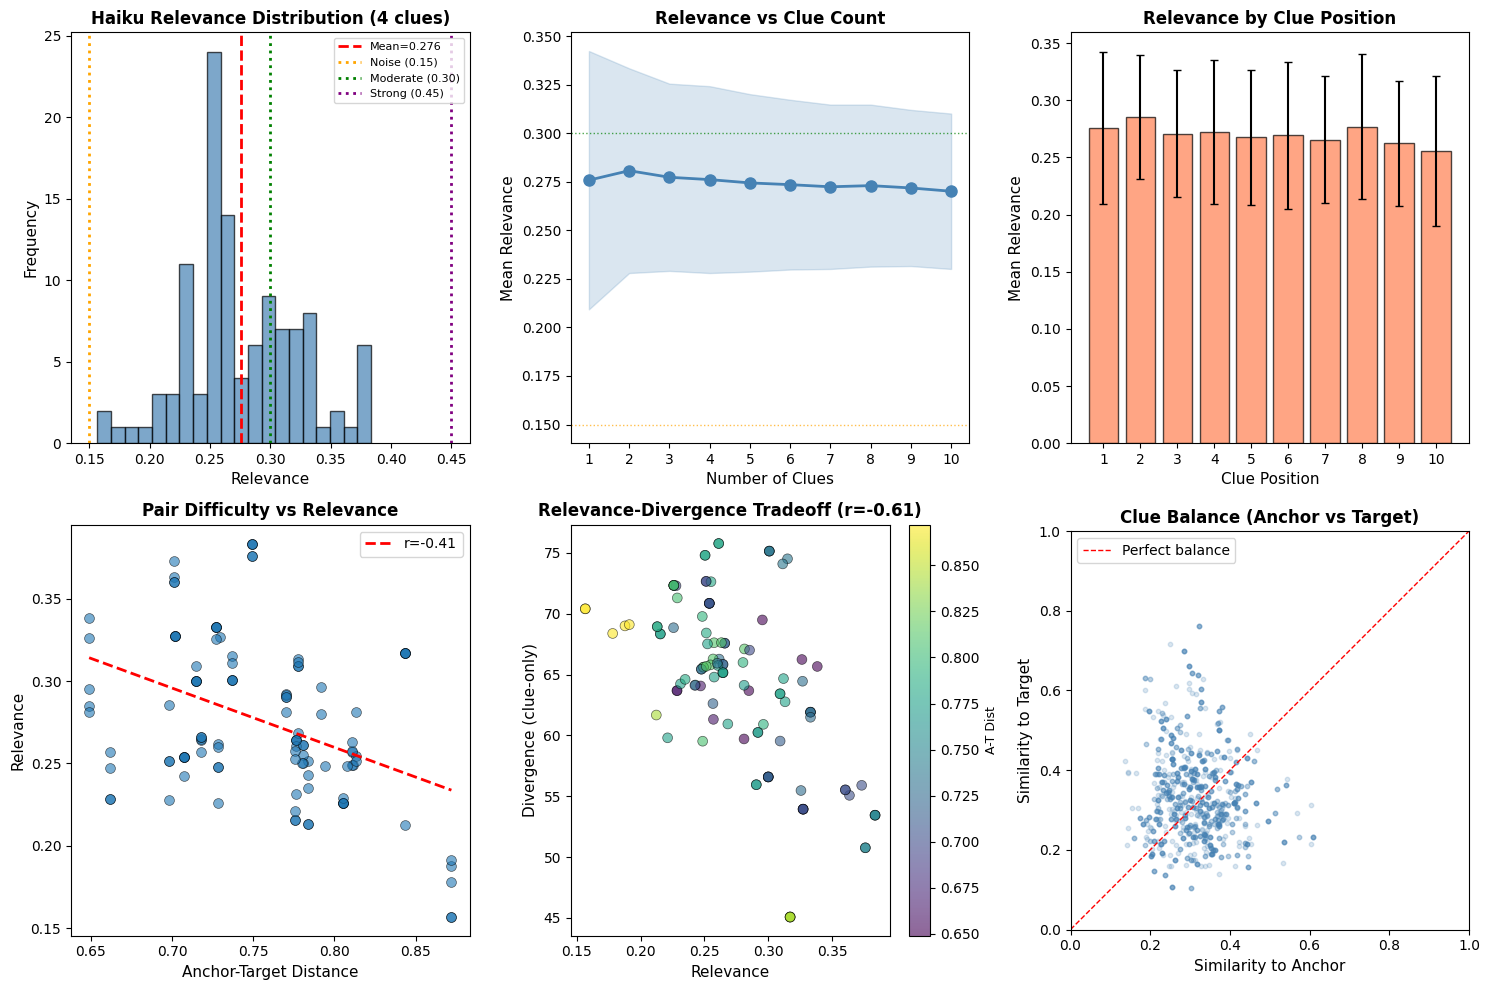

Visualization saved to data/relevance_characterization.png


In [127]:
# Cell 60: Relevance Characterization Visualization

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Haiku relevance distribution
ax1 = axes[0, 0]
ax1.hist(baseline_df["overall_relevance"], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(haiku_relevance_mean, color='red', linestyle='--', linewidth=2, label=f'Mean={haiku_relevance_mean:.3f}')
ax1.axvline(0.15, color='orange', linestyle=':', linewidth=2, label='Noise (0.15)')
ax1.axvline(0.30, color='green', linestyle=':', linewidth=2, label='Moderate (0.30)')
ax1.axvline(0.45, color='purple', linestyle=':', linewidth=2, label='Strong (0.45)')
ax1.set_xlabel('Relevance', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title(f'Haiku Relevance Distribution ({REFERENCE_N_CLUES} clues)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=8)

# 2. Relevance vs clue count
ax2 = axes[0, 1]
means = rel_trajectory["overall_relevance_mean"]
stds = rel_trajectory["overall_relevance_std"]
ax2.plot(range(1, 11), means, 'o-', color='steelblue', linewidth=2, markersize=8)
ax2.fill_between(range(1, 11), means - stds, means + stds, color='steelblue', alpha=0.2)
ax2.axhline(0.15, color='orange', linestyle=':', linewidth=1, alpha=0.7)
ax2.axhline(0.30, color='green', linestyle=':', linewidth=1, alpha=0.7)
ax2.set_xlabel('Number of Clues', fontsize=11)
ax2.set_ylabel('Mean Relevance', fontsize=11)
ax2.set_title('Relevance vs Clue Count', fontsize=12, fontweight='bold')
ax2.set_xticks(range(1, 11))

# 3. Relevance by clue position
ax3 = axes[0, 2]
positions = range(1, 11)
pos_means = [position_stats.loc[p, "relevance_mean"] for p in positions]
pos_stds = [position_stats.loc[p, "relevance_std"] for p in positions]
ax3.bar(positions, pos_means, yerr=pos_stds, color='coral', edgecolor='black', alpha=0.7, capsize=3)
ax3.set_xlabel('Clue Position', fontsize=11)
ax3.set_ylabel('Mean Relevance', fontsize=11)
ax3.set_title('Relevance by Clue Position', fontsize=12, fontweight='bold')
ax3.set_xticks(positions)

# 4. Pair difficulty effect
ax4 = axes[1, 0]
ax4.scatter(difficulty_df["at_distance"], difficulty_df["overall_relevance"], 
            alpha=0.6, edgecolor='k', linewidth=0.5, s=50)
z = np.polyfit(difficulty_df["at_distance"], difficulty_df["overall_relevance"], 1)
p_fit = np.poly1d(z)
x_line = np.linspace(difficulty_df["at_distance"].min(), difficulty_df["at_distance"].max(), 100)
ax4.plot(x_line, p_fit(x_line), 'r--', linewidth=2, label=f'r={r_difficulty:.2f}')
ax4.set_xlabel('Anchor-Target Distance', fontsize=11)
ax4.set_ylabel('Relevance', fontsize=11)
ax4.set_title('Pair Difficulty vs Relevance', fontsize=12, fontweight='bold')
ax4.legend()

# 5. Relevance-divergence tradeoff
ax5 = axes[1, 1]
scatter5 = ax5.scatter(tradeoff_df["overall_relevance"], tradeoff_df["clue_only_divergence"],
            alpha=0.6, edgecolor='k', linewidth=0.5, c=tradeoff_df["at_distance"], cmap='viridis', s=50)
ax5.set_xlabel('Relevance', fontsize=11)
ax5.set_ylabel('Divergence (clue-only)', fontsize=11)
ax5.set_title(f'Relevance-Divergence Tradeoff (r={r_tradeoff:.2f})', fontsize=12, fontweight='bold')
cbar5 = plt.colorbar(scatter5, ax=ax5)
cbar5.set_label('A-T Dist', fontsize=9)

# 6. Clue balance (sim_anchor vs sim_target)
ax6 = axes[1, 2]
ax6.scatter(clue_df["sim_anchor"], clue_df["sim_target"], alpha=0.2, s=10, c='steelblue')
ax6.plot([0, 1], [0, 1], 'r--', linewidth=1, label='Perfect balance')
ax6.set_xlabel('Similarity to Anchor', fontsize=11)
ax6.set_ylabel('Similarity to Target', fontsize=11)
ax6.set_title('Clue Balance (Anchor vs Target)', fontsize=12, fontweight='bold')
ax6.set_xlim(0, 1)
ax6.set_ylim(0, 1)
ax6.legend()
ax6.set_aspect('equal')

plt.tight_layout()
plt.savefig('data/relevance_characterization.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization saved to data/relevance_characterization.png")

In [129]:
# Cell 61: Relevance Characterization Summary and Export

print("=" * 70)
print("RELEVANCE METRIC CHARACTERIZATION: SUMMARY")
print("=" * 70)
print()

print(f"1. HAIKU BASELINE ({REFERENCE_N_CLUES} clues)")
print("-" * 40)
print(f"   Mean relevance: {haiku_relevance_mean:.4f}")
print(f"   SD: {haiku_relevance_std:.4f}")
print(f"   Median: {haiku_relevance_median:.4f}")
print(f"   Range: {baseline_df['overall_relevance'].min():.4f} - {baseline_df['overall_relevance'].max():.4f}")
print()

print("2. CLUE COUNT TRAJECTORY")
print("-" * 40)
if rel_trend_results["significant"]:
    direction = "decreases" if rel_trend_results["slope"] < 0 else "increases"
    print(f"   Trend: {rel_trend_results['slope']:.5f} per clue (p={rel_trend_results['p']:.4f})")
    print(f"   Relevance {direction} with more clues")
else:
    print(f"   No significant trend (p={rel_trend_results['p']:.4f})")
    print(f"   Relevance stable across clue counts")
print()

print("3. CLUE POSITION EFFECTS")
print("-" * 40)
if position_effect_results["significant"]:
    print(f"   Significant position effect (F={position_effect_results['f_anova']:.2f}, p={position_effect_results['p_anova']:.4f})")
    print(f"   Clue 1 mean: {position_groups[0].mean():.4f}")
    print(f"   Clue 10 mean: {position_groups[-1].mean():.4f}")
else:
    print(f"   No significant position effect (p={position_effect_results['p_anova']:.4f})")
print()

print("4. PAIR DIFFICULTY EFFECT")
print("-" * 40)
print(f"   A-T distance vs relevance: r={difficulty_effect_results['r']:.4f}, p={difficulty_effect_results['p']:.4f}")
if difficulty_effect_results['r'] < 0 and difficulty_effect_results['p'] < 0.05:
    print("   ⚠ Harder pairs → Lower achievable relevance")
else:
    print("   ✓ Relevance independent of pair difficulty")
print()

print("5. RELEVANCE-DIVERGENCE TRADEOFF")
print("-" * 40)
print(f"   Trial-level correlation: r={tradeoff_results['r_trial_level']:.4f}")
if tradeoff_results["has_tradeoff"]:
    print("   ⚠ Tradeoff exists: participants must balance relevance vs divergence")
else:
    print("   ✓ No strong tradeoff: both can be optimized")
print()

print("6. THRESHOLD RECOMMENDATIONS")
print("-" * 40)
print(f"   Haiku 10th percentile: {p10:.4f} (proposed 'Poor' threshold)")
print(f"   Haiku 50th percentile: {p50:.4f} (proposed 'Average' midpoint)")
print(f"   Haiku 90th percentile: {p90:.4f} (proposed 'Excellent' threshold)")
print()

# Save parameters
relevance_params = {
    "timestamp": datetime.now().isoformat(),
    "reference_n_clues": int(REFERENCE_N_CLUES),
    "haiku_baseline": {
        "mean": float(haiku_relevance_mean),
        "std": float(haiku_relevance_std),
        "median": float(haiku_relevance_median),
        "min": float(baseline_df['overall_relevance'].min()),
        "max": float(baseline_df['overall_relevance'].max()),
        "percentiles": {str(p): float(v) for p, v in haiku_rel_percentiles.items()}
    },
    "clue_count_trend": {
        "slope": float(rel_trend_results["slope"]),
        "r": float(rel_trend_results["r"]),
        "p_value": float(rel_trend_results["p"]),
        "significant": bool(rel_trend_results["significant"])
    },
    "position_effect": {
        "slope": float(position_effect_results["slope"]),
        "f_stat": float(position_effect_results["f_anova"]),
        "p_value": float(position_effect_results["p_anova"]),
        "significant": bool(position_effect_results["significant"])
    },
    "pair_difficulty_effect": {
        "r": float(difficulty_effect_results["r"]),
        "p_value": float(difficulty_effect_results["p"]),
        "tercile_means": difficulty_effect_results["tercile_means"]
    },
    "tradeoff": {
        "r_trial_level": float(tradeoff_results["r_trial_level"]),
        "p_trial_level": float(tradeoff_results["p_trial_level"]),
        "r_clue_level": float(tradeoff_results["r_clue_level"]),
        "has_tradeoff": bool(tradeoff_results["has_tradeoff"])
    },
    "current_thresholds": {
        "noise": 0.15,
        "weak": 0.30,
        "moderate": 0.45
    },
    "proposed_thresholds": proposed_threshold_values
}

params_file = Path('data/relevance_characterization_params.json')
with open(params_file, 'w') as f:
    json.dump(relevance_params, f, indent=2)

print("7. EXPORT")
print("-" * 40)
print(f"   Parameters saved to: {params_file}")
print()
print("=" * 70)
print("RELEVANCE CHARACTERIZATION COMPLETE")
print("=" * 70)

RELEVANCE METRIC CHARACTERIZATION: SUMMARY

1. HAIKU BASELINE (4 clues)
----------------------------------------
   Mean relevance: 0.2761
   SD: 0.0481
   Median: 0.2645
   Range: 0.1567 - 0.3836

2. CLUE COUNT TRAJECTORY
----------------------------------------
   No significant trend (p=0.0681)
   Relevance stable across clue counts

3. CLUE POSITION EFFECTS
----------------------------------------
   Significant position effect (F=2.16, p=0.0224)
   Clue 1 mean: 0.2758
   Clue 10 mean: 0.2556

4. PAIR DIFFICULTY EFFECT
----------------------------------------
   A-T distance vs relevance: r=-0.4055, p=0.0000
   ⚠ Harder pairs → Lower achievable relevance

5. RELEVANCE-DIVERGENCE TRADEOFF
----------------------------------------
   Trial-level correlation: r=-0.6085
   ⚠ Tradeoff exists: participants must balance relevance vs divergence

6. THRESHOLD RECOMMENDATIONS
----------------------------------------
   Haiku 10th percentile: 0.2258 (proposed 'Poor' threshold)
   Haiku 50th pe